## Zillow Time Series Data

## Import libraries

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Data Collection

In [34]:
zillow_df = pd.read_csv('../data/raw/zillow_data.csv')

In [35]:
zillow_df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [36]:
len(zillow_df['RegionID'].unique())==len(zillow_df)

True

In [37]:
len(zillow_df['City'].unique())

7554

In [38]:
chicago_df = zillow_df[zillow_df['City']=='Chicago']

In [39]:
zillow_dates = chicago_df[chicago_df.columns[7:]]
zillow_dates.head()

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0   334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
3   498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
7   216500.0  216700.0  216900.0  217000.0  217100.0  217200.0  217500.0   
16  122700.0  122800.0  122800.0  122700.0  122400.0  122000.0  121500.0   
19  142600.0  143100.0  143400.0  143300.0  142900.0  142200.0  141300.0   

     1996-11   1996-12   1997-01   ...     2017-07  2017-08  2017-09  2017-10  \
0   341300.0  342600.0  344400.0   ...     1005500  1007500  1007800  1009600   
3   504200.0  503600.0  503400.0   ...     1289800  1287700  1287400  1291500   
7   217900.0  218600.0  219700.0   ...      798000   787100   776100   774900   
16  120900.0  120500.0  120300.0   ...      459600   461400   464300   466500   
19  140100.0  139000.0  138000.0   ...      462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 265 columns]

In [40]:
zillow_T = zillow_dates.T
zillow_T.reset_index(inplace=True)

In [41]:
chicago_index = zillow_df.index[zillow_df['City']=='Chicago']
chicago_index

Int64Index([   0,    3,    7,   16,   19,   40,   48,   50,   74,   79,  105,
             150,  157,  215,  231,  284,  318,  324,  332,  347,  497,  638,
             658,  739,  792, 1012, 1360, 1454, 1496, 1727, 1990, 2360, 2420,
            2585, 2830, 3149, 3156, 3960, 4040, 4362, 7863],
           dtype='int64')

In [42]:
chicago_index = chicago_index.astype(str)

In [43]:
zillow_T.rename(columns={'index':'date'}, inplace=True)
zillow_T.head()

date         0         3         7        16        19        40  \
0  1996-04  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1  1996-05  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2  1996-06  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3  1996-07  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4  1996-08  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

        48        50       74   ...         2360      2420      2585  \
0  93400.0  148900.0  76400.0   ...     100900.0  215600.0  165400.0   
1  94100.0  149300.0  77000.0   ...     101400.0  215100.0  165300.0   
2  94600.0  149600.0  77400.0   ...     101900.0  214500.0  165000.0   
3  94800.0  149700.0  77700.0   ...     102300.0  213900.0  164600.0   
4  94700.0  149700.0  77700.0   ...     102700.0  213200.0  164100.0   

       2830      3149      3156      3960      4040      4362     7863  
0  103700.0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  104400.0  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  104700.0  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  104700.0  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  104400.0  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

In [44]:
zillow_T['date'] = pd.to_datetime(zillow_T['date'])
# zillow_T.info()

In [45]:
chicago_zips = zillow_df.RegionName.iloc[chicago_index.astype(int)]
chicago_zips.head()

0     60657
3     60614
7     60640
16    60647
19    60618
Name: RegionName, dtype: int64

In [46]:
zillow_T.columns = ['date']+list(chicago_zips)
zillow_chicago = zillow_T
zillow_chicago.head()

date     60657     60614     60640     60647     60618     60613  \
0 1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1 1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2 1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3 1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4 1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

     60629     60625    60619   ...        60612     60607     60659  \
0  93400.0  148900.0  76400.0   ...     100900.0  215600.0  165400.0   
1  94100.0  149300.0  77000.0   ...     101400.0  215100.0  165300.0   
2  94600.0  149600.0  77400.0   ...     101900.0  214500.0  165000.0   
3  94800.0  149700.0  77700.0   ...     102300.0  213900.0  164600.0   
4  94700.0  149700.0  77700.0   ...     102700.0  213200.0  164100.0   

      60652     60631     60656     60655     60646     60642    60633  
0  103700.0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  104400.0  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  104700.0  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  104700.0  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  104400.0  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

In [47]:
zillow_chicago.set_index('date', inplace=True)

In [48]:
zillow_chicago.head()

60657     60614     60640     60647     60618     60613  \
date                                                                     
1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

              60629     60625    60619     60610   ...        60612     60607  \
date                                               ...                          
1996-04-01  93400.0  148900.0  76400.0  435200.0   ...     100900.0  215600.0   
1996-05-01  94100.0  149300.0  77000.0  435200.0   ...     101400.0  215100.0   
1996-06-01  94600.0  149600.0  77400.0  435100.0   ...     101900.0  214500.0   
1996-07-01  94800.0  149700.0  77700.0  434600.0   ...     102300.0  213900.0   
1996-08-01  94700.0  149700.0  77700.0  433900.0   ...     102700.0  213200.0   

               60659     60652     60631     60656     60655     60646  \
date                                                                     
1996-04-01  165400.0  103700.0  180900.0  166300.0  125700.0  197300.0   
1996-05-01  165300.0  104400.0  182200.0  166900.0  126300.0  198900.0   
1996-06-01  165000.0  104700.0  183100.0  167200.0  126600.0  200100.0   
1996-07-01  164600.0  104700.0  183500.0  167100.0  126500.0  200800.0   
1996-08-01  164100.0  104400.0  183400.0  166900.0  126100.0  201000.0   

               60642    60633  
date                           
1996-04-01  224100.0  77900.0  
1996-05-01  223300.0  78200.0  
1996-06-01  222400.0  78300.0  
1996-07-01  221500.0  78500.0  
1996-08-01  220500.0  78500.0  

[5 rows x 41 columns]

In [49]:
deflation_factors_2017 = pd.DataFrame({'year': [2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                          'factor': [0.950, 0.966, 0.967, 0.979, 1.000, 1.020, 1.042]})
deflation_factors_2017['year'] = pd.to_datetime(deflation_factors_2017['year'], format='%Y')
deflation_factors_2017.set_index('year', inplace=True)
deflation_mon_2017 = deflation_factors_2017.resample('M').ffill()
deflation_mon_2017 = deflation_mon_2017[:-9]
deflation_mon_2017.index = [pd.datetime(x.year, x.month, 1) for x in deflation_mon_2017.index.tolist()] 
deflation_mon_2017

factor
2013-01-01   0.950
2013-02-01   0.950
2013-03-01   0.950
2013-04-01   0.950
2013-05-01   0.950
2013-06-01   0.950
2013-07-01   0.950
2013-08-01   0.950
2013-09-01   0.950
2013-10-01   0.950
2013-11-01   0.950
2013-12-01   0.950
2014-01-01   0.966
2014-02-01   0.966
2014-03-01   0.966
2014-04-01   0.966
2014-05-01   0.966
2014-06-01   0.966
2014-07-01   0.966
2014-08-01   0.966
2014-09-01   0.966
2014-10-01   0.966
2014-11-01   0.966
2014-12-01   0.966
2015-01-01   0.967
2015-02-01   0.967
2015-03-01   0.967
2015-04-01   0.967
2015-05-01   0.967
2015-06-01   0.967
...            ...
2015-11-01   0.967
2015-12-01   0.967
2016-01-01   0.979
2016-02-01   0.979
2016-03-01   0.979
2016-04-01   0.979
2016-05-01   0.979
2016-06-01   0.979
2016-07-01   0.979
2016-08-01   0.979
2016-09-01   0.979
2016-10-01   0.979
2016-11-01   0.979
2016-12-01   0.979
2017-01-01   1.000
2017-02-01   1.000
2017-03-01   1.000
2017-04-01   1.000
2017-05-01   1.000
2017-06-01   1.000
2017-07-01   1.000
2017-08-01   1.000
2017-09-01   1.000
2017-10-01   1.000
2017-11-01   1.000
2017-12-01   1.000
2018-01-01   1.020
2018-02-01   1.020
2018-03-01   1.020
2018-04-01   1.020

[64 rows x 1 columns]

In [50]:
zillow_chicago_d = pd.concat([zillow_chicago.loc['2013':,:], deflation_mon_2017], axis=1)
for column in zillow_chicago_d.columns[:-1]:
    zillow_chicago_d[column] = zillow_chicago_d[column].div(zillow_chicago_d['factor'])
zillow_chicago_d

60657         60614          60640          60647  \
date                                                                   
2013-01-01  8.445263e+05  1.059263e+06  576210.526316  315473.684211   
2013-02-01  8.485263e+05  1.067053e+06  578842.105263  320631.578947   
2013-03-01  8.535789e+05  1.078737e+06  586000.000000  327157.894737   
2013-04-01  8.604211e+05  1.092947e+06  596631.578947  333894.736842   
2013-05-01  8.703158e+05  1.109368e+06  604210.526316  339052.631579   
2013-06-01  8.820000e+05  1.126947e+06  611789.473684  344526.315789   
2013-07-01  8.927368e+05  1.147263e+06  619473.684211  350315.789474   
2013-08-01  8.987368e+05  1.166421e+06  622526.315789  351684.210526   
2013-09-01  9.017895e+05  1.182842e+06  622842.105263  349578.947368   
2013-10-01  9.016842e+05  1.194842e+06  622947.368421  347789.473684   
2013-11-01  8.993684e+05  1.201053e+06  620526.315789  346315.789474   
2013-12-01  8.978947e+05  1.204105e+06  618105.263158  343894.736842   
2014-01-01  8.863354e+05  1.186128e+06  607971.014493  336231.884058   
2014-02-01  8.899586e+05  1.187888e+06  609213.250518  335714.285714   
2014-03-01  8.943064e+05  1.190373e+06  610455.486542  337060.041408   
2014-04-01  9.036232e+05  1.195859e+06  614182.194617  339544.513458   
2014-05-01  9.143892e+05  1.200932e+06  624120.082816  342753.623188   
2014-06-01  9.208075e+05  1.204244e+06  635921.325052  346273.291925   
2014-07-01  9.242236e+05  1.208799e+06  646376.811594  349482.401656   
2014-08-01  9.250518e+05  1.215217e+06  657039.337474  351138.716356   
2014-09-01  9.226708e+05  1.216460e+06  667080.745342  352484.472050   
2014-10-01  9.212215e+05  1.214803e+06  674637.681159  355383.022774   
2014-11-01  9.228778e+05  1.216874e+06  680745.341615  358385.093168   
2014-12-01  9.244306e+05  1.219979e+06  685300.207039  360455.486542   
2015-01-01  9.234747e+05  1.216546e+06  684798.345398  362357.807653   
2015-02-01  9.255429e+05  1.214685e+06  686349.534643  363908.996898   
2015-03-01  9.319545e+05  1.218718e+06  691520.165460  365770.423992   
2015-04-01  9.404343e+05  1.226163e+06  696794.208893  371251.292658   
2015-05-01  9.462254e+05  1.233609e+06  700206.825233  377973.112720   
2015-06-01  9.479835e+05  1.239710e+06  706204.756980  380972.078594   
...                  ...           ...            ...            ...   
2015-11-01  9.805584e+05  1.260186e+06  741778.697001  403412.616339   
2015-12-01  9.834540e+05  1.268459e+06  751189.245088  407342.295760   
2016-01-01  9.729316e+05  1.257099e+06  750459.652707  407048.008172   
2016-02-01  9.791624e+05  1.261900e+06  755260.469867  414811.031665   
2016-03-01  9.869254e+05  1.267926e+06  752706.843718  423901.940756   
2016-04-01  9.912155e+05  1.272421e+06  748518.896834  430949.948927   
2016-05-01  9.947906e+05  1.273749e+06  746680.286006  435852.911134   
2016-06-01  9.956078e+05  1.273442e+06  746169.560776  439632.277835   
2016-07-01  9.934627e+05  1.272421e+06  746475.995914  444024.514811   
2016-08-01  9.951992e+05  1.272727e+06  751276.813075  448416.751788   
2016-09-01  1.001839e+06  1.274464e+06  755873.340143  452298.263534   
2016-10-01  1.009193e+06  1.279775e+06  755975.485189  454749.744637   
2016-11-01  1.016037e+06  1.287947e+06  757405.515832  457303.370787   
2016-12-01  1.020123e+06  1.295097e+06  762104.187947  457609.805924   
2017-01-01  9.970000e+05  1.272600e+06  749500.000000  445400.000000   
2017-02-01  9.937000e+05  1.276600e+06  754800.000000  445000.000000   
2017-03-01  9.913000e+05  1.280300e+06  765800.000000  447900.000000   
2017-04-01  9.892000e+05  1.282500e+06  776600.000000  450600.000000   
2017-05-01  9.913000e+05  1.286000e+06  785900.000000  453700.000000   
2017-06-01  9.991000e+05  1.289000e+06  795500.000000  457300.000000   
2017-07-01  1.005500e+06  1.289800e+06  798000.000000  459600.000000   
2017-08-01  1.007500e+06  1.287700e+06  787100.000000  461400.000000   
2017-09-01  1.007800e+06  1.287400e+06  776100.000000  4643

After some analysis below, we went back to our original dataframe and decided to use a subset of the years from 2012 onwards. 

In [239]:
zillow_chicago_train = zillow_chicago_d.loc['2013':'2017-10',:]
zillow_chicago_test = zillow_chicago_d.loc['2017-11':,:]


zillow_chicago_train.drop([60611, 'factor'], axis=1, inplace=True)
zillow_chicago_test.drop([60611, 'factor'], axis=1, inplace=True)



## Exploratory Analysis
- Baseline model
	- Staitonarity (e.g. trends, seasonal patterns, cyclical patterns, differencing, Dickey Fuller Test)  
	- ACF
	- PACF
	- At least AR and MA models
	- Evaluation metric  

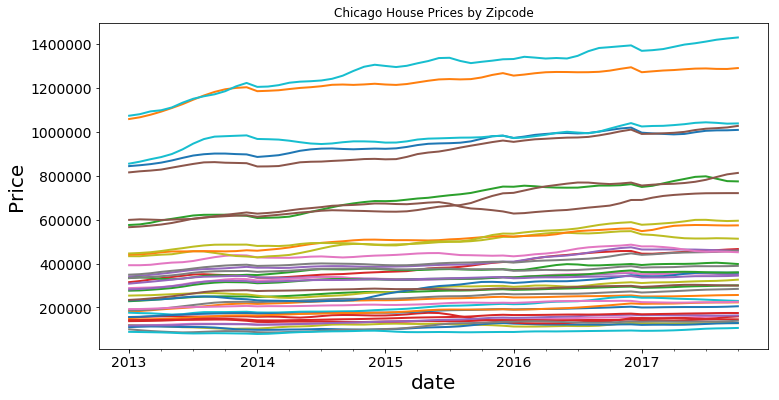

In [52]:
cat = zillow_chicago_train.plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
cat.legend().remove()


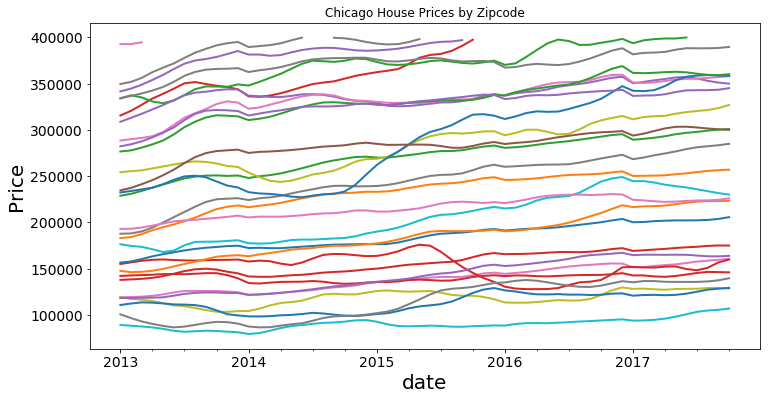

In [53]:
dog = zillow_chicago_train[zillow_chicago_train<400000].plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
dog.legend().remove()



In [54]:
# cat = zillow_chicago['2014'].plot(figsize=(12,6), linewidth=2, fontsize=14)
# plt.xlabel('date', fontsize=20)
# plt.ylabel('Price', fontsize=20)
# plt.title('Chicago House Prices by Zipcode')
# cat.legend().remove()

From the previous plot, we can see there is no seasonality in the data.

In [19]:
# zillow_chicago.loc['2014',60657].plot()

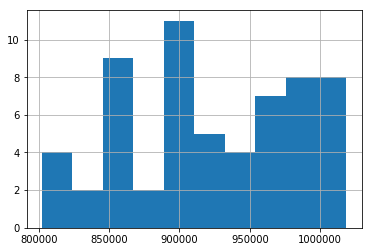

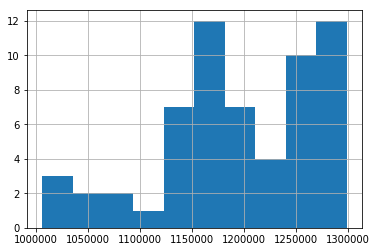

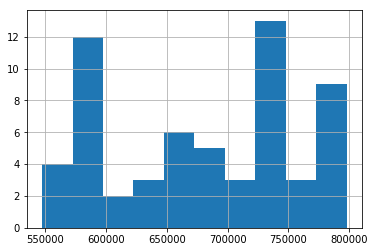

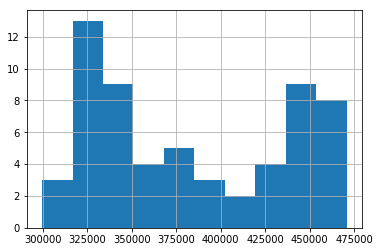

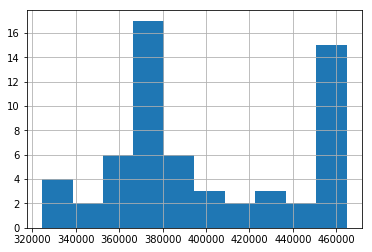

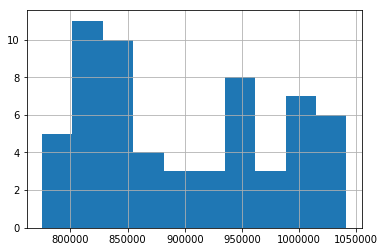

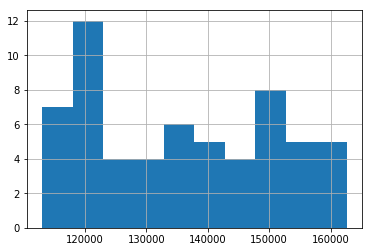

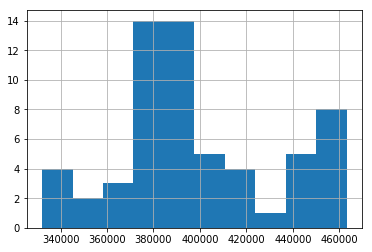

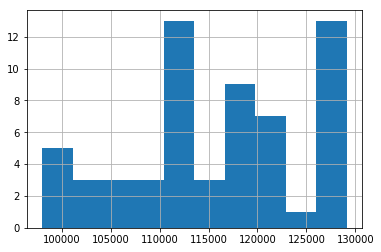

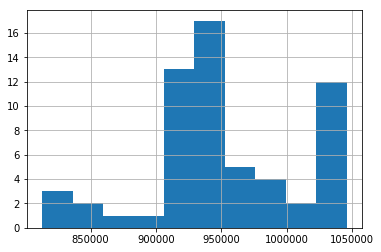

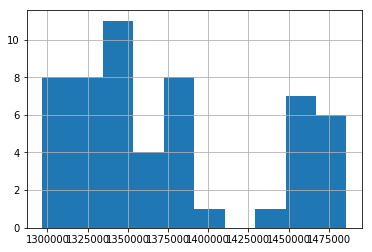

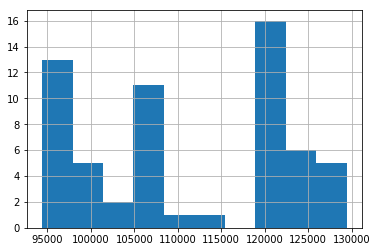

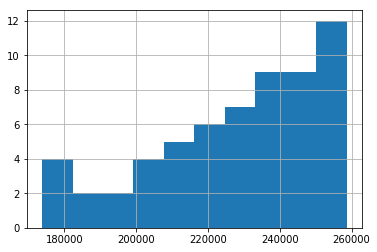

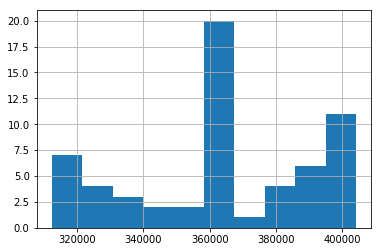

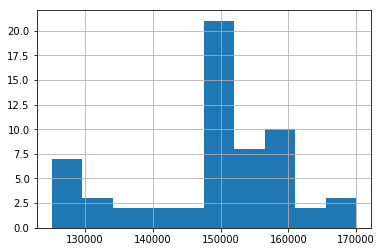

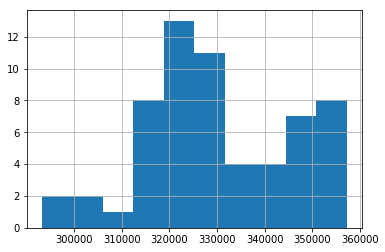

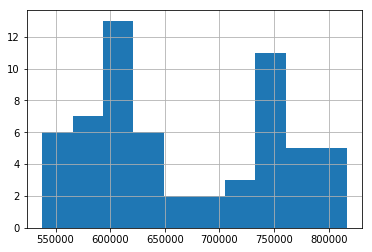

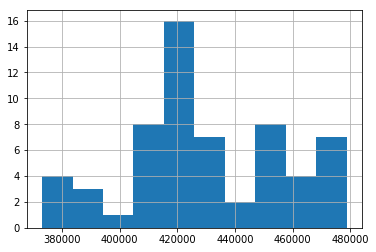

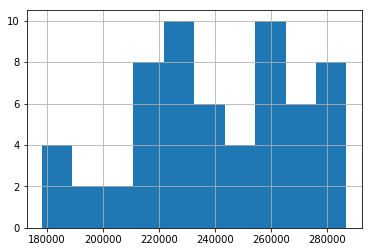

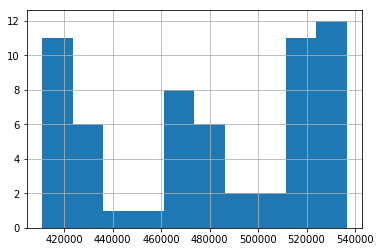

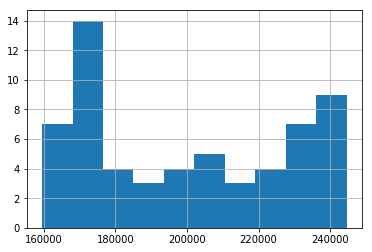

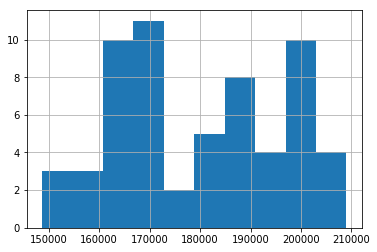

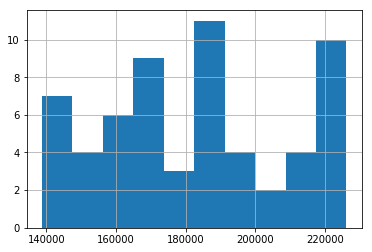

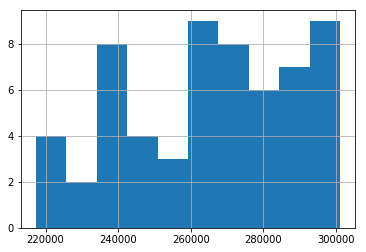

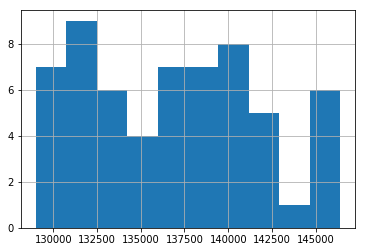

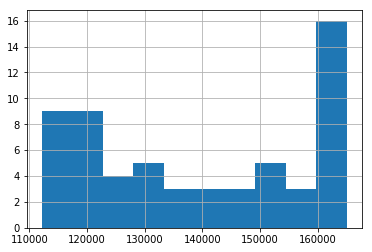

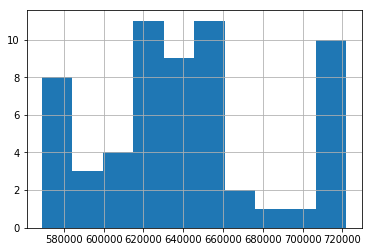

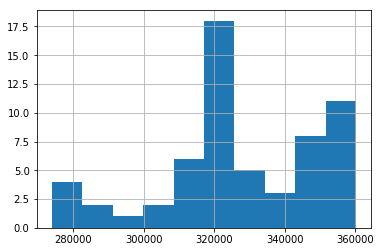

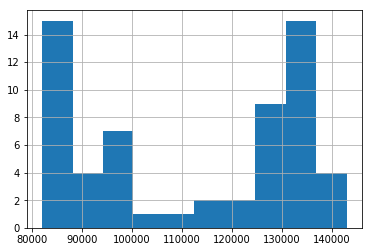

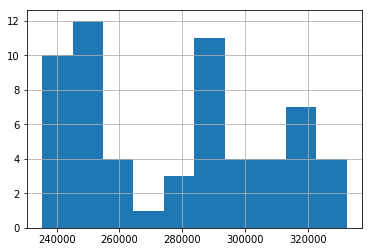

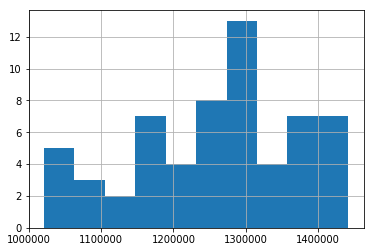

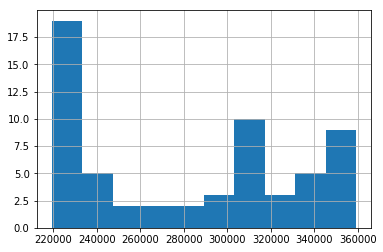

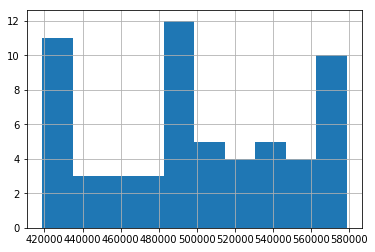

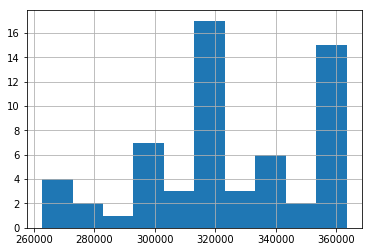

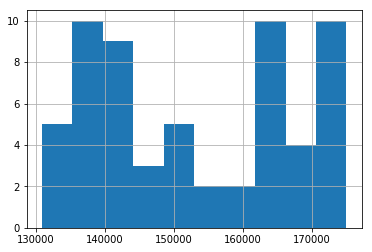

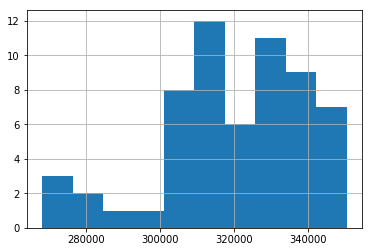

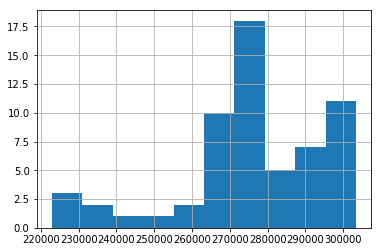

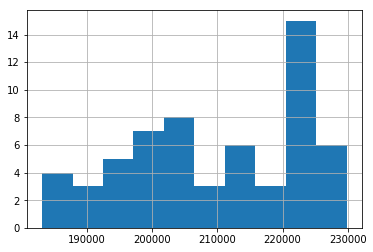

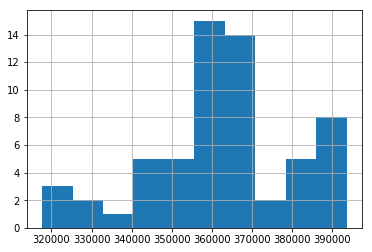

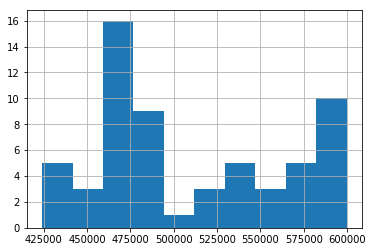

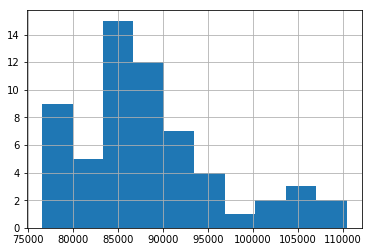

In [20]:
for zipcode in list(zillow_chicago.columns):
    zillow_chicago.loc[:,zipcode].hist()
    plt.show()
    
# price and count of where it spent the most time at which price point

In order to run analysis on the zipcode, we need to detrend our data from any trends associated with climate, season, etc. 

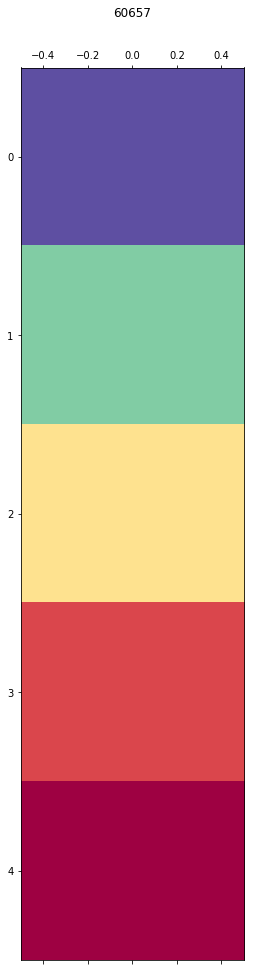

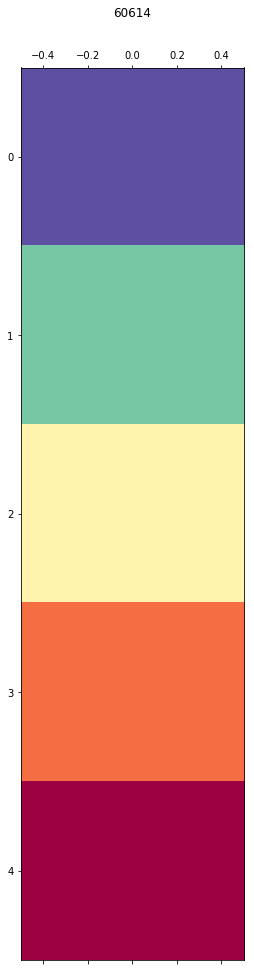

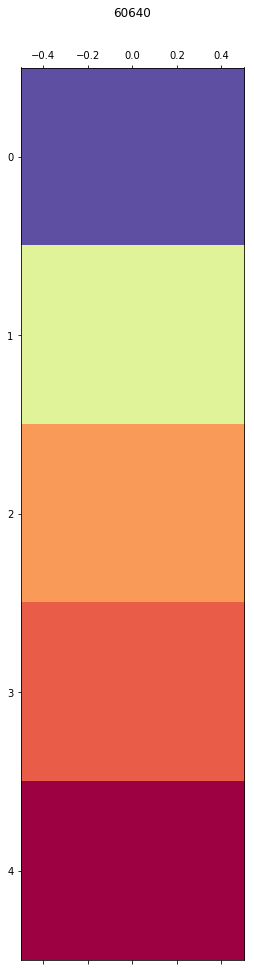

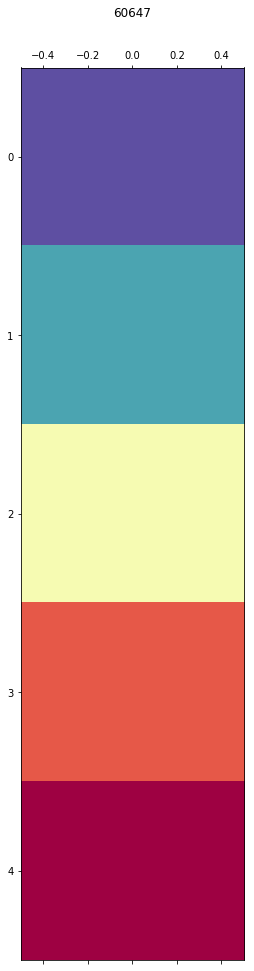

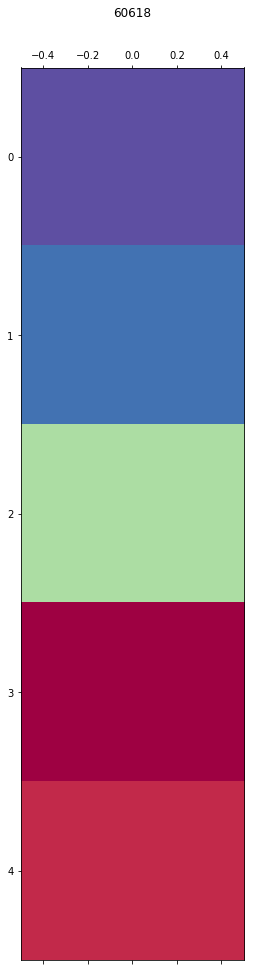

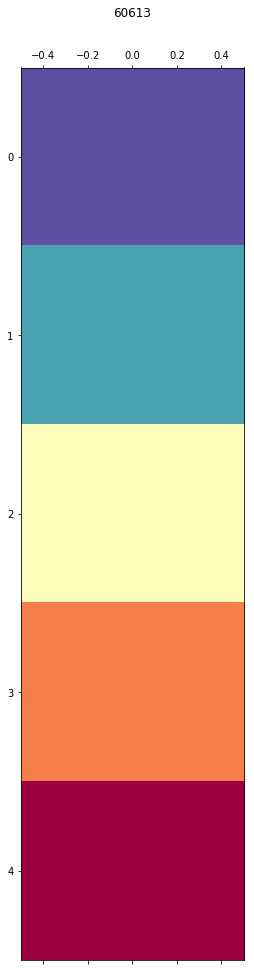

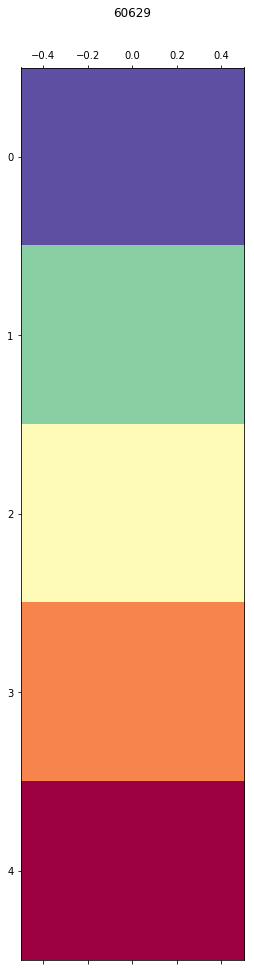

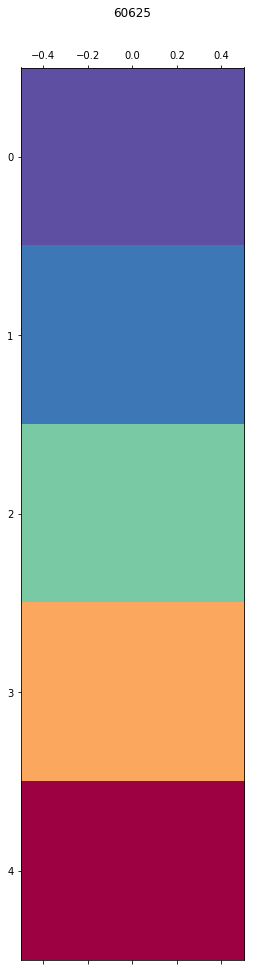

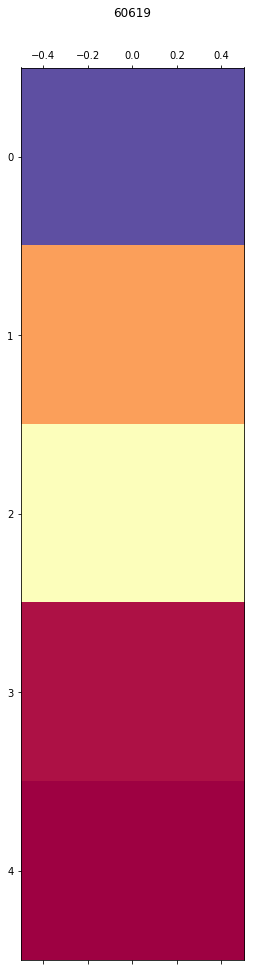

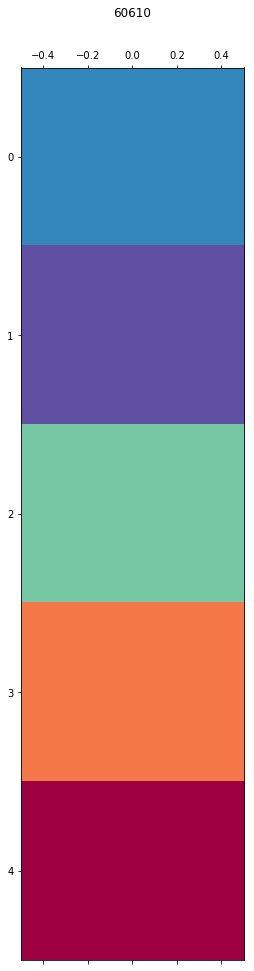

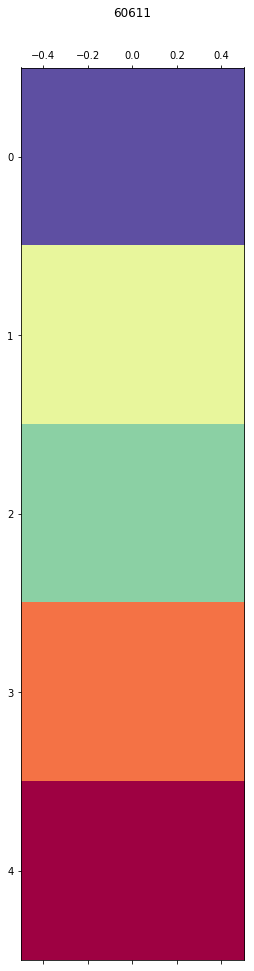

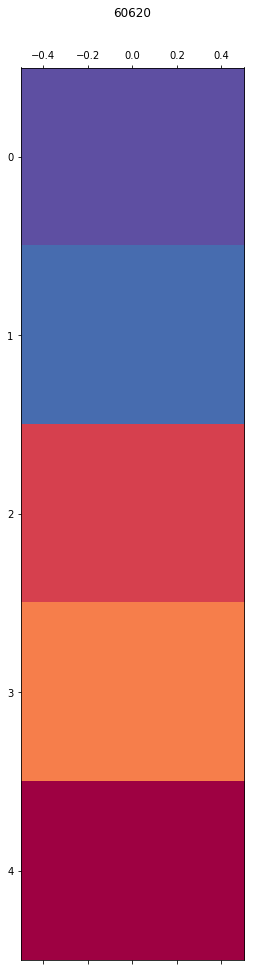

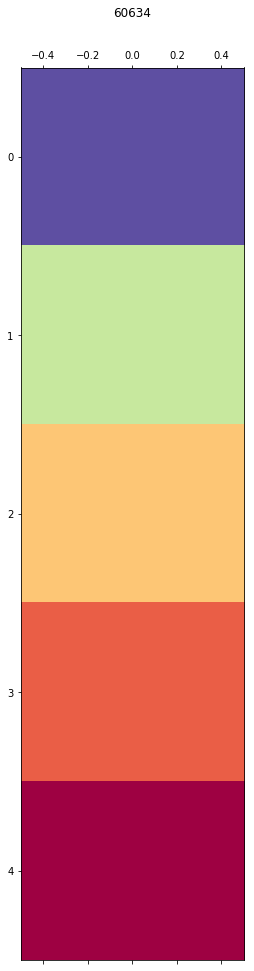

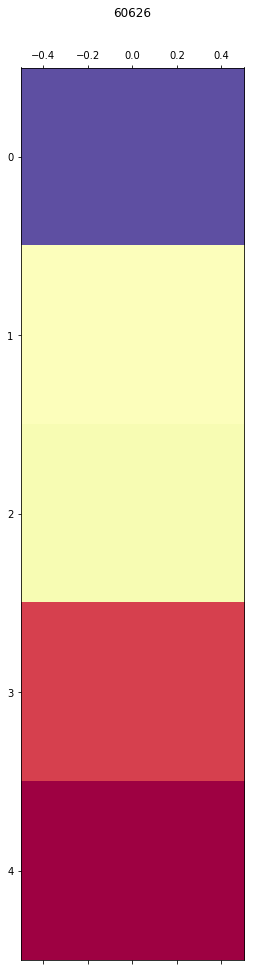

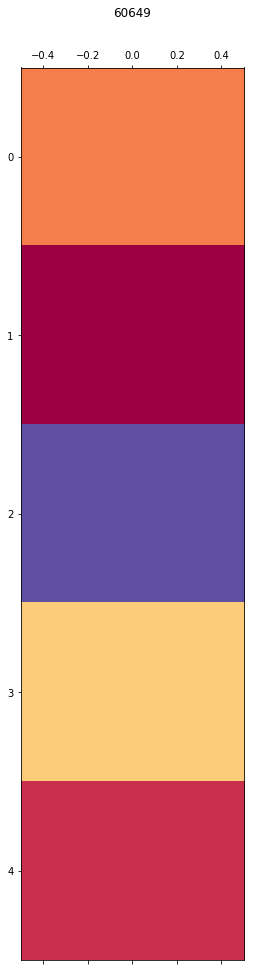

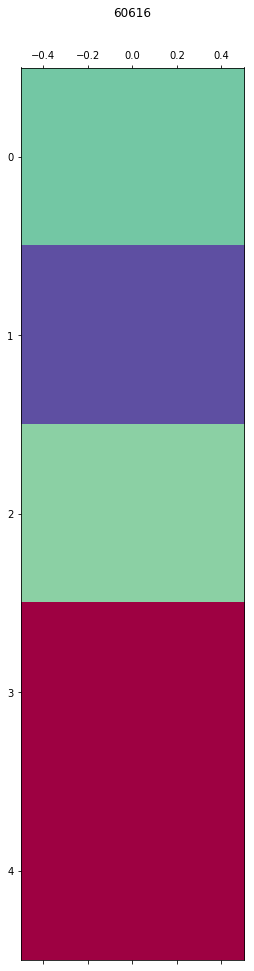

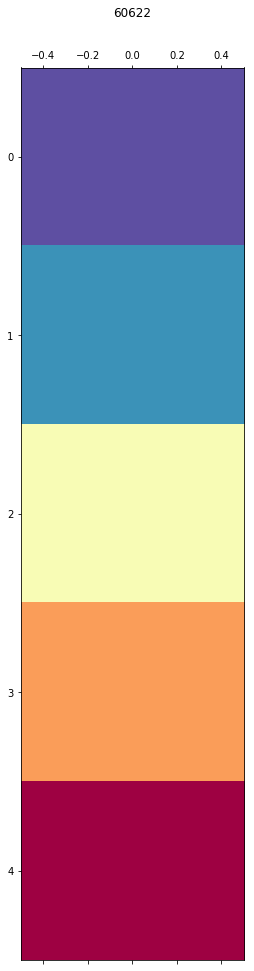

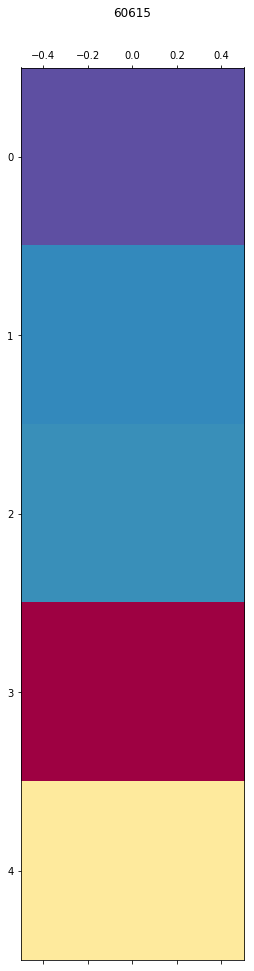

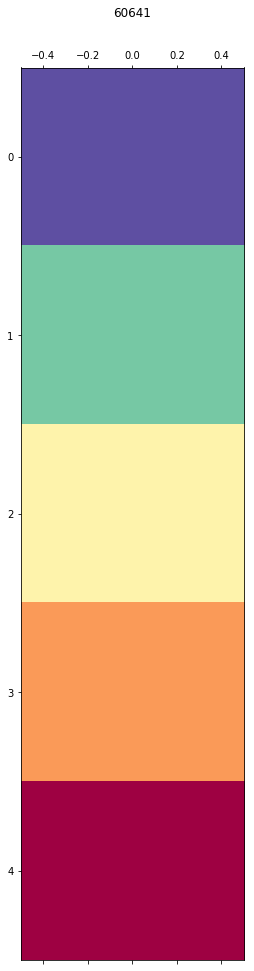

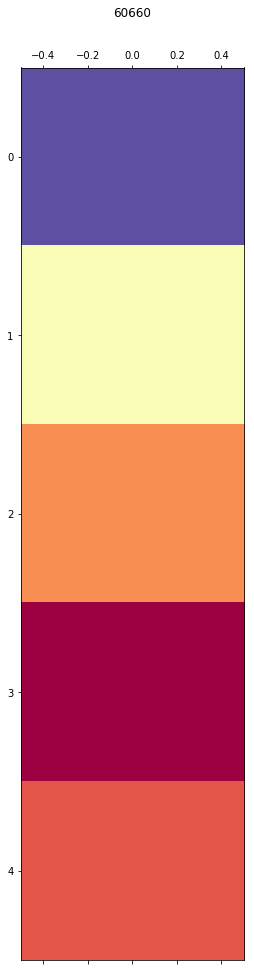

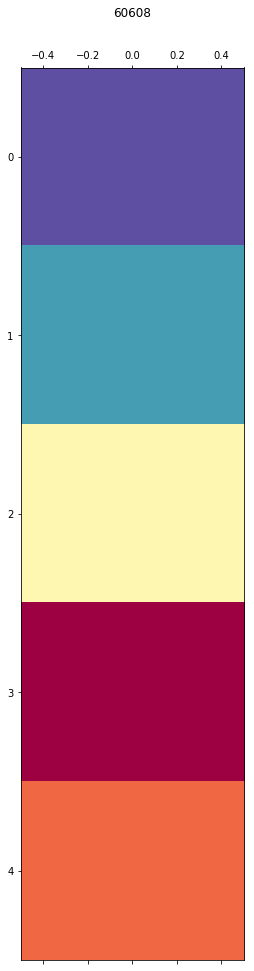

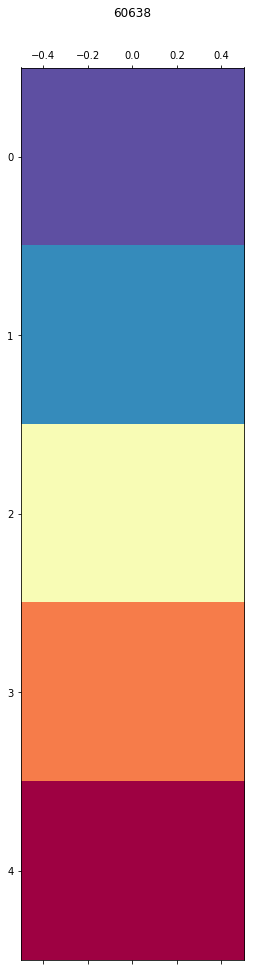

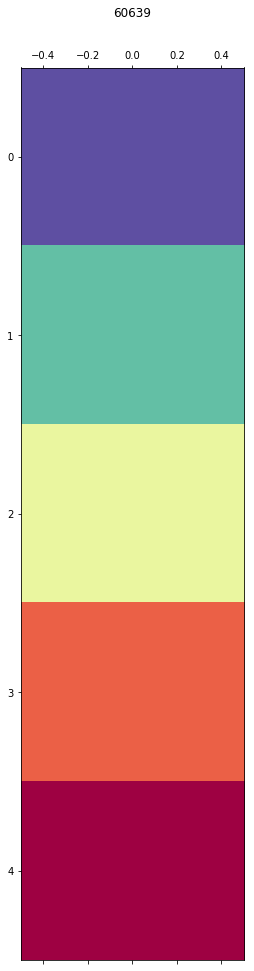

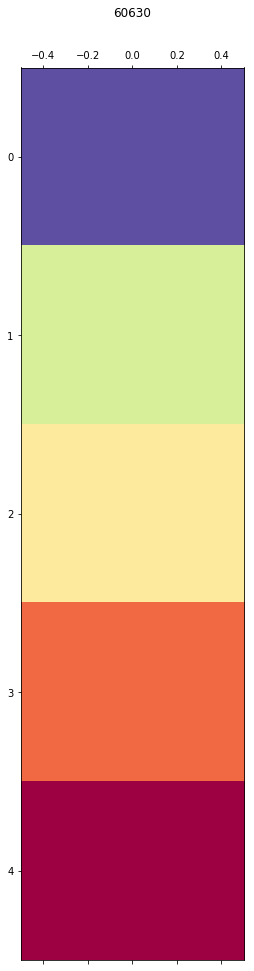

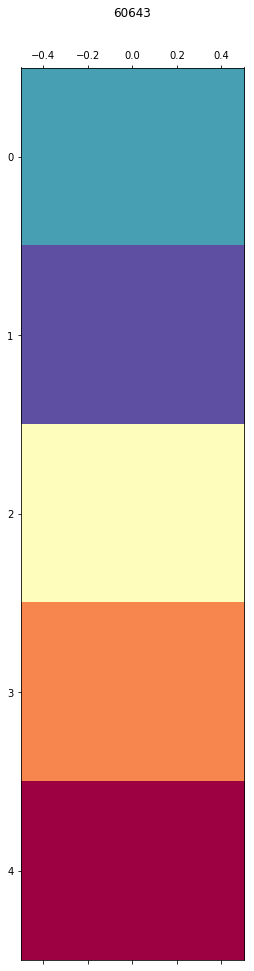

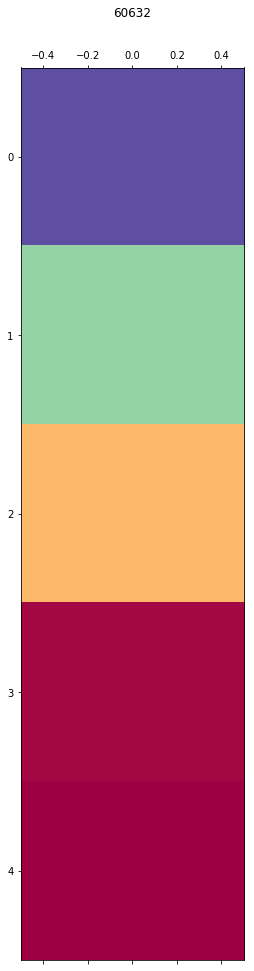

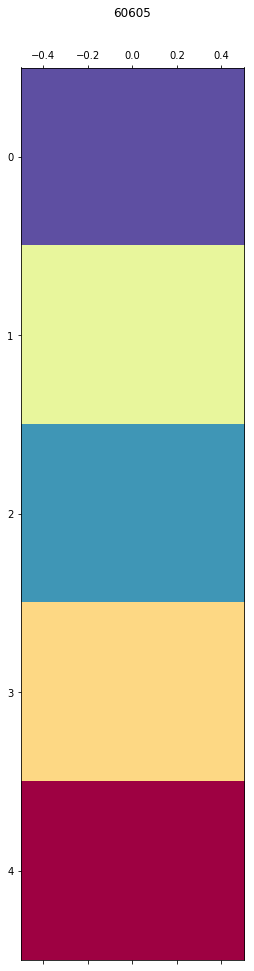

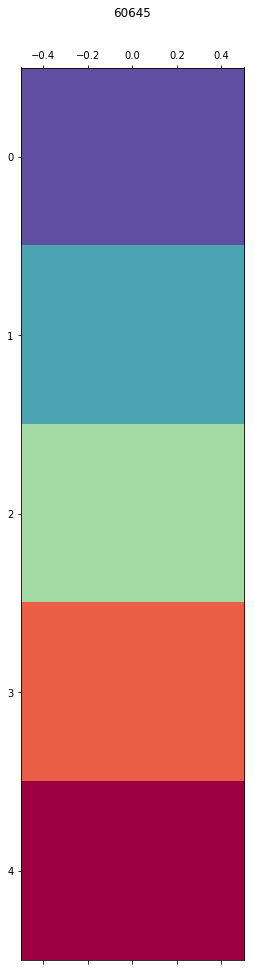

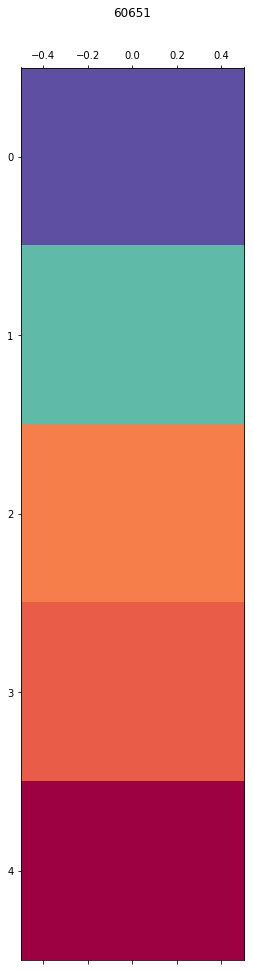

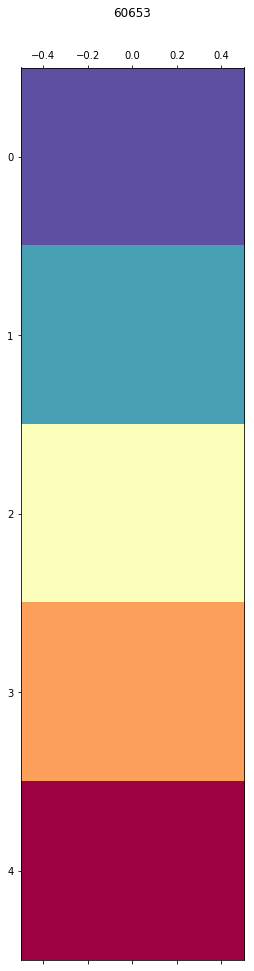

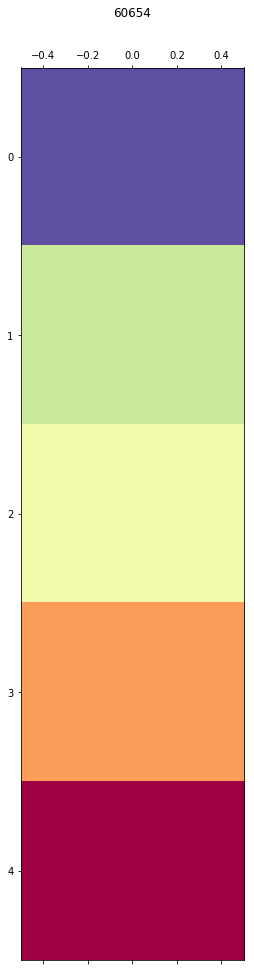

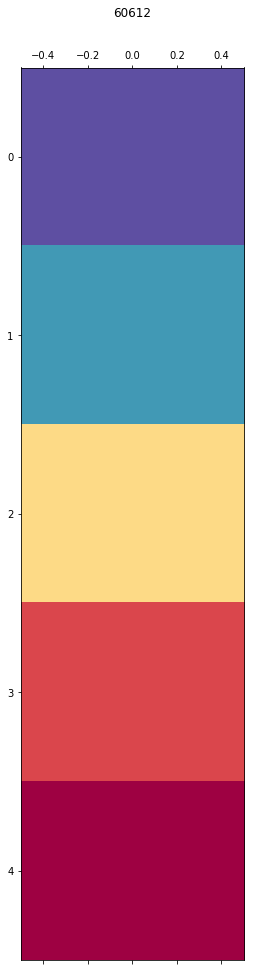

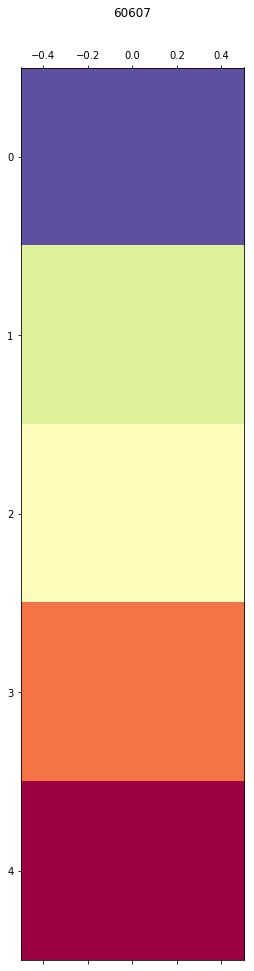

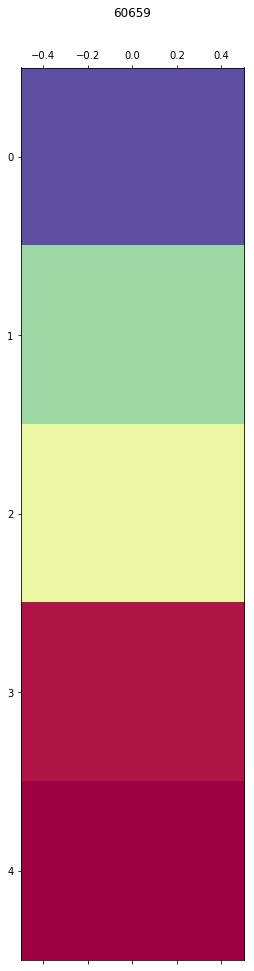

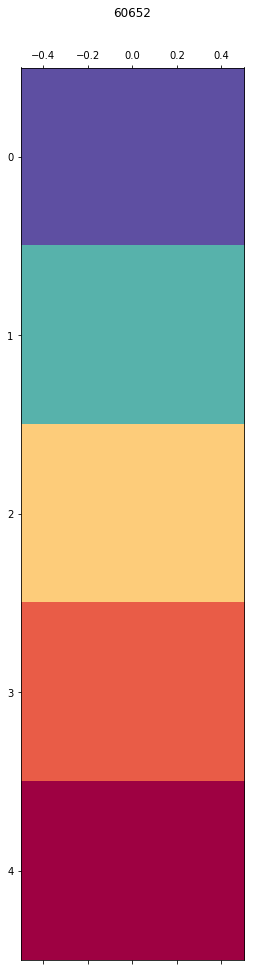

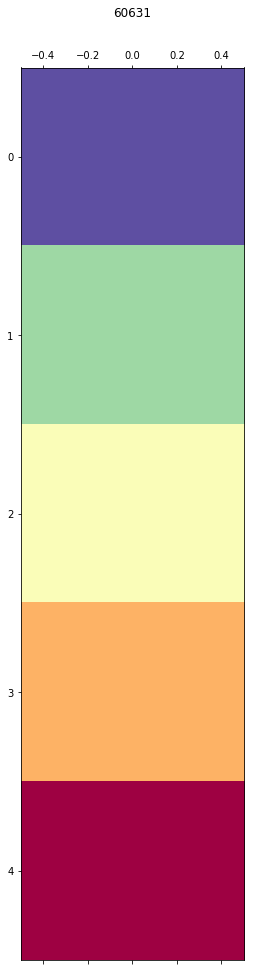

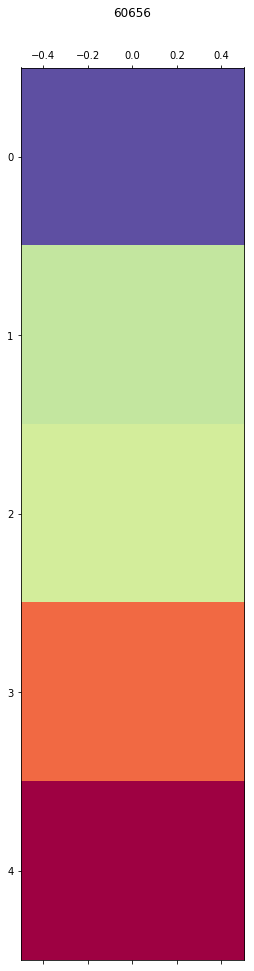

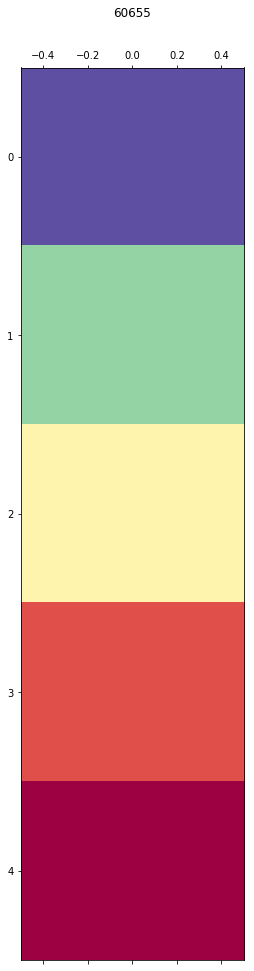

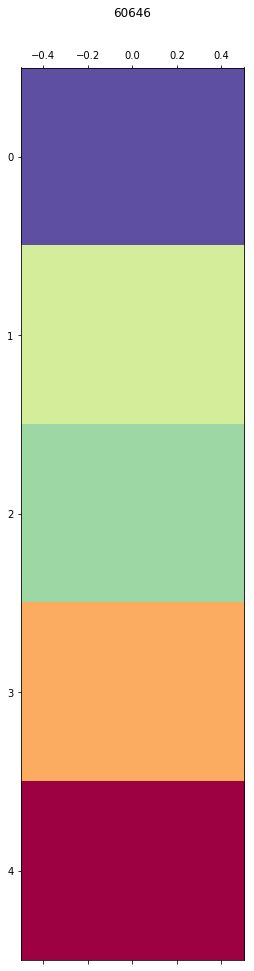

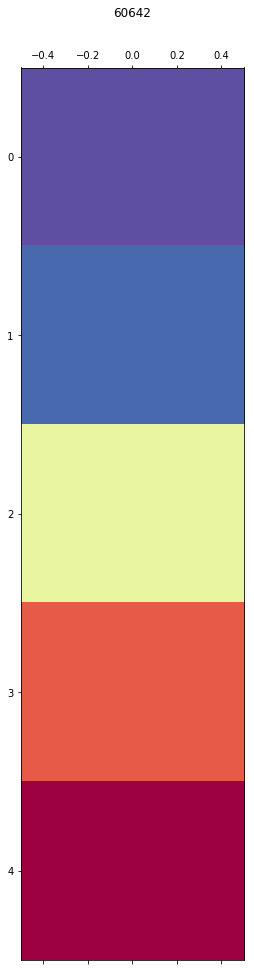

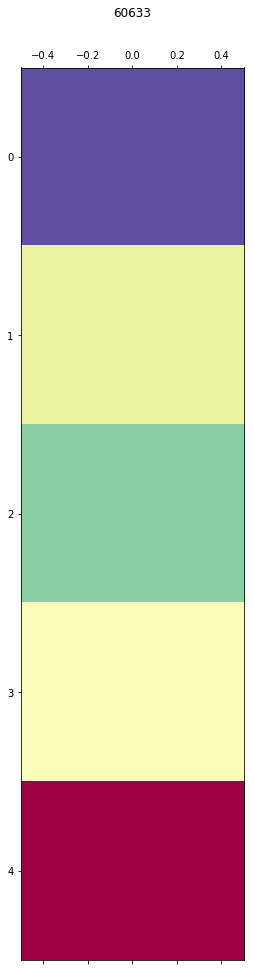

In [21]:
# Grouping data
for zipcode in list(zillow_chicago.columns):
    frequency = 'M' #string
    series = zillow_chicago[zipcode]
    frequency_groups = series.groupby(pd.Grouper(freq =frequency))
        # Plot grouped df
    df_annual = pd.DataFrame()  #creates blank df
    for yr, group in frequency_groups:
        df_annual[yr.year] = group.values.ravel()
        # Heatmaps
    year_matrix = df_annual.T #each row=1 year, each column=1 month
    plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
    plt.title('{}'.format(zipcode))
    plt.show()

# y-years
# x-time in months

From the rainbow plots above there is no visible seasonality in our data. 

### Rolling Mean

In [28]:
def stationarity_check(TS, column):
    '''Outputs a plot of the Rolling Mean and prints results of the Dickey-Fuller Test
      TS: Time Series, this is the dataframe from which you are pulling your information
      column: This is the column within the TS that you are interested in, e.g. the zipcode or stock ticker'''
    # Calculate rolling statistics
    rolmean = TS[column].rolling(window = 8, center = False).mean()
    rolstd = TS[column].rolling(window = 8, center = False).std()
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column].dropna()) # change the passengers column as required
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS[column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for {}'.format(column))
    plt.show(block=False)
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


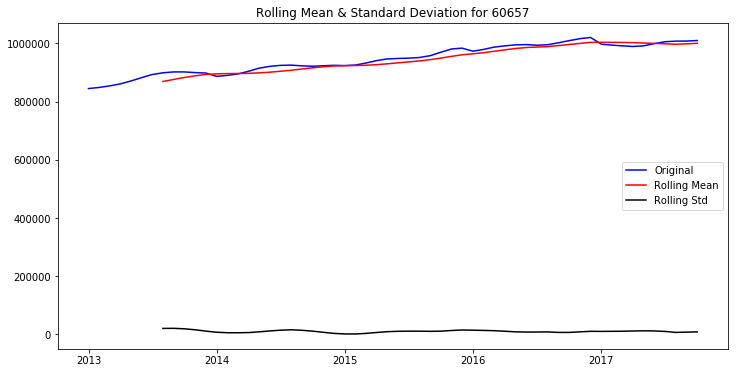

Results of Dickey-Fuller Test:
Test Statistic                 -1.656682
p-value                         0.453558
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


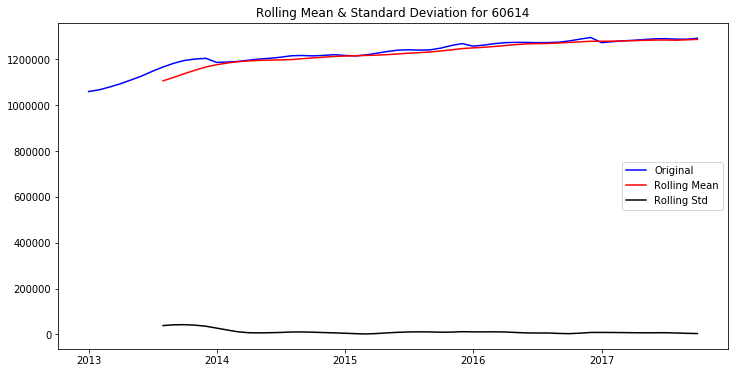

Results of Dickey-Fuller Test:
Test Statistic                 -2.449789
p-value                         0.128174
#Lags Used                      5.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


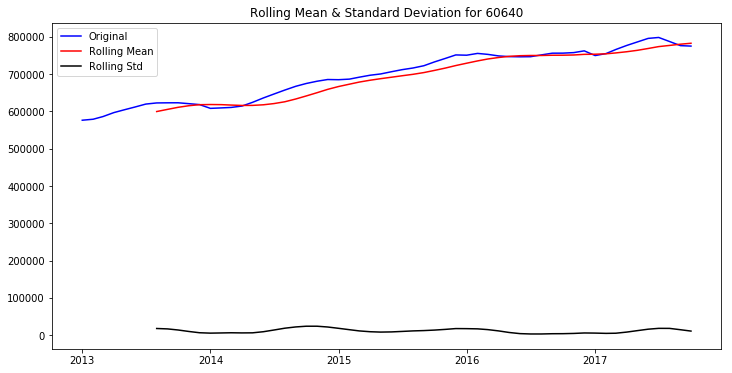

Results of Dickey-Fuller Test:
Test Statistic                 -1.083228
p-value                         0.721714
#Lags Used                      9.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


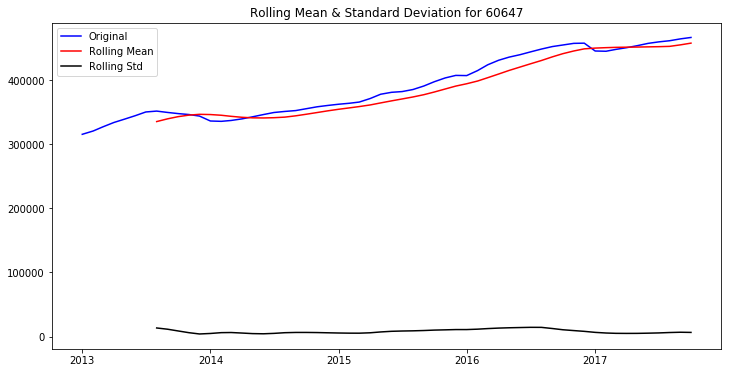

Results of Dickey-Fuller Test:
Test Statistic                 -0.319653
p-value                         0.922674
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


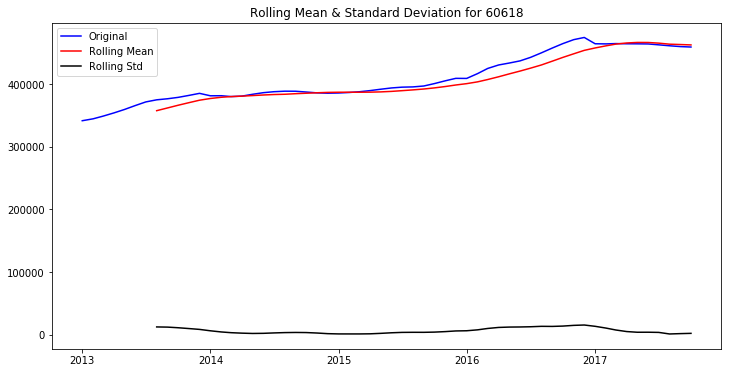

Results of Dickey-Fuller Test:
Test Statistic                 -1.188961
p-value                         0.678326
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


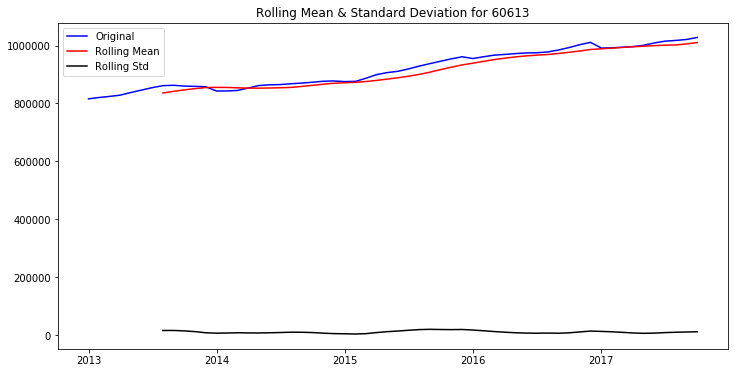

Results of Dickey-Fuller Test:
Test Statistic                 -0.167696
p-value                         0.942264
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


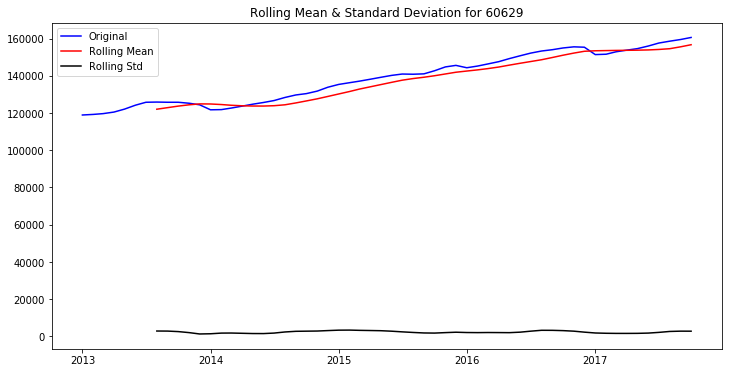

Results of Dickey-Fuller Test:
Test Statistic                 -0.274697
p-value                         0.929012
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


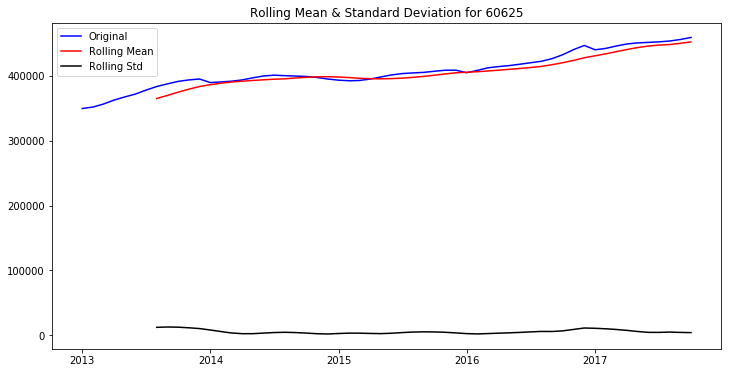

Results of Dickey-Fuller Test:
Test Statistic                 -0.903725
p-value                         0.786743
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


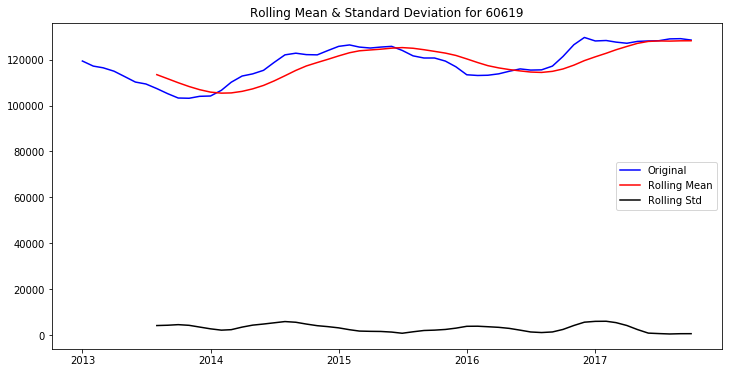

Results of Dickey-Fuller Test:
Test Statistic                 -2.629026
p-value                         0.087145
#Lags Used                      4.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


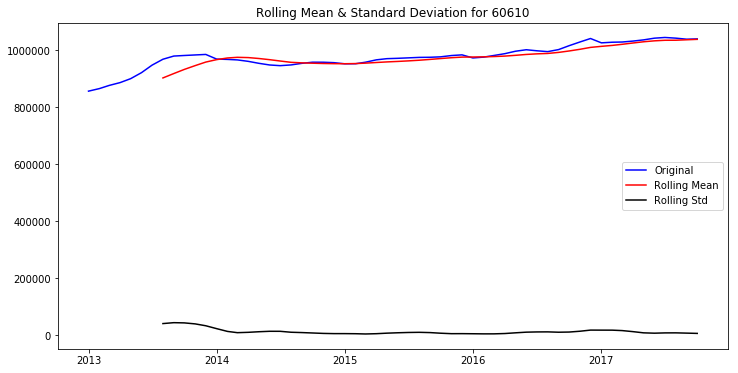

Results of Dickey-Fuller Test:
Test Statistic                  2.519066
p-value                         0.999056
#Lags Used                     11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


KeyError: 60611

In [29]:
[stationarity_check(zillow_chicago_train,x) for x in list(zillow_chicago.columns)]

Trend in the mean, variance is fairly close to zero and is constant. 

## Removing trend and seasonality

In [255]:
def detrend(TS, alpha=0.05, maxlag=4):
    
    '''Selecting the best method for detrending timeseries based on 
        lowest p-value of the augmented Dickey-Fuller.
        TS: timeseries dataframe
        alpha: alpha value for Dickey-Fuller '''
    
    new_TS = pd.DataFrame()
    
    plist = []
    for column in list(TS.columns):

        p_values = []
        if column==60611:
            pass
        else:

            decomposition=seasonal_decompose(TS[column].dropna())
            residuals = decomposition.resid
            dftest = adfuller(residuals.dropna(),maxlag=maxlag)
            dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput1['Critical Values (%s)' %key] = value
            p_values.append(dfoutput1[1])


            data_diff1 = TS[column].diff(periods=1)
            dftest = adfuller(data_diff1.dropna(),maxlag=maxlag)
            dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput2['Critical Values (%s)' %key] = value
            p_values.append(dfoutput2[1])

            data_diff2 = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            dftest = adfuller(data_diff2.dropna(),maxlag=maxlag)
            dfoutput3 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput3['Critical Values (%s)' %key] = value
            p_values.append(dfoutput3[1])


            temp_diff = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            data_diff3 = temp_diff - temp_diff.shift(12)  
            dftest = adfuller(data_diff3.dropna(),maxlag=maxlag)
            dfoutput4 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput4['Critical Values (%s)' %key] = value
            p_values.append(dfoutput4[1])

            if np.argmin(p_values)==0:
                residuals.plot(figsize=(20,6))
                plt.title('{} Seasonal Decomposition'.format(column))
                plt.show();
                print(dfoutput1)
                new_TS[column]=residuals

            elif np.argmin(p_values)==1:
                data_diff1.plot(figsize=(20,6))
                plt.title('{} First Difference'.format(column))
                plt.show();
                print(dfoutput2)
                new_TS[column]=data_diff1

            elif np.argmin(p_values)==2:
                data_diff2.plot(figsize=(20,6))
                plt.title('{} Log First Difference'.format(column))
                plt.show();
                print(dfoutput3)
                new_TS[column]=data_diff2

            elif np.argmin(p_values)==3:
                data_diff3.plot(figsize=(20,6))
                plt.title('{} Log Seasonal First Difference'.format(column))
                plt.show();
                print(dfoutput4)
                new_TS[column]=data_diff3

            plist.append(min(p_values))
    print('\n','The p-value above {}:'.format(alpha),(np.array(plist)>alpha).sum())
    return new_TS
  
    

In [246]:
def detrend_test(TS, alpha=0.05, maxlag=4):
    
    '''Selecting the best method for detrending timeseries based on 
        lowest p-value of the augmented Dickey-Fuller.
        TS: timeseries dataframe
        alpha: alpha value for Dickey-Fuller '''
    
    new_TS = pd.DataFrame()
    
    plist = []
    for column in list(TS.columns):

        p_values = []
        if column==60611:
            pass
        else:

            data_diff1 = TS[column].diff(periods=1)
            dftest = adfuller(data_diff1.dropna(),maxlag=maxlag)
            dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput2['Critical Values (%s)' %key] = value
            p_values.append(dfoutput2[1])

            data_diff2 = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            dftest = adfuller(data_diff2.dropna(),maxlag=maxlag)
            dfoutput3 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput3['Critical Values (%s)' %key] = value
            p_values.append(dfoutput3[1])

            if np.argmin(p_values)==0:
                data_diff1.plot(figsize=(20,6))
                plt.title('{} First Difference'.format(column))
                plt.show();
                print(dfoutput2)
                new_TS[column]=data_diff1

            elif np.argmin(p_values)==1:
                data_diff2.plot(figsize=(20,6))
                plt.title('{} Log First Difference'.format(column))
                plt.show();
                print(dfoutput3)
                new_TS[column]=data_diff2

            plist.append(min(p_values))
    print('\n','The p-value above {}:'.format(alpha),(np.array(plist)>alpha).sum())
    return new_TS
  



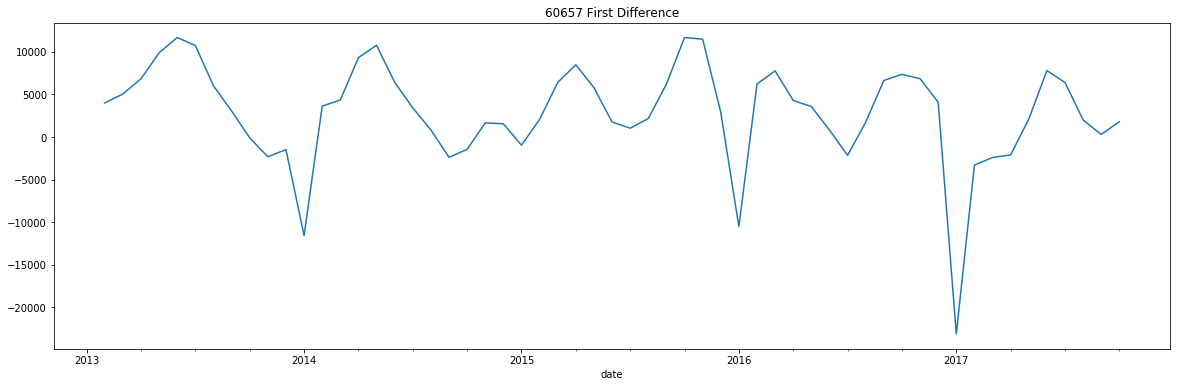

Test Statistic                 -4.825667
p-value                         0.000049
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


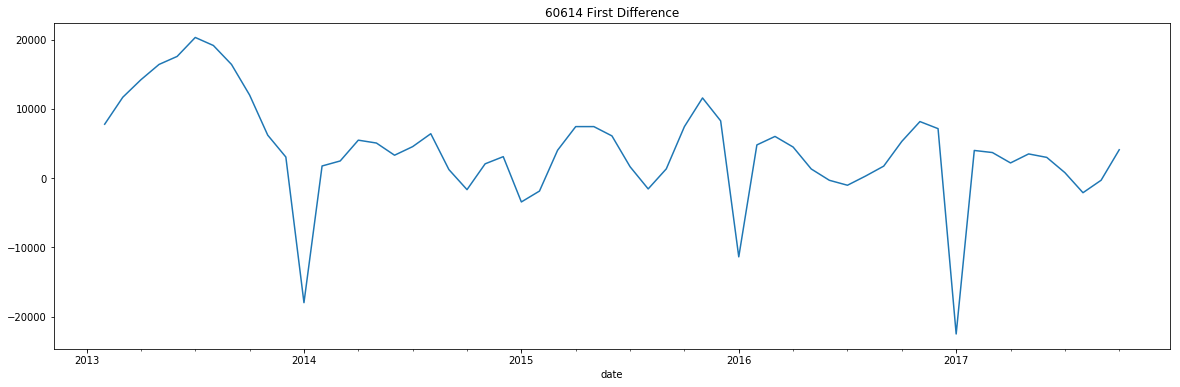

Test Statistic                 -4.604443
p-value                         0.000127
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


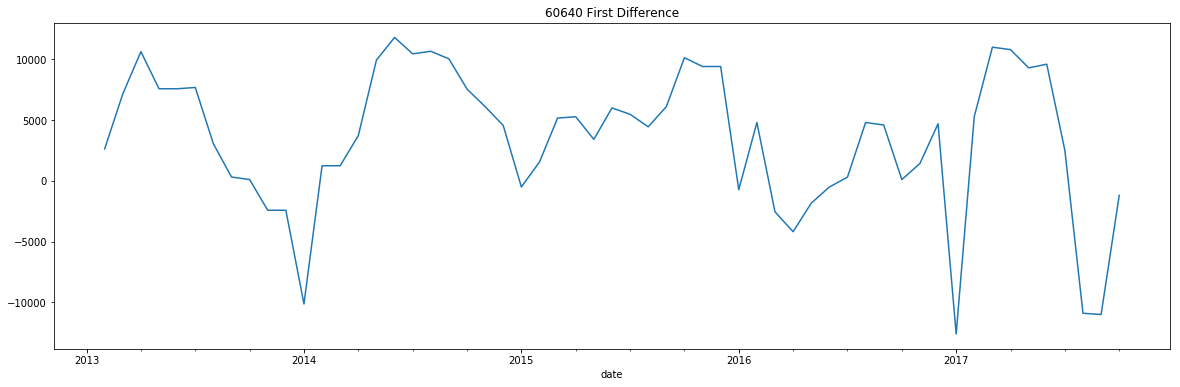

Test Statistic                 -4.581580
p-value                         0.000140
#Lags Used                      4.000000
Number of Observations Used    52.000000
Critical Values (1%)           -3.562879
Critical Values (5%)           -2.918973
Critical Values (10%)          -2.597393
dtype: float64


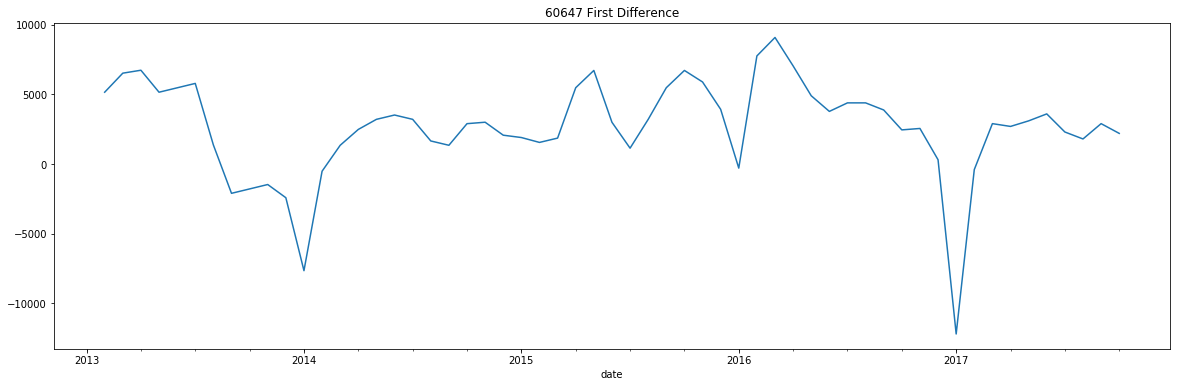

Test Statistic                 -3.892460
p-value                         0.002091
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


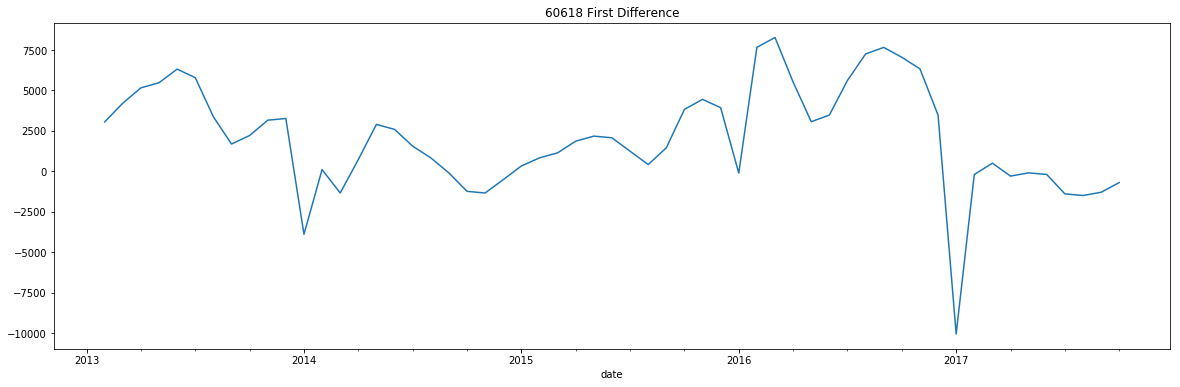

Test Statistic                 -3.749466
p-value                         0.003469
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


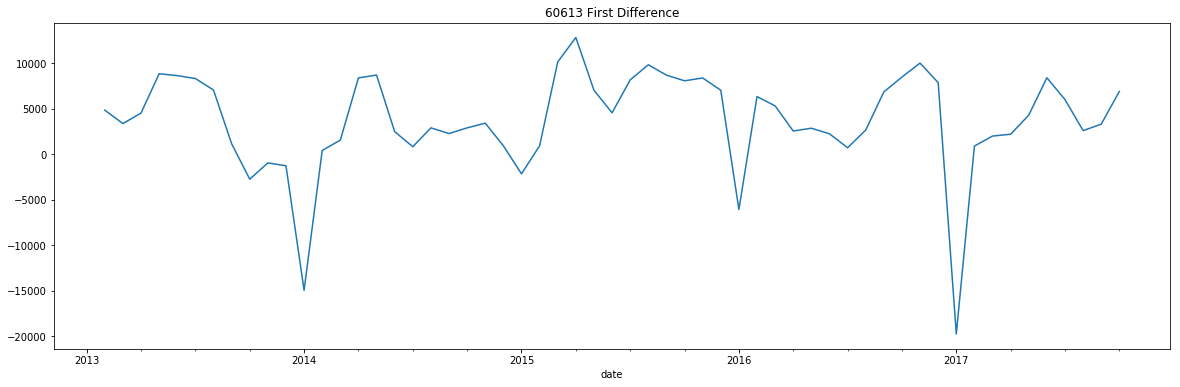

Test Statistic                 -5.304533
p-value                         0.000005
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


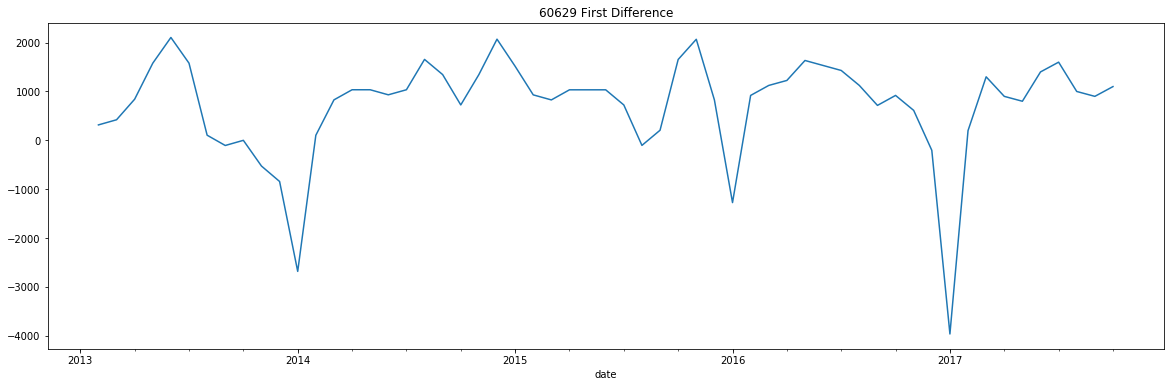

Test Statistic                 -4.518347
p-value                         0.000182
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


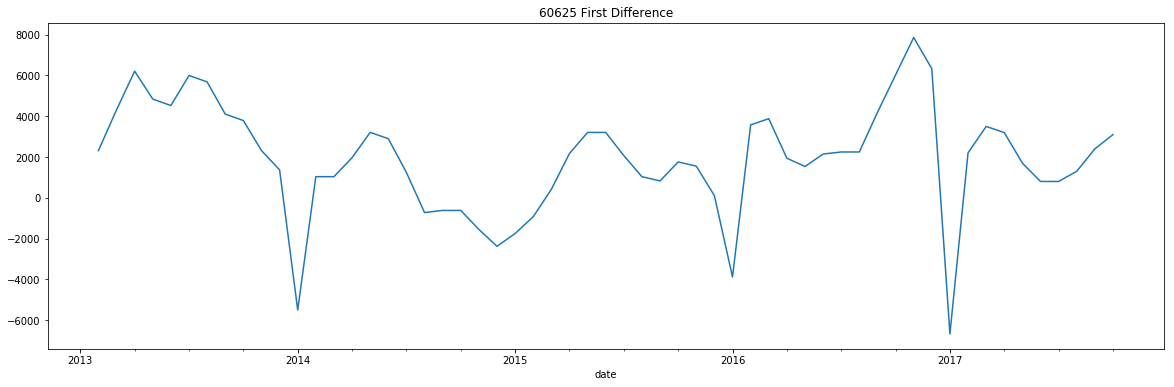

Test Statistic                 -4.586233
p-value                         0.000137
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


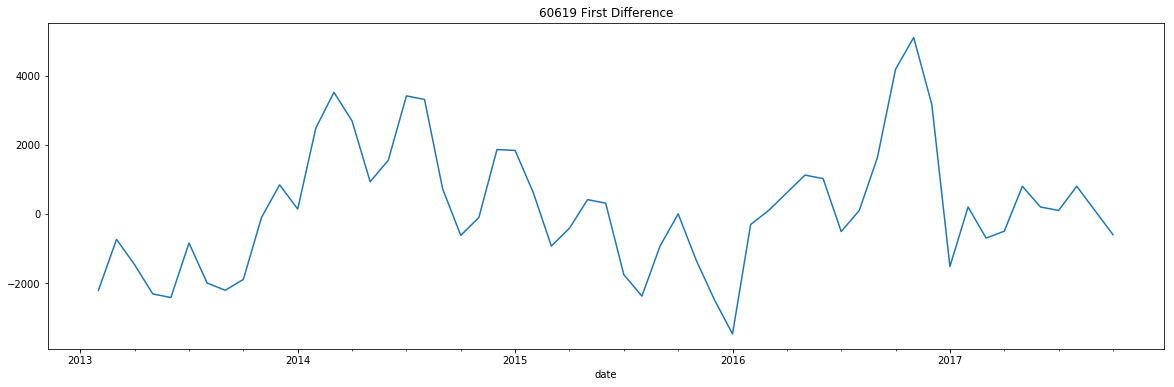

Test Statistic                 -2.787158
p-value                         0.060132
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Values (1%)           -3.557709
Critical Values (5%)           -2.916770
Critical Values (10%)          -2.596222
dtype: float64


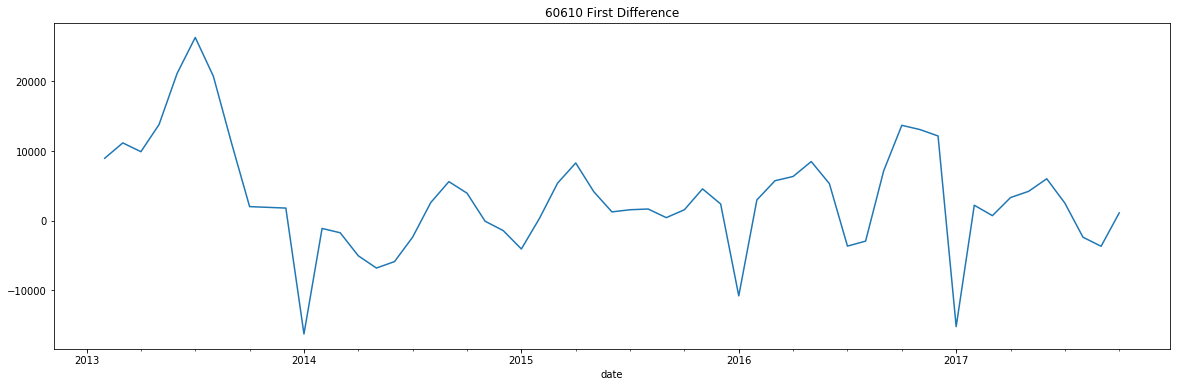

Test Statistic                 -3.774431
p-value                         0.003180
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


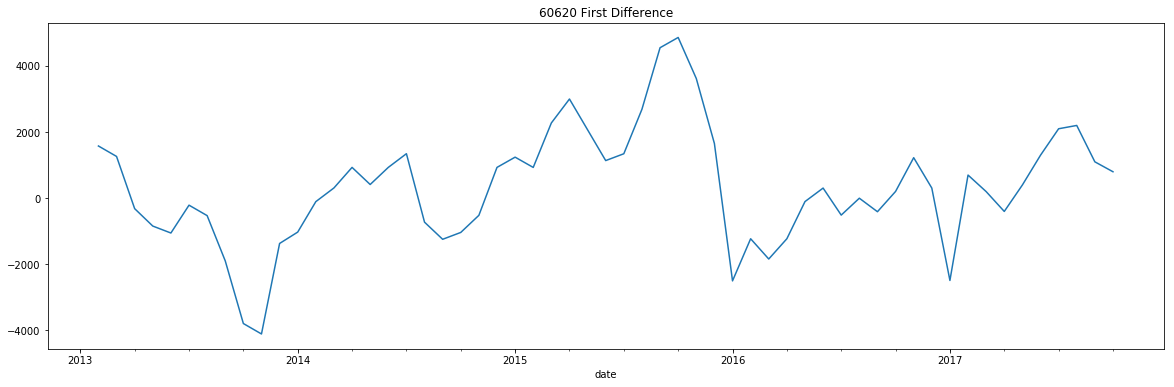

Test Statistic                 -3.337688
p-value                         0.013276
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


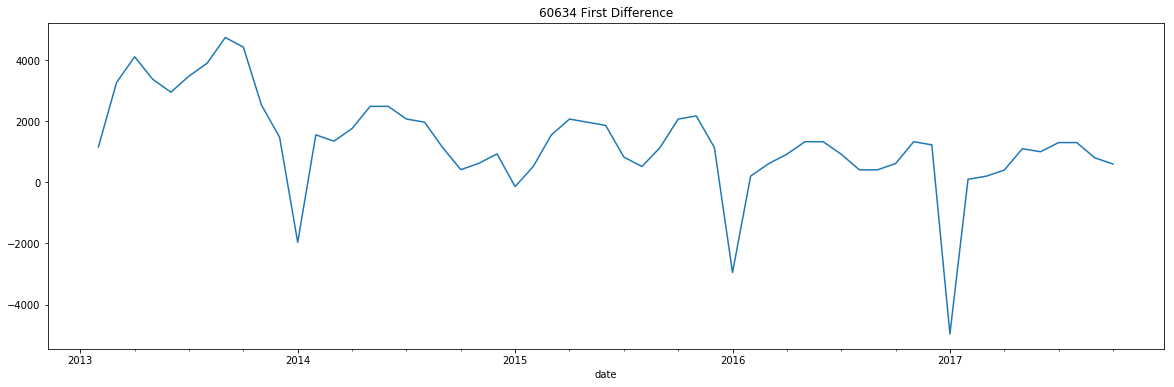

Test Statistic                 -4.155326
p-value                         0.000784
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


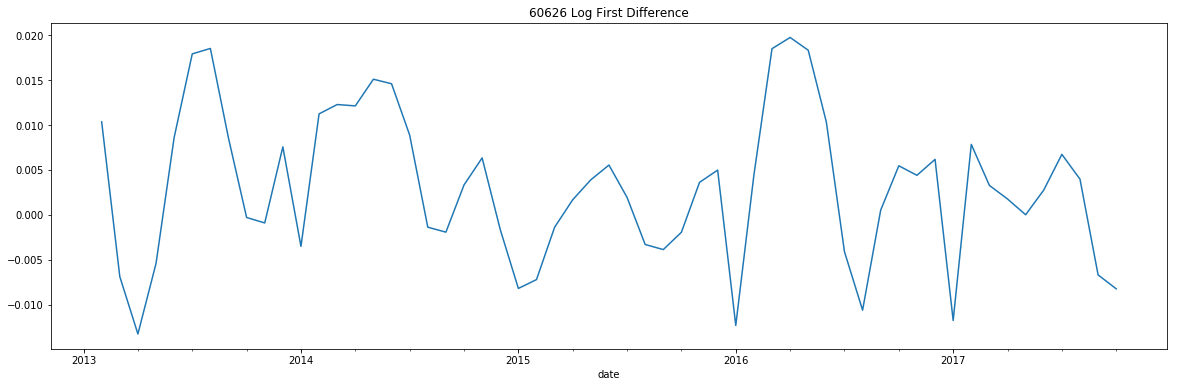

Test Statistic                 -4.961524
p-value                         0.000026
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


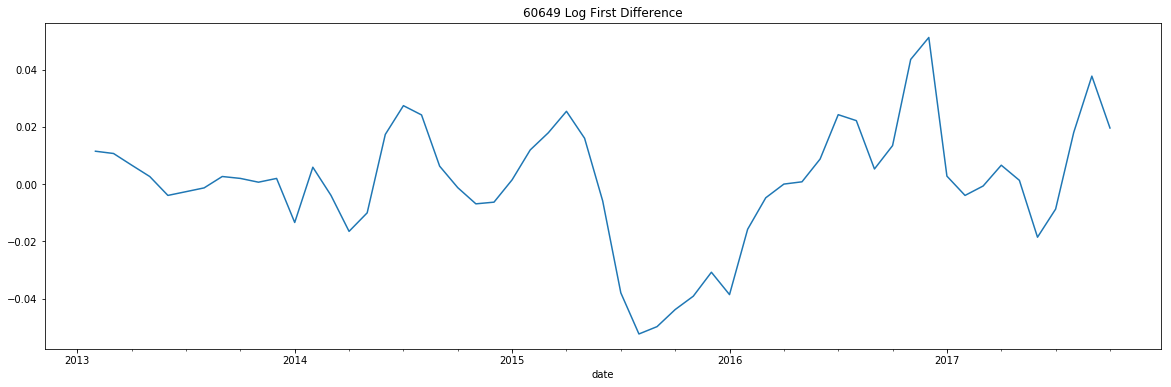

Test Statistic                 -2.848996
p-value                         0.051609
#Lags Used                      4.000000
Number of Observations Used    52.000000
Critical Values (1%)           -3.562879
Critical Values (5%)           -2.918973
Critical Values (10%)          -2.597393
dtype: float64


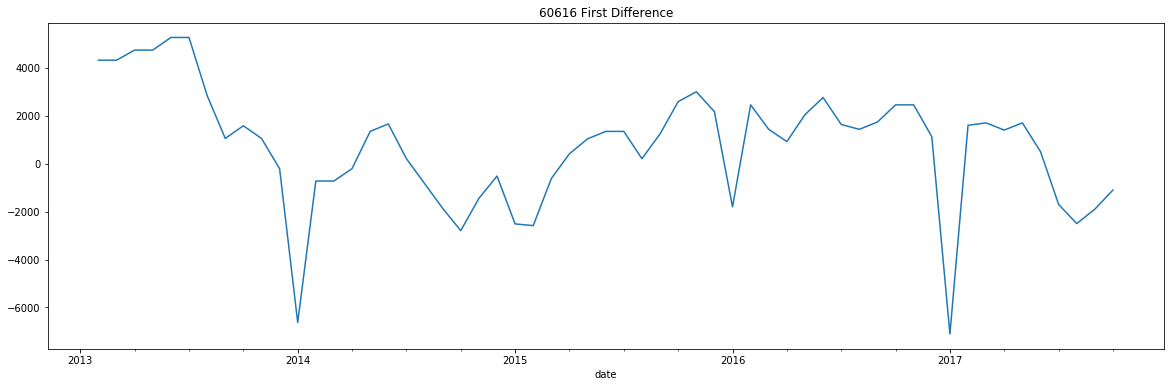

Test Statistic                 -4.101448
p-value                         0.000963
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


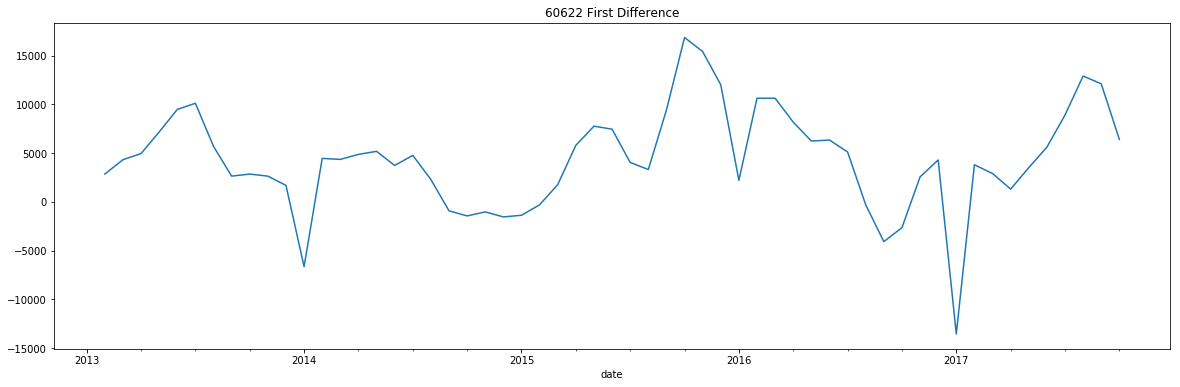

Test Statistic                 -3.901008
p-value                         0.002027
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


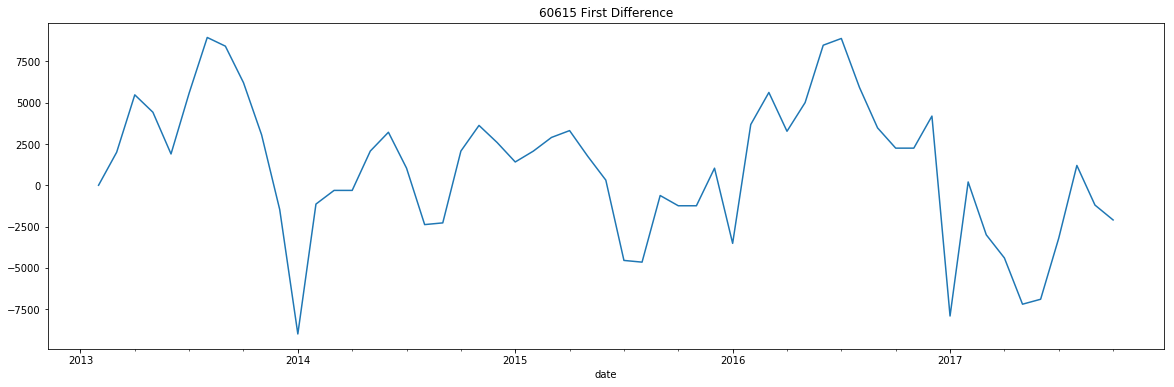

Test Statistic                 -3.401486
p-value                         0.010908
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


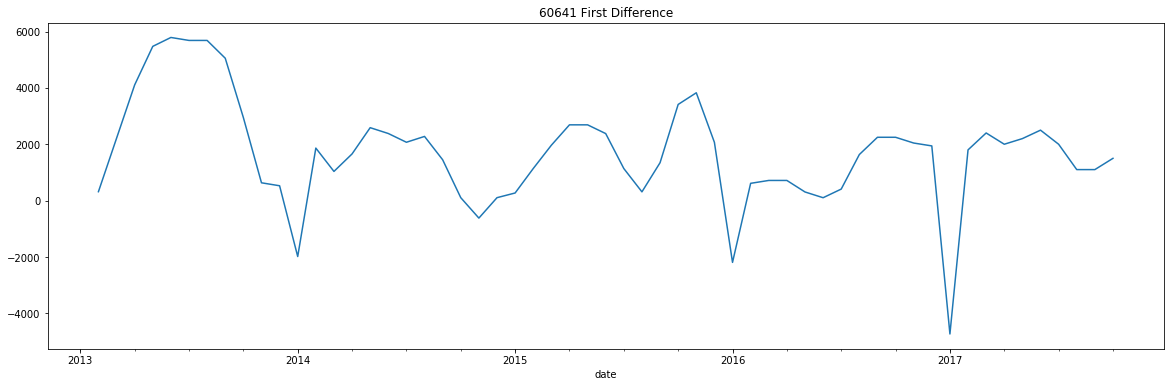

Test Statistic                 -4.015638
p-value                         0.001331
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


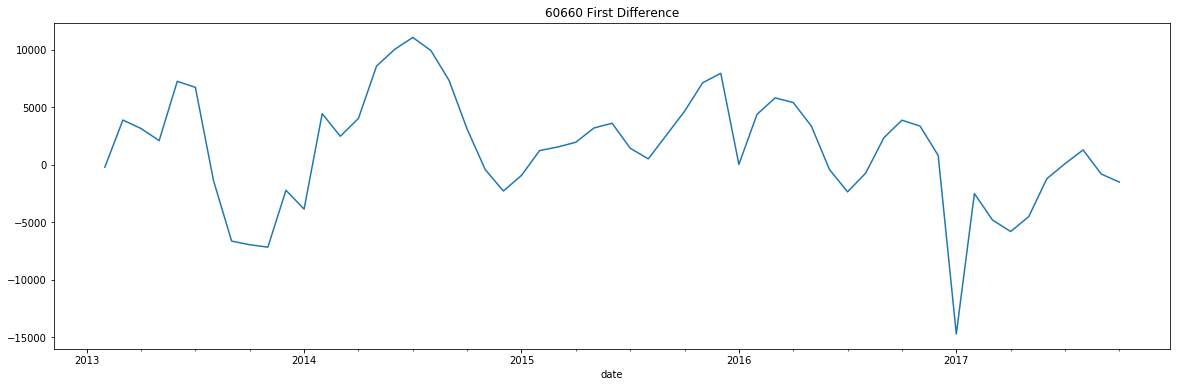

Test Statistic                 -3.298827
p-value                         0.014931
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


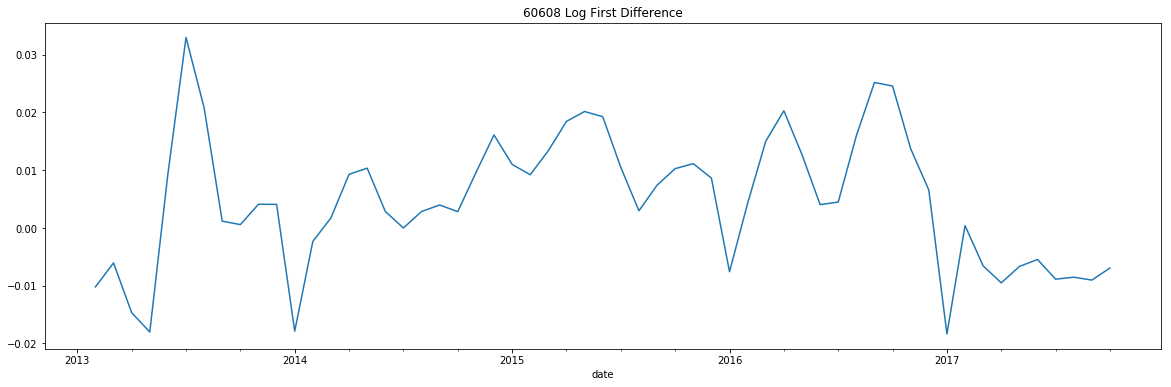

Test Statistic                 -4.096827
p-value                         0.000980
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


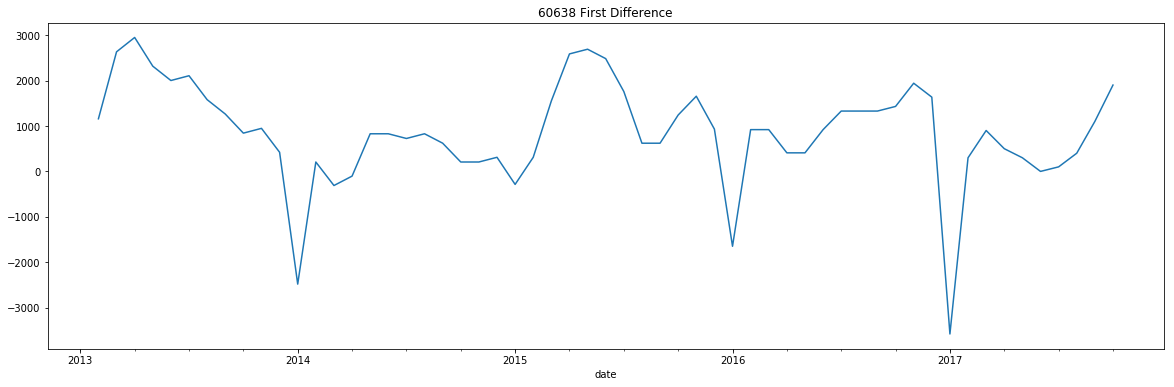

Test Statistic                 -4.653187
p-value                         0.000103
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


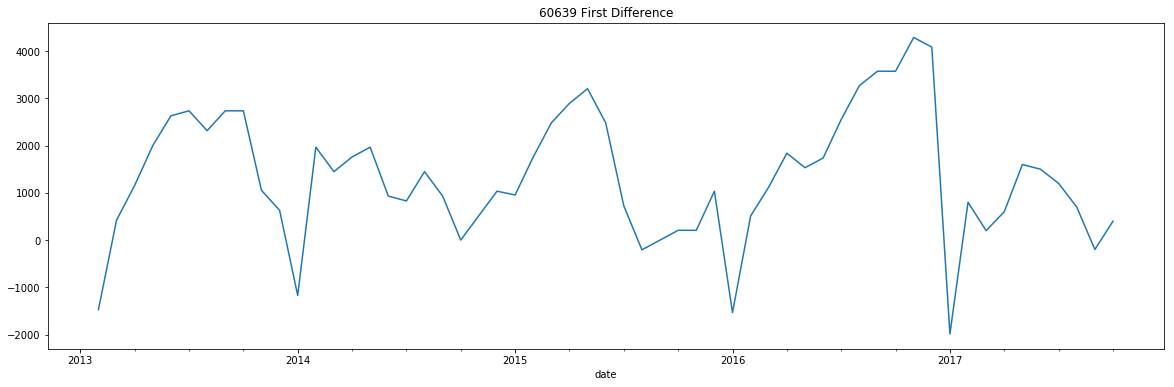

Test Statistic                 -4.416023
p-value                         0.000278
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


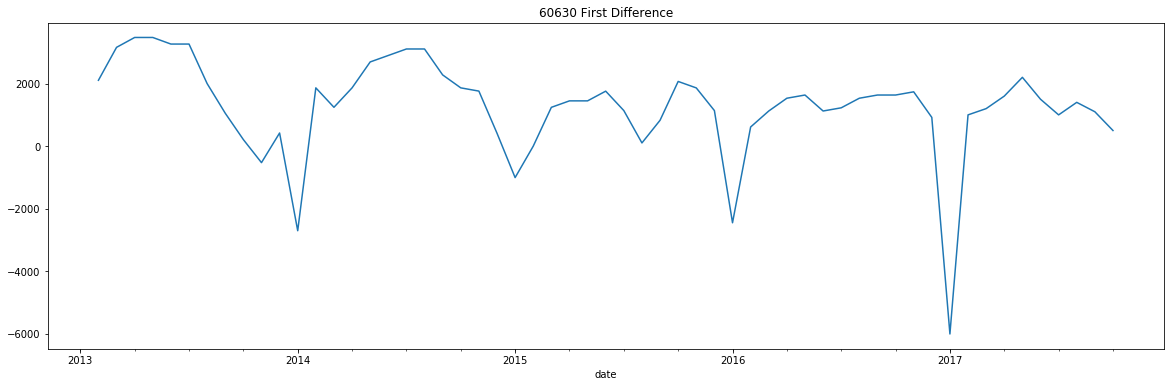

Test Statistic                 -4.982200
p-value                         0.000024
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


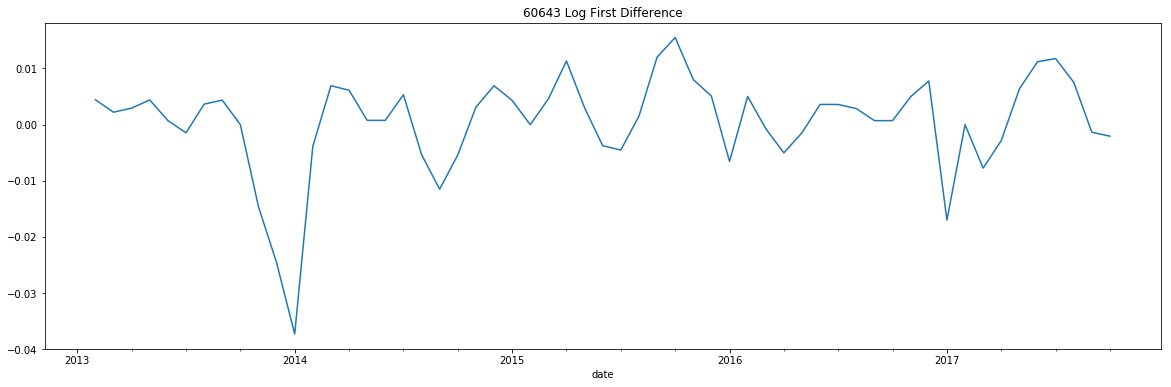

Test Statistic                 -4.547187
p-value                         0.000161
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


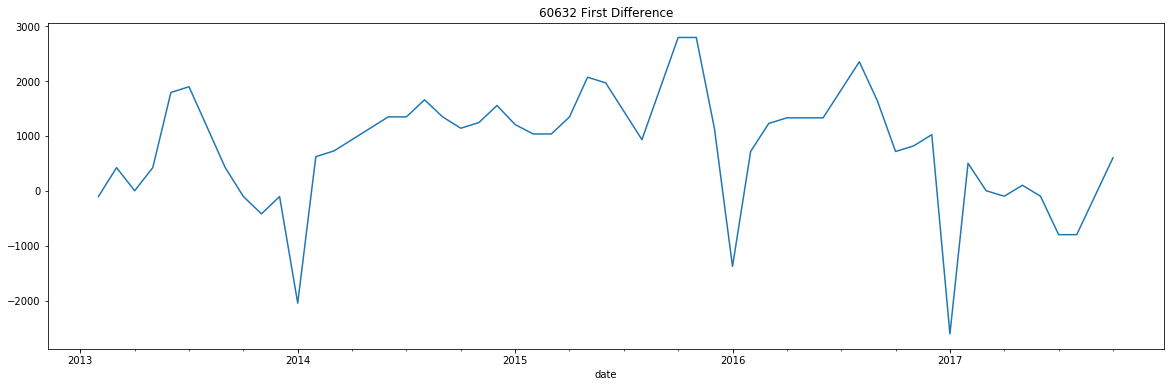

Test Statistic                 -4.185347
p-value                         0.000698
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


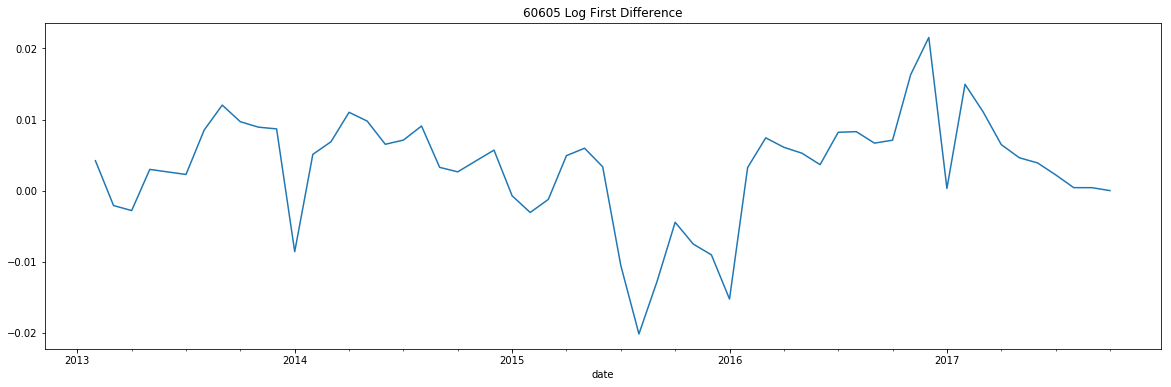

Test Statistic                 -3.567568
p-value                         0.006412
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


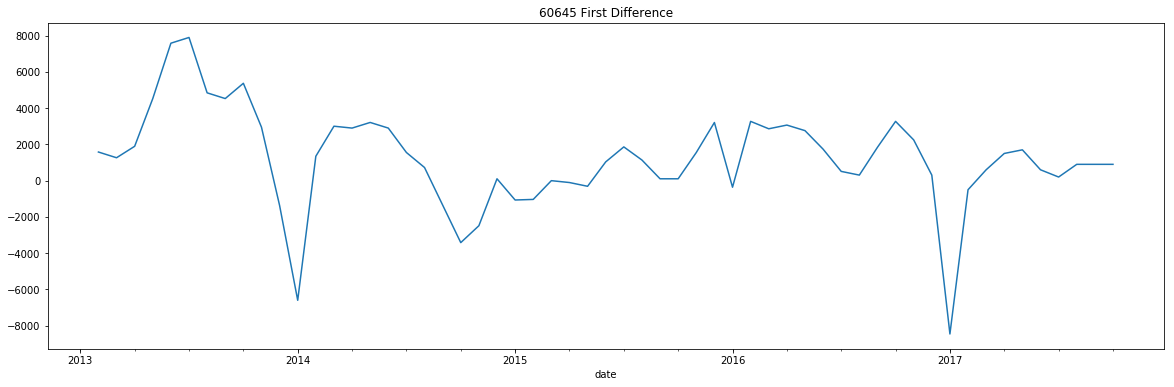

Test Statistic                 -3.876678
p-value                         0.002213
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


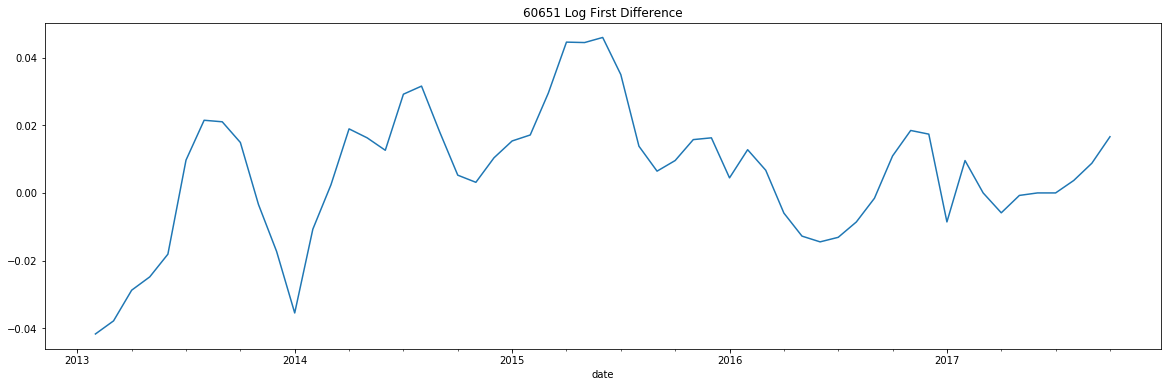

Test Statistic                 -3.758499
p-value                         0.003362
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


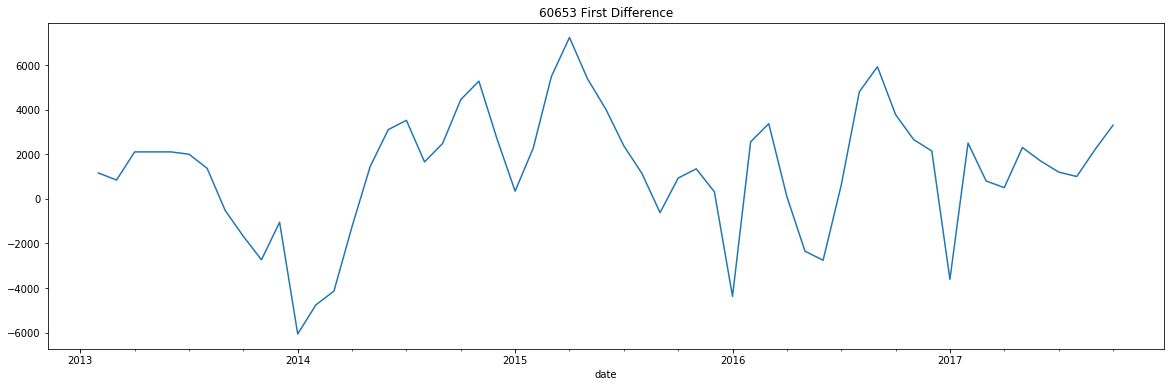

Test Statistic                 -3.440014
p-value                         0.009668
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


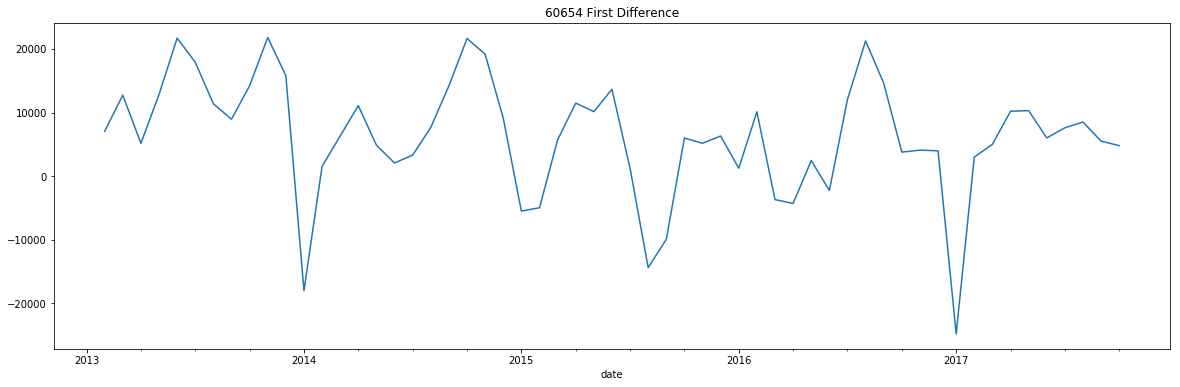

Test Statistic                 -4.982211
p-value                         0.000024
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


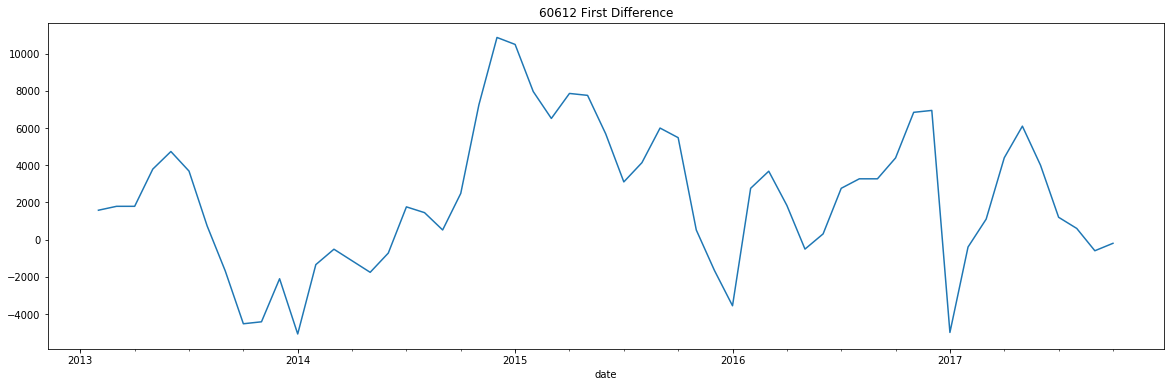

Test Statistic                 -3.222260
p-value                         0.018732
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


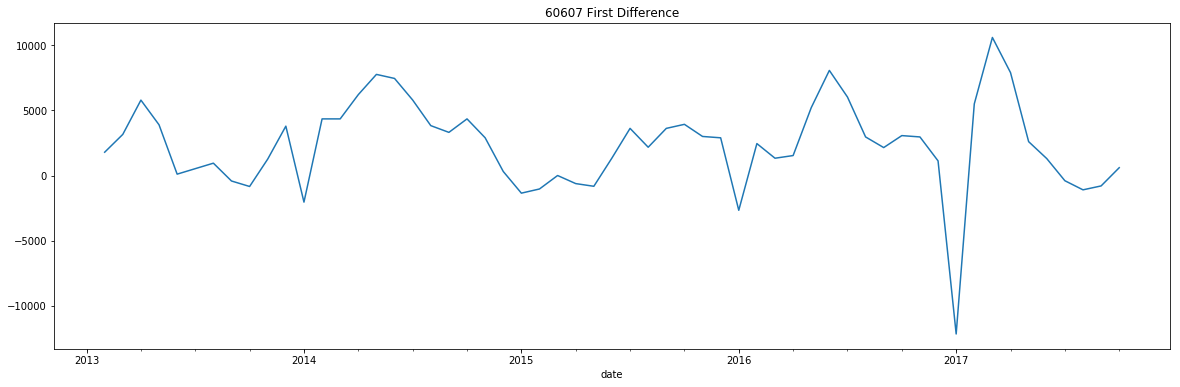

Test Statistic                 -4.883302
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


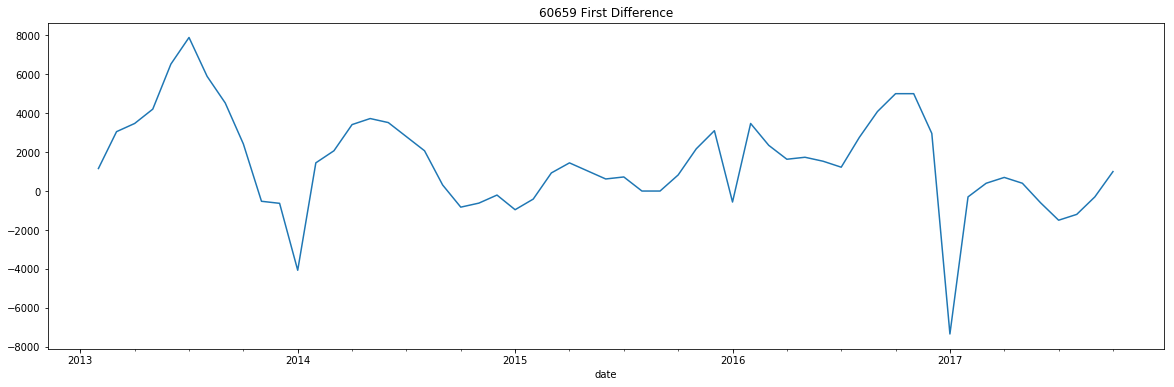

Test Statistic                 -3.750875
p-value                         0.003452
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


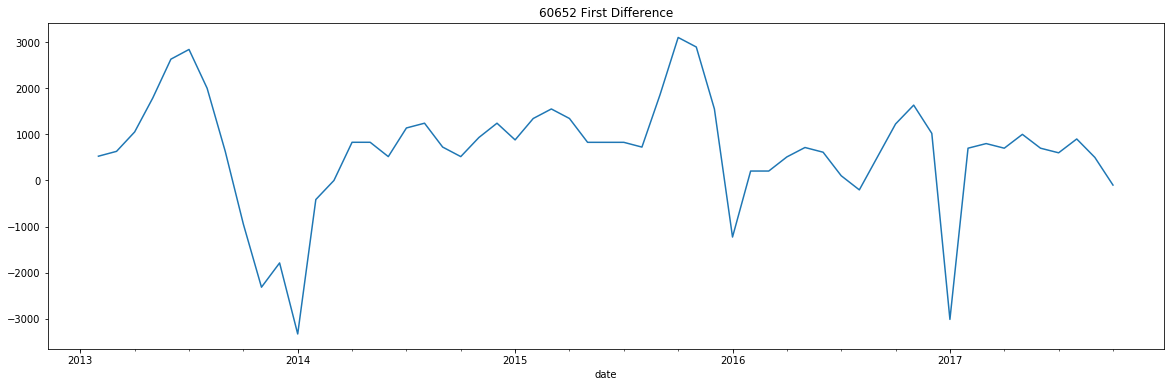

Test Statistic                 -3.742025
p-value                         0.003559
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


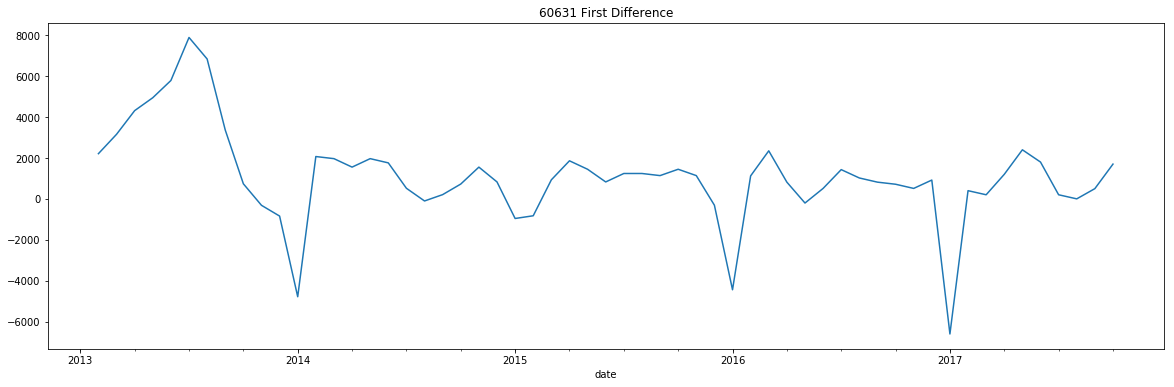

Test Statistic                 -4.055977
p-value                         0.001144
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


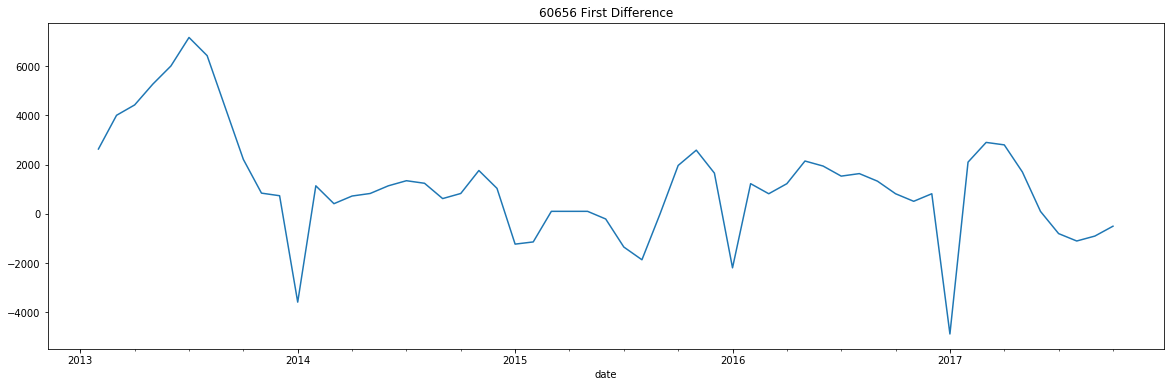

Test Statistic                 -3.412883
p-value                         0.010527
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


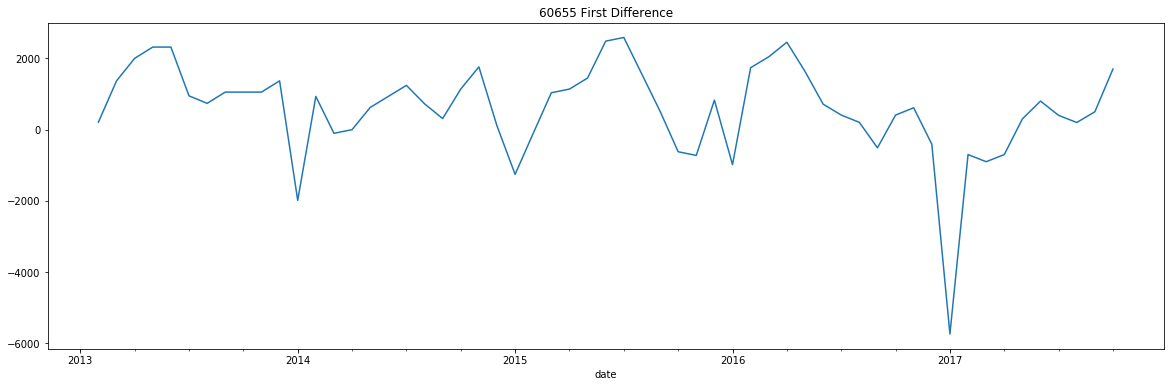

Test Statistic                 -4.681139
p-value                         0.000091
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


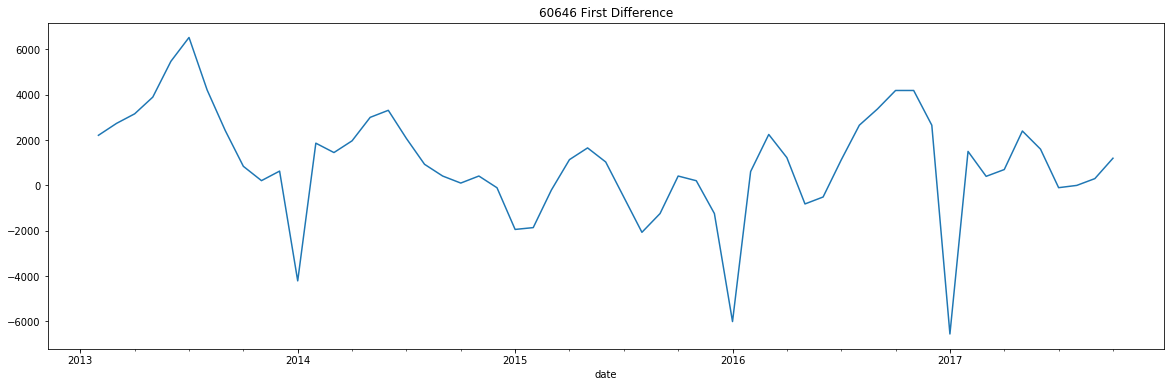

Test Statistic                 -4.508007
p-value                         0.000190
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


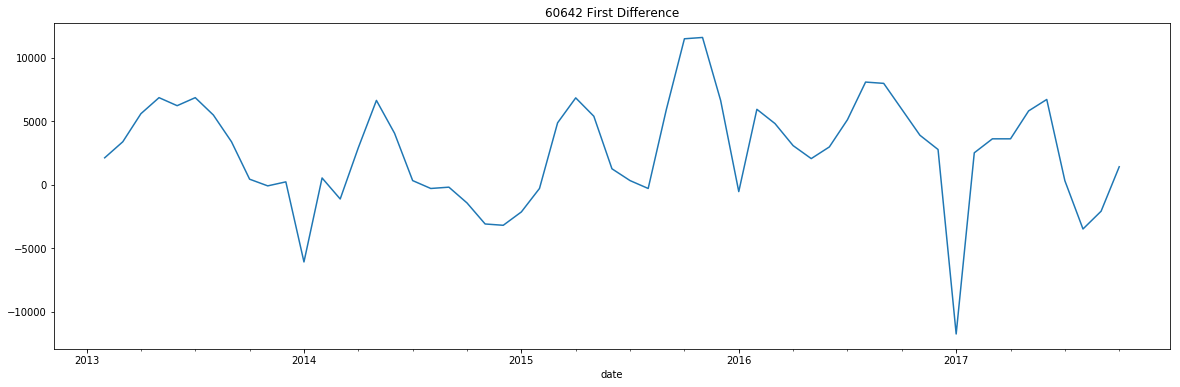

Test Statistic                 -4.117299
p-value                         0.000907
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


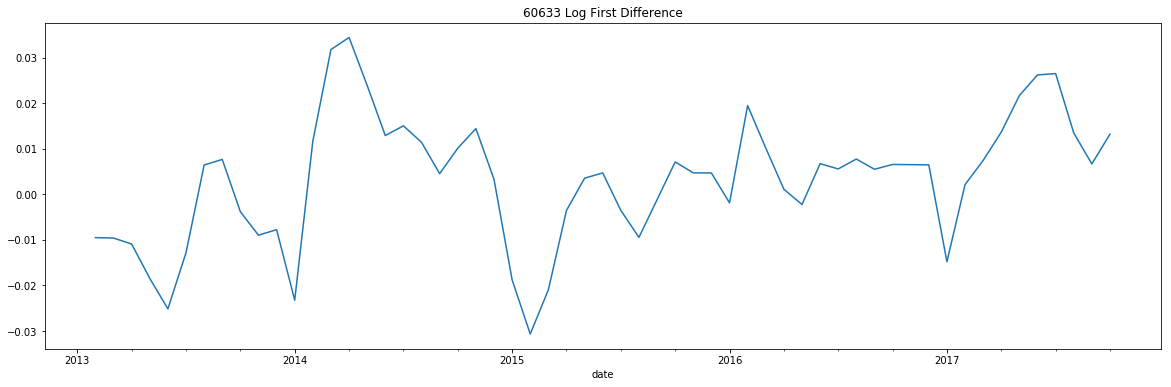

Test Statistic                 -3.942979
p-value                         0.001740
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64

 The p-value above 0.05: 2


In [258]:
zc_train_dt = detrend_test(zillow_chicago_train,0.05)

In [57]:
drop_list = [60619, 60649]
zc_train_dt.drop(drop_list, axis=1, inplace=True)

In [260]:
log_diff_list = [60626, 60605, 60608, 60651, 60643, 60633]
zc_train_fd = zillow_chicago_train.drop(log_diff_list, axis=1)
zc_test_fd = zillow_chicago_test.drop(log_diff_list, axis=1)

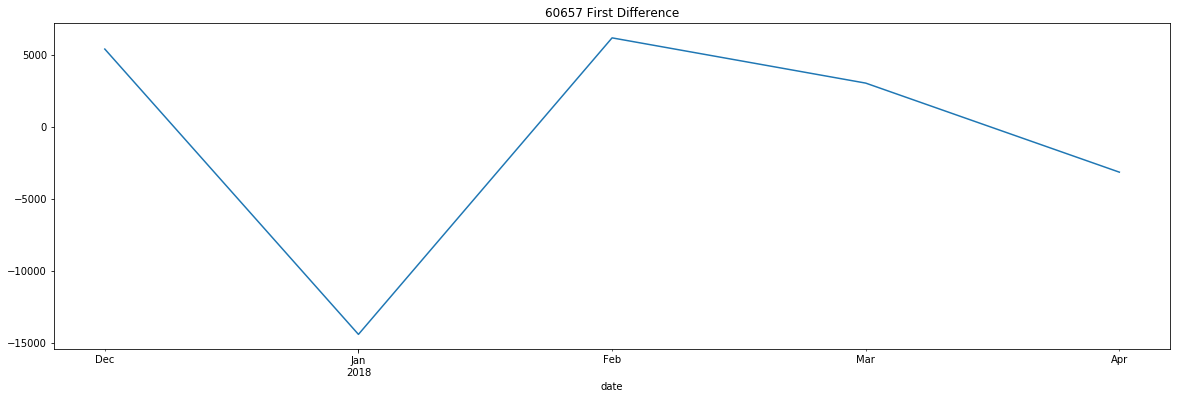

Test Statistic                -2.922198
p-value                        0.042827
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


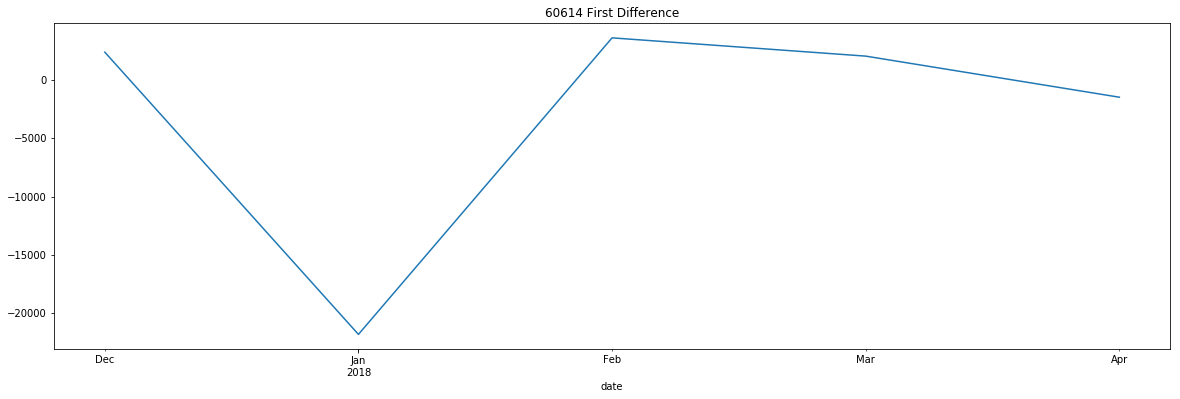

Test Statistic                -2.305512
p-value                        0.170196
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


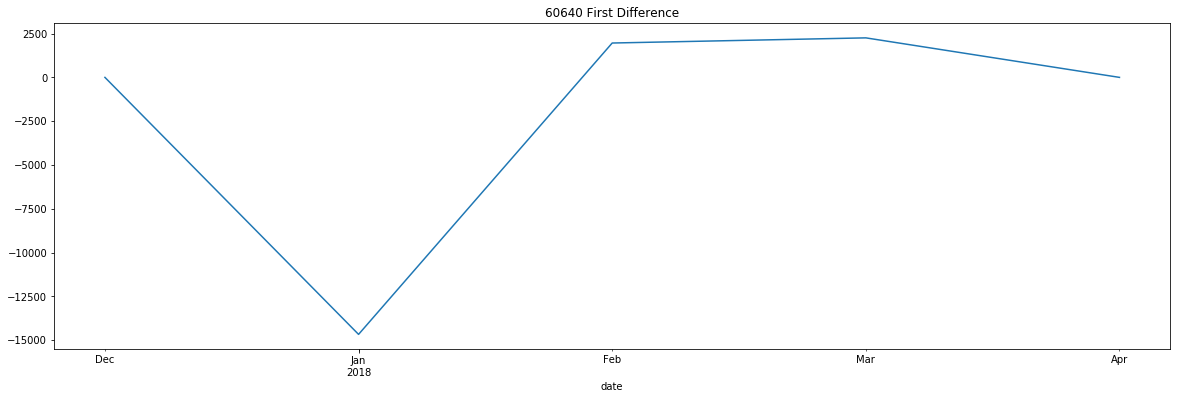

Test Statistic                -1.850312
p-value                        0.355784
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


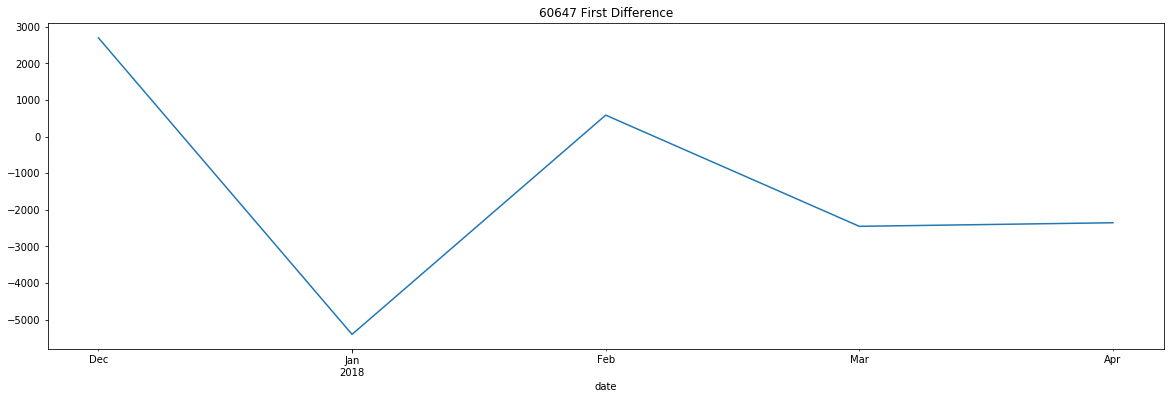

Test Statistic                -9.865718e+00
p-value                        4.119338e-17
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values (1%)          -7.355441e+00
Critical Values (5%)          -4.474365e+00
Critical Values (10%)         -3.126933e+00
dtype: float64


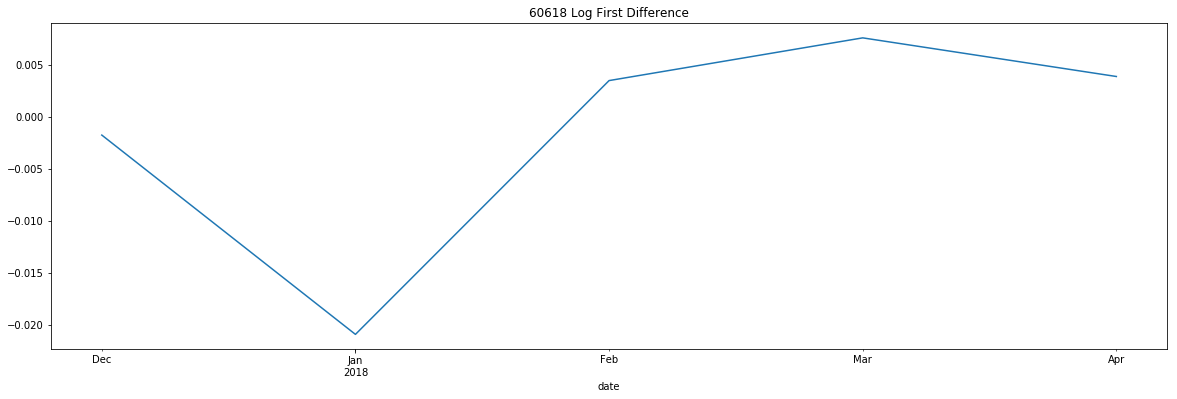

Test Statistic                -1.355802
p-value                        0.603272
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


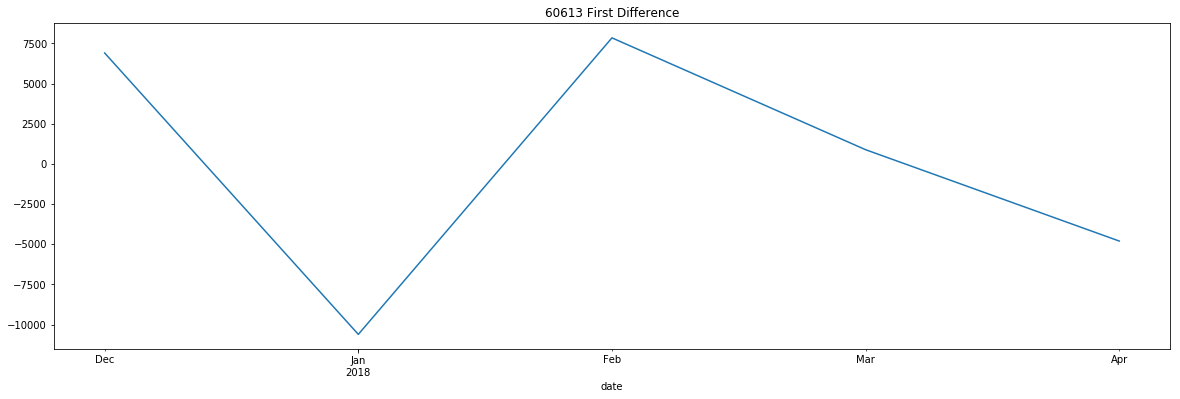

Test Statistic                -3.685630
p-value                        0.004320
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


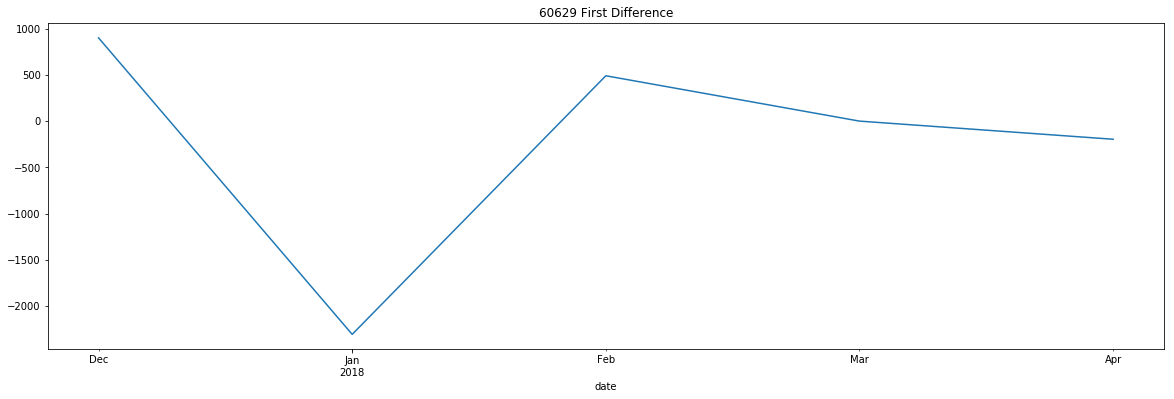

Test Statistic                -3.612980
p-value                        0.005518
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


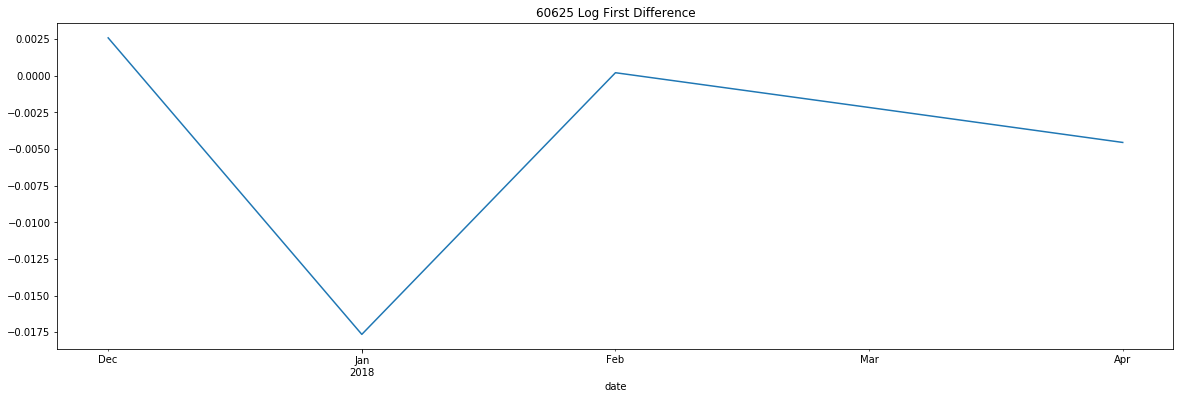

Test Statistic                -3.353329
p-value                        0.012657
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


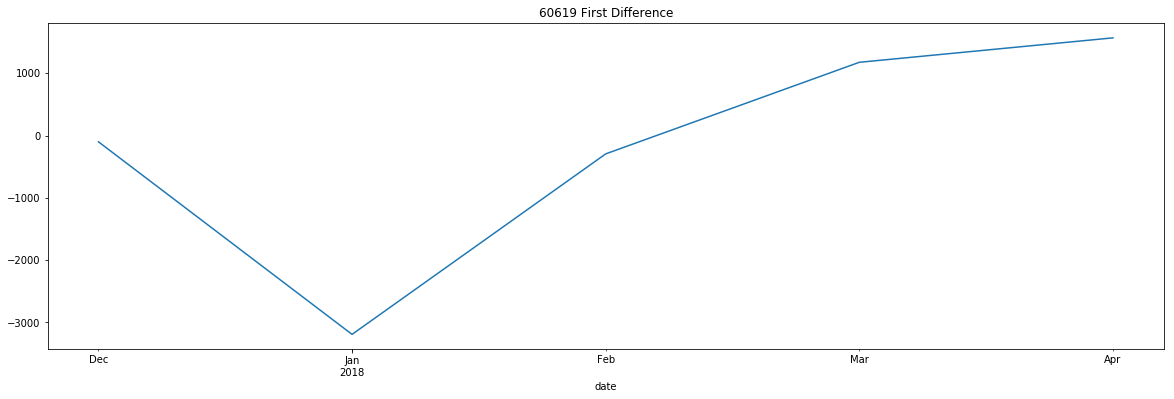

Test Statistic                -0.953514
p-value                        0.769839
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


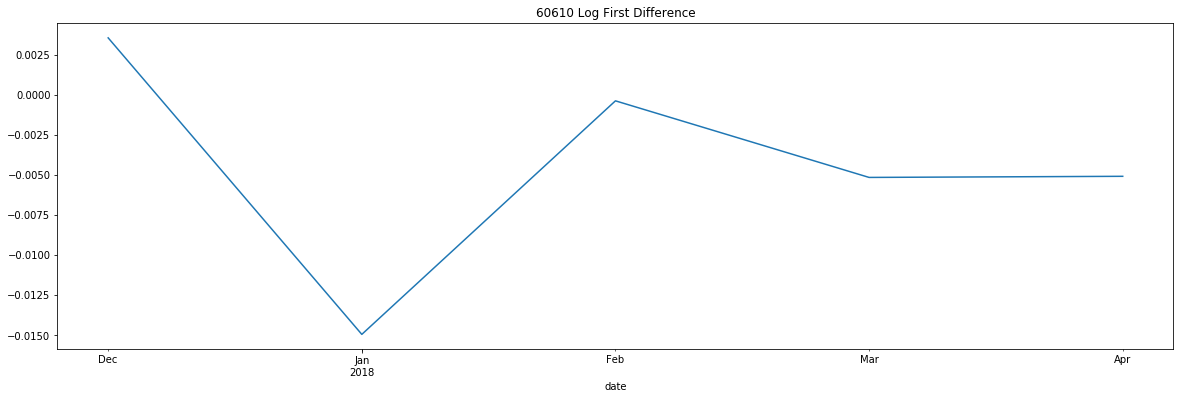

Test Statistic                -6.206593e+00
p-value                        5.638240e-08
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values (1%)          -7.355441e+00
Critical Values (5%)          -4.474365e+00
Critical Values (10%)         -3.126933e+00
dtype: float64


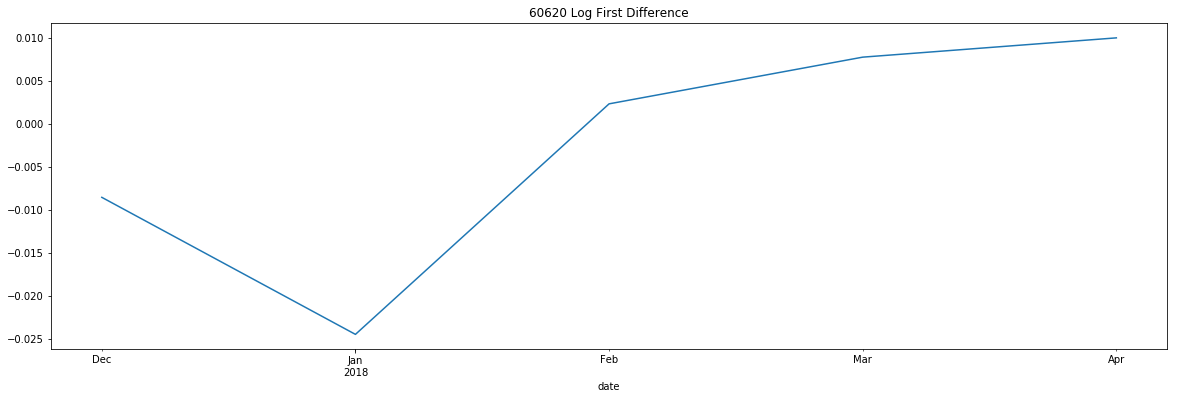

Test Statistic                -0.846167
p-value                        0.805183
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


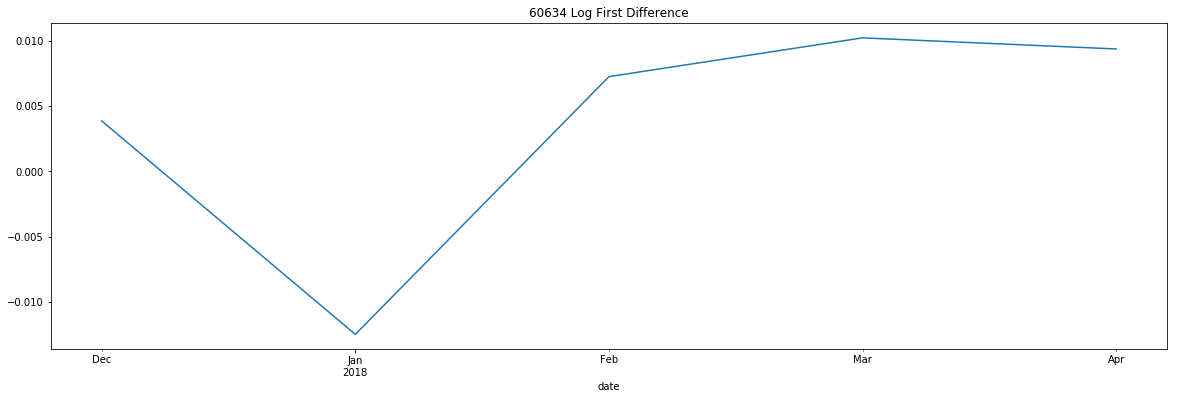

Test Statistic                -1.331498
p-value                        0.614642
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


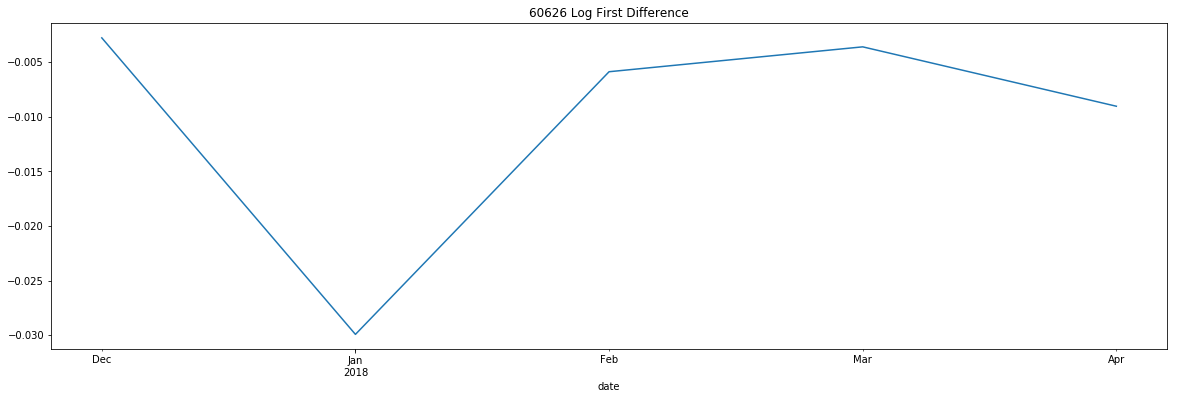

Test Statistic                -2.331284
p-value                        0.162077
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


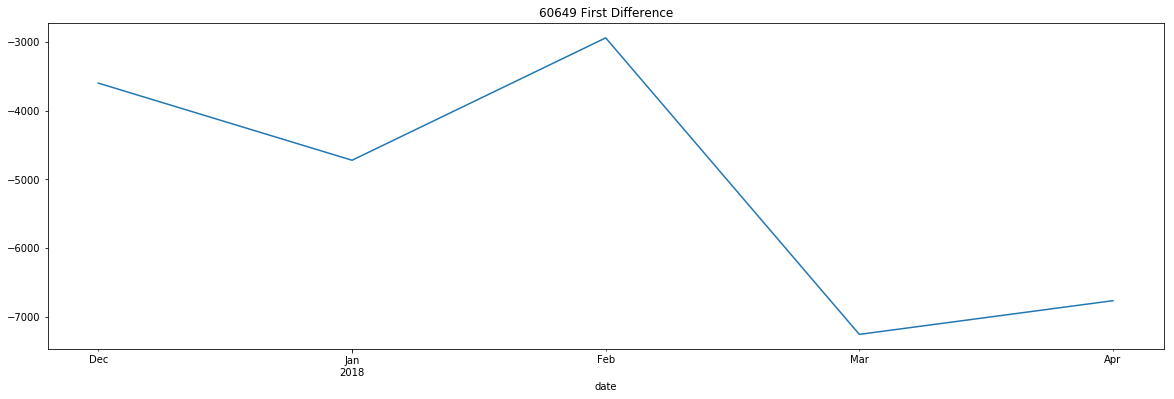

Test Statistic                -1.241842
p-value                        0.655343
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


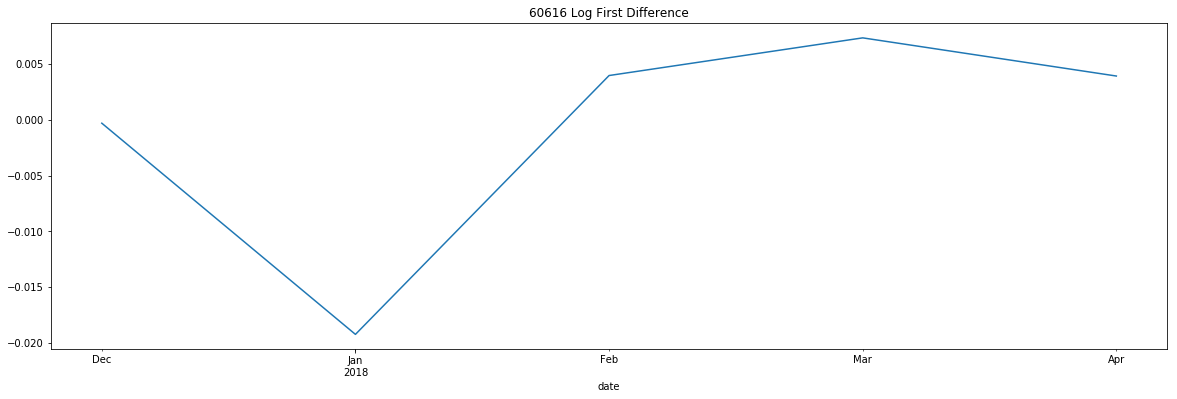

Test Statistic                -1.438012
p-value                        0.563923
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


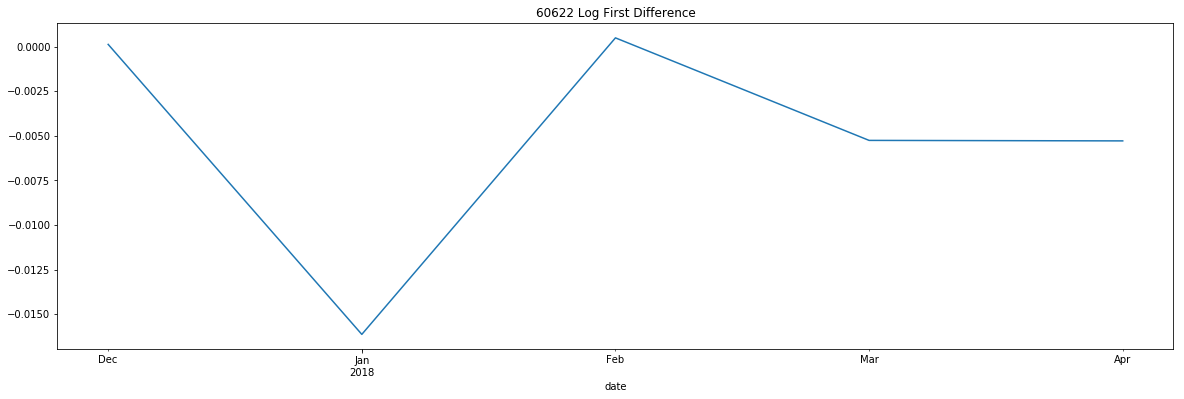

Test Statistic                -3.968239
p-value                        0.001586
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


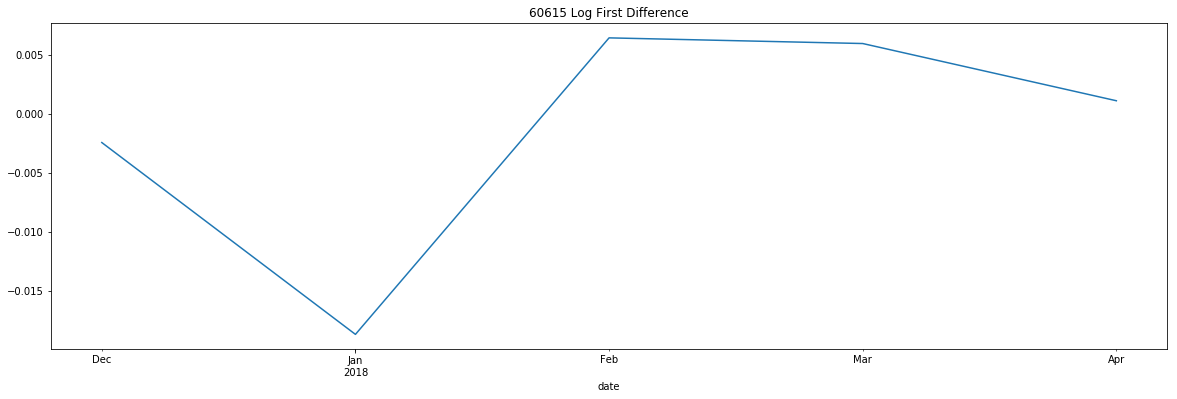

Test Statistic                -1.548651
p-value                        0.509322
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


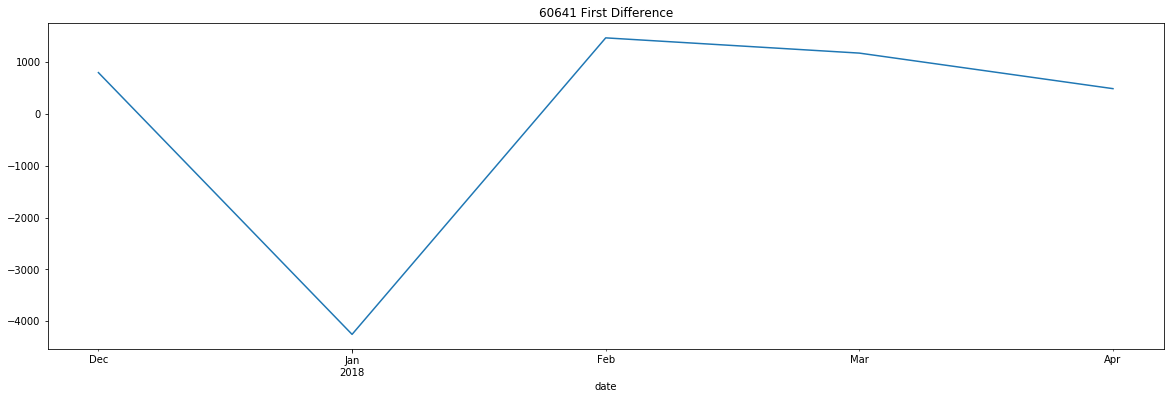

Test Statistic                -2.049956
p-value                        0.265108
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


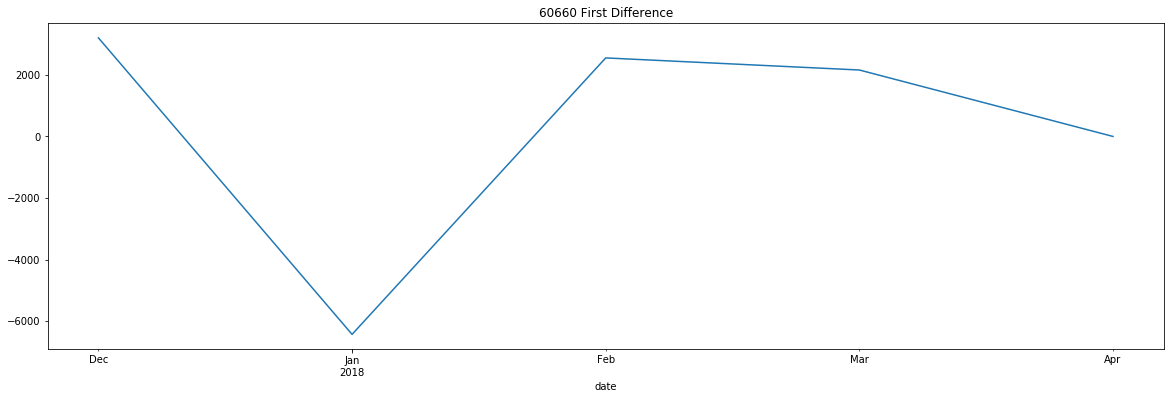

Test Statistic                -2.762883
p-value                        0.063774
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


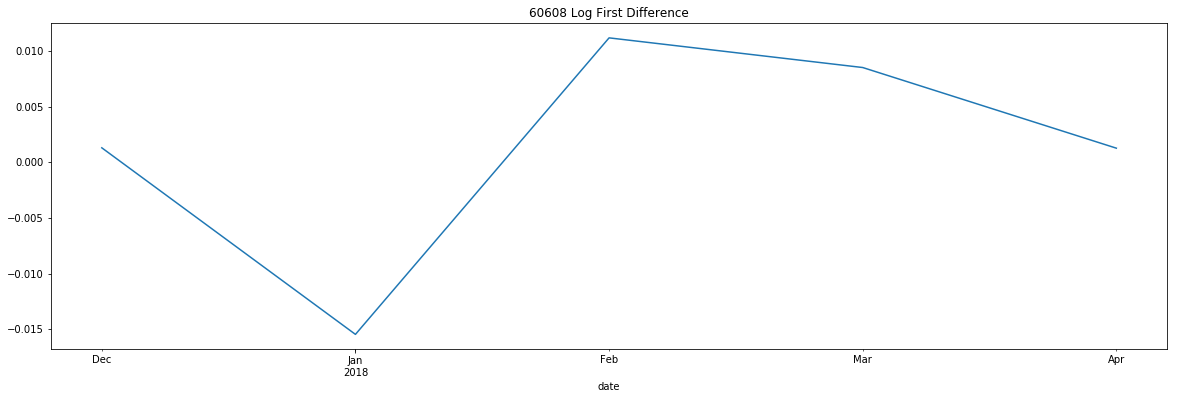

Test Statistic                -1.768070
p-value                        0.396425
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


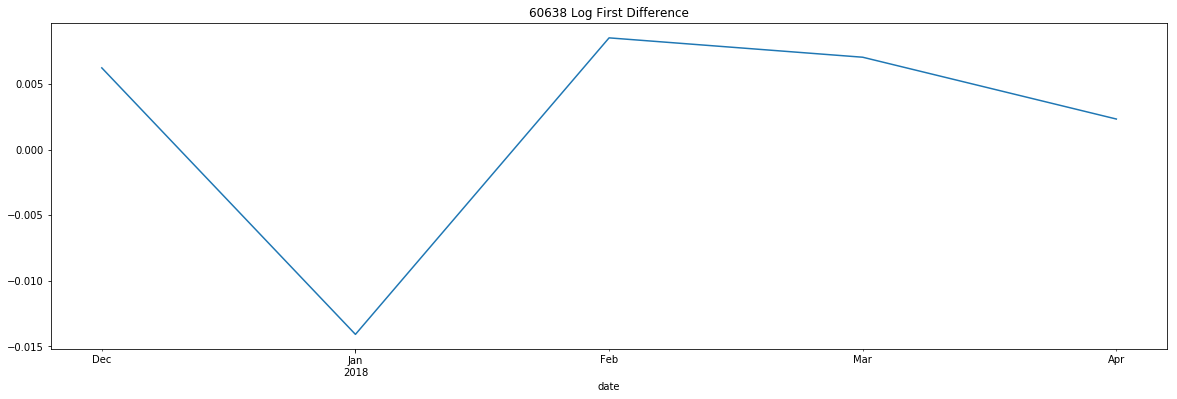

Test Statistic                -2.255064
p-value                        0.186870
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


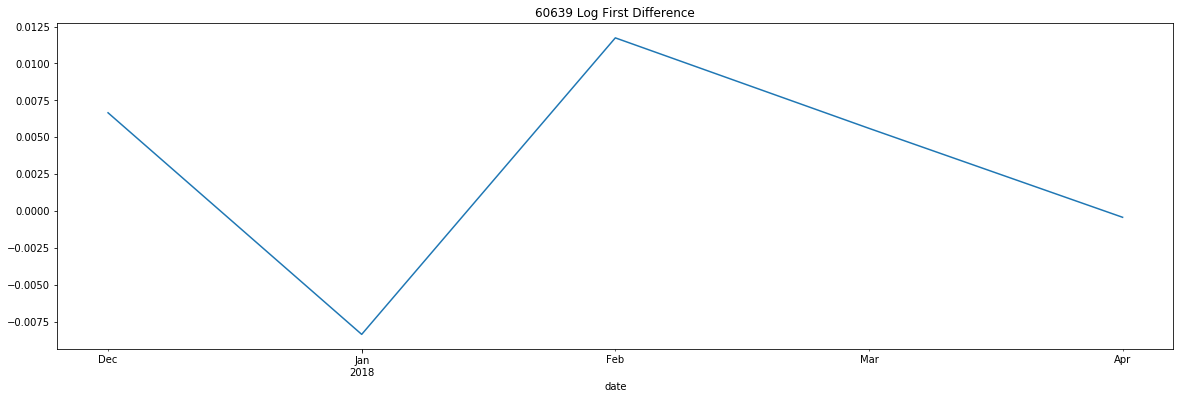

Test Statistic                -2.663600
p-value                        0.080552
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


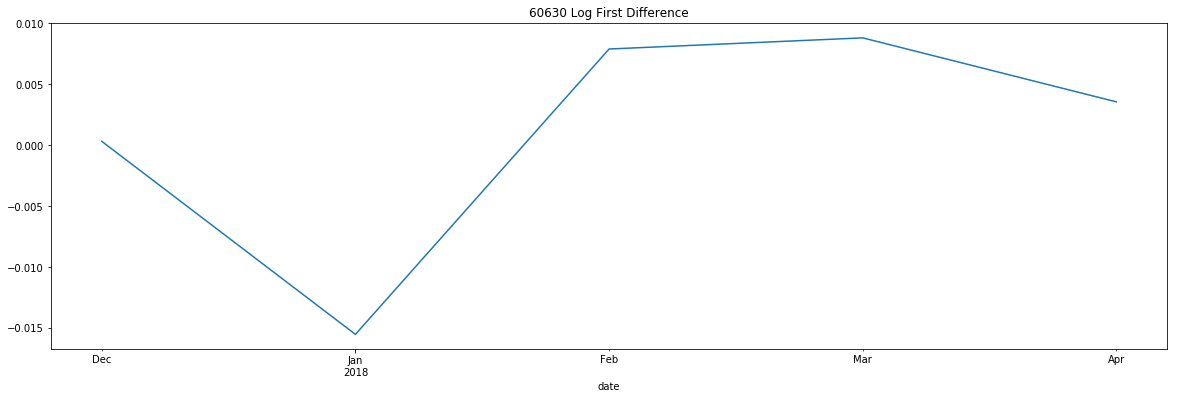

Test Statistic                -1.509017
p-value                        0.529046
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


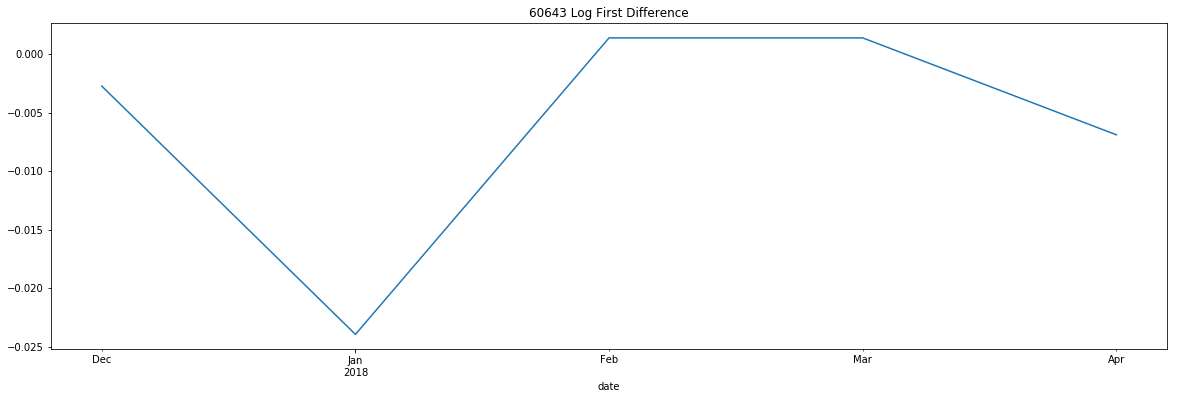

Test Statistic                -2.014926
p-value                        0.280067
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


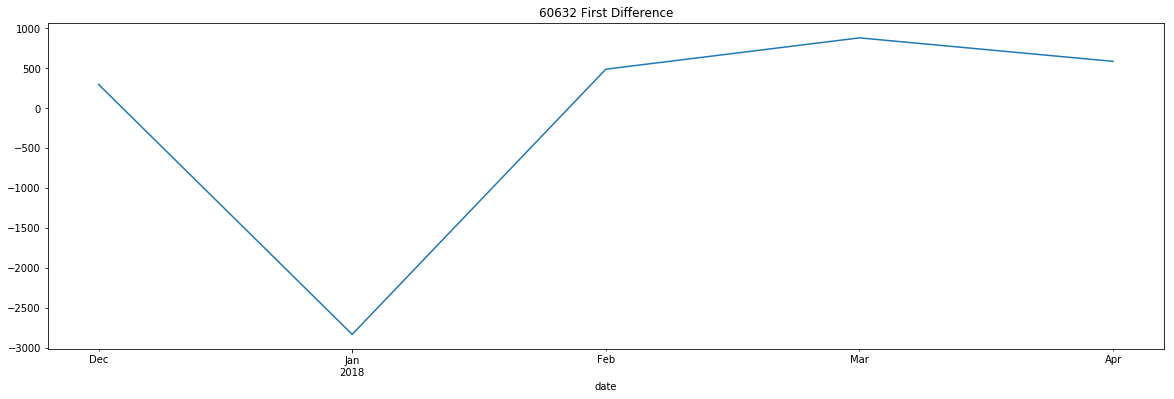

Test Statistic                -1.649052
p-value                        0.457535
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


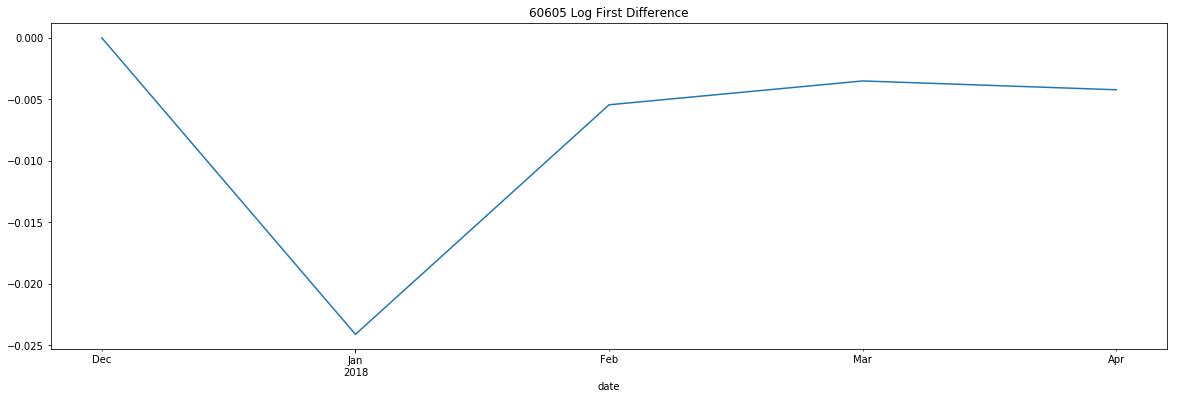

Test Statistic                -2.429934
p-value                        0.133465
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


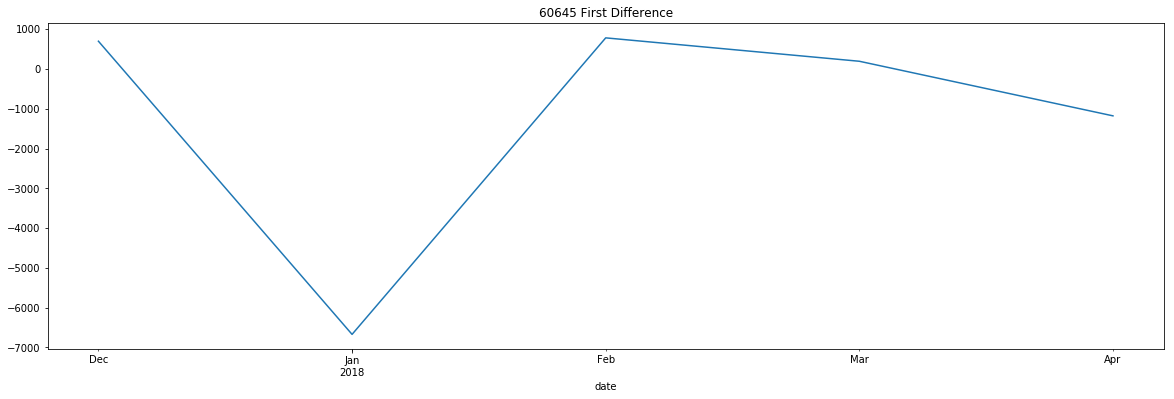

Test Statistic                -2.559435
p-value                        0.101674
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


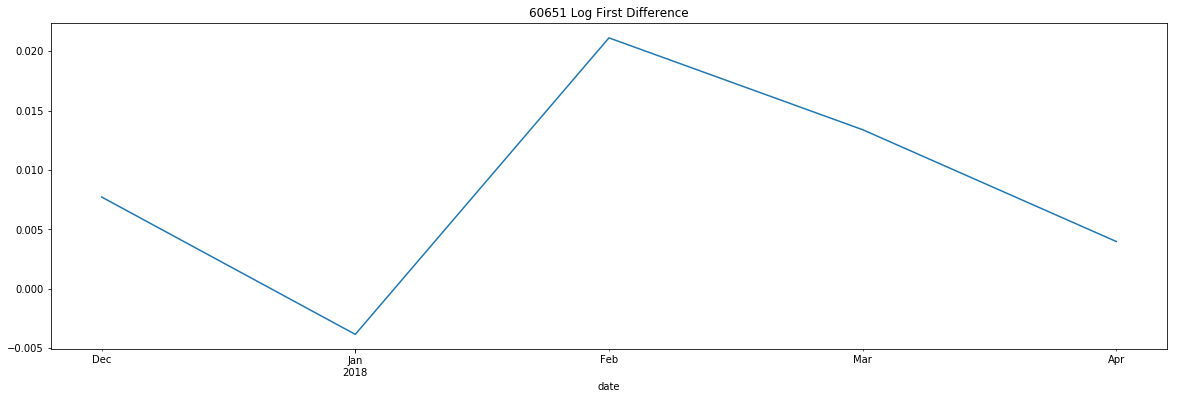

Test Statistic                -1.901469
p-value                        0.331371
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


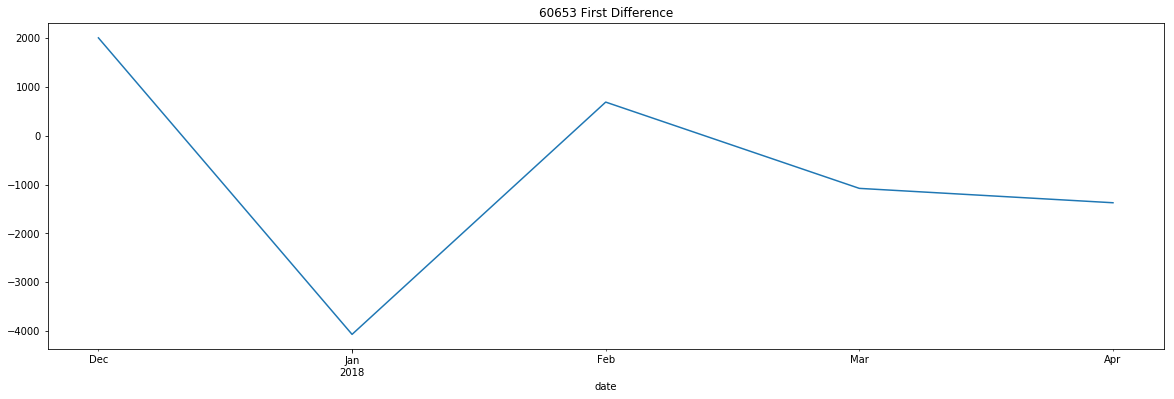

Test Statistic                -6.948862e+00
p-value                        9.810309e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.000000e+00
Critical Values (1%)          -7.355441e+00
Critical Values (5%)          -4.474365e+00
Critical Values (10%)         -3.126933e+00
dtype: float64


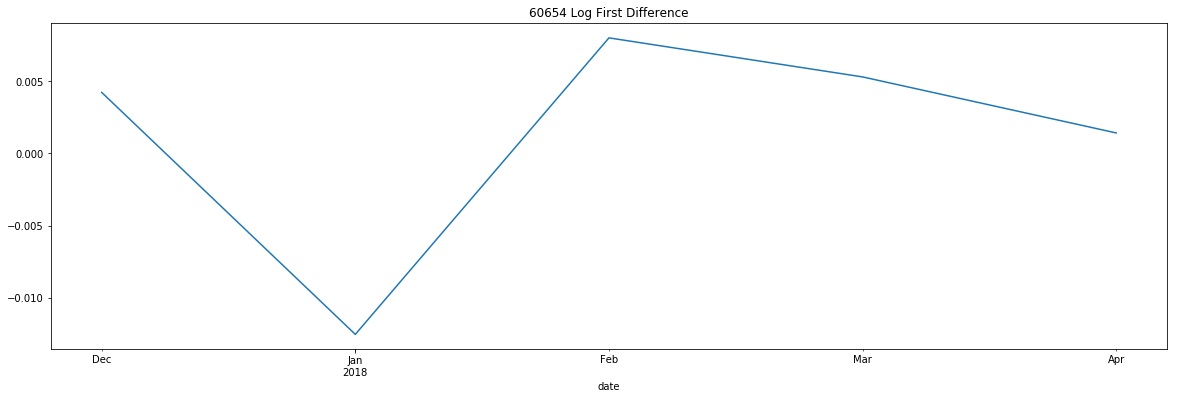

Test Statistic                -2.233869
p-value                        0.194183
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


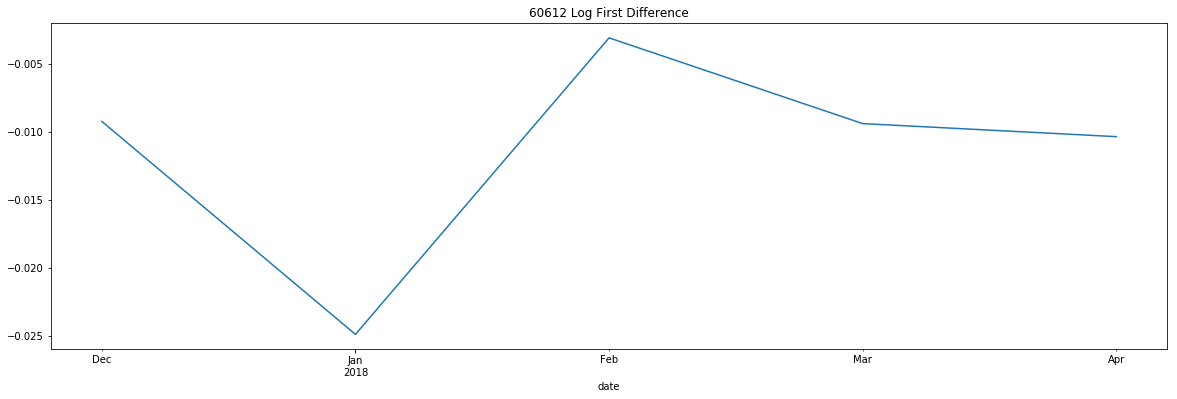

Test Statistic                -2.395764
p-value                        0.142936
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


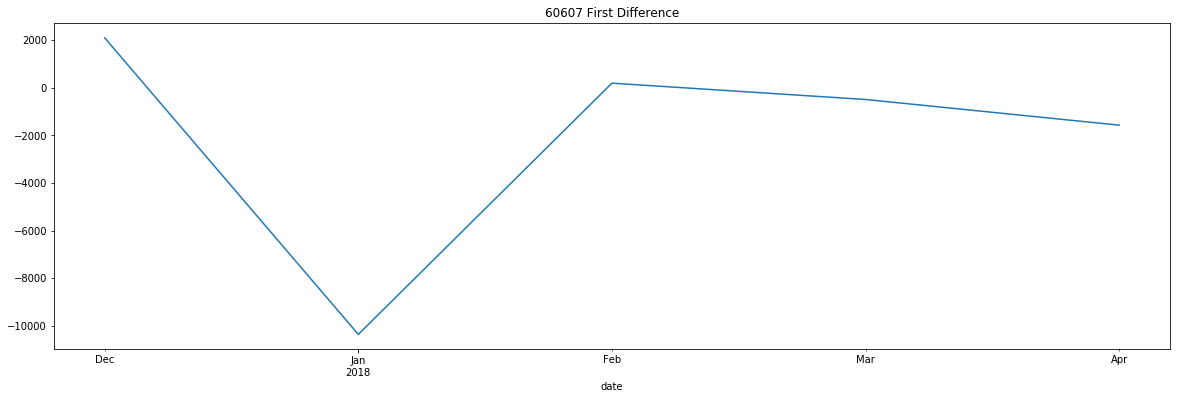

Test Statistic                -3.051503
p-value                        0.030357
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


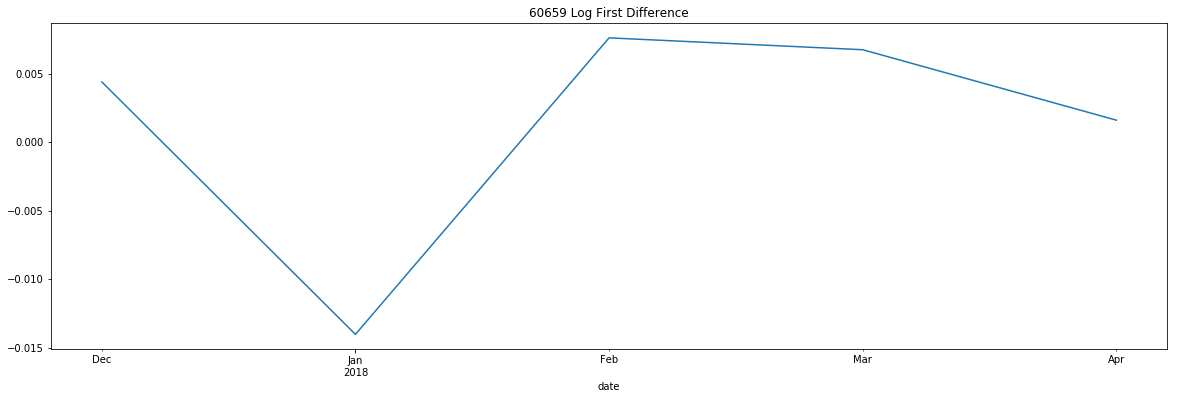

Test Statistic                -2.074248
p-value                        0.254995
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


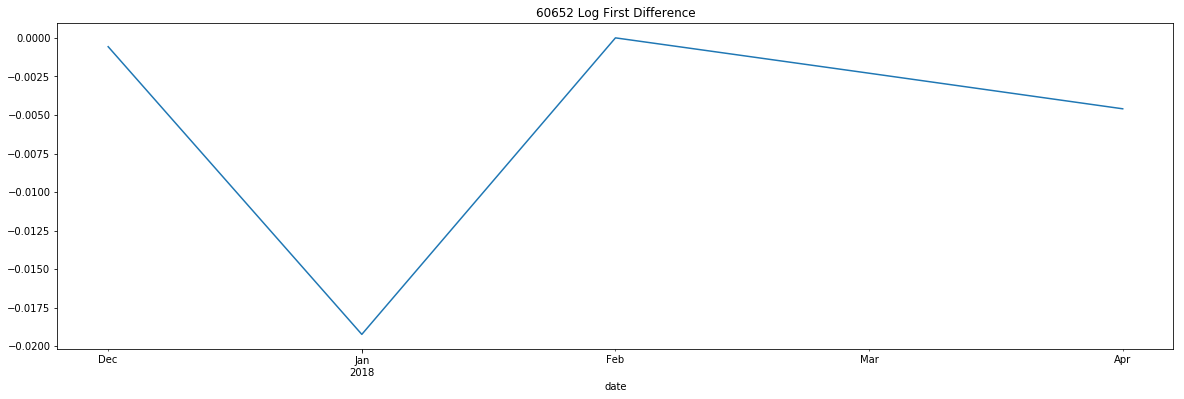

Test Statistic                -2.592341
p-value                        0.094591
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


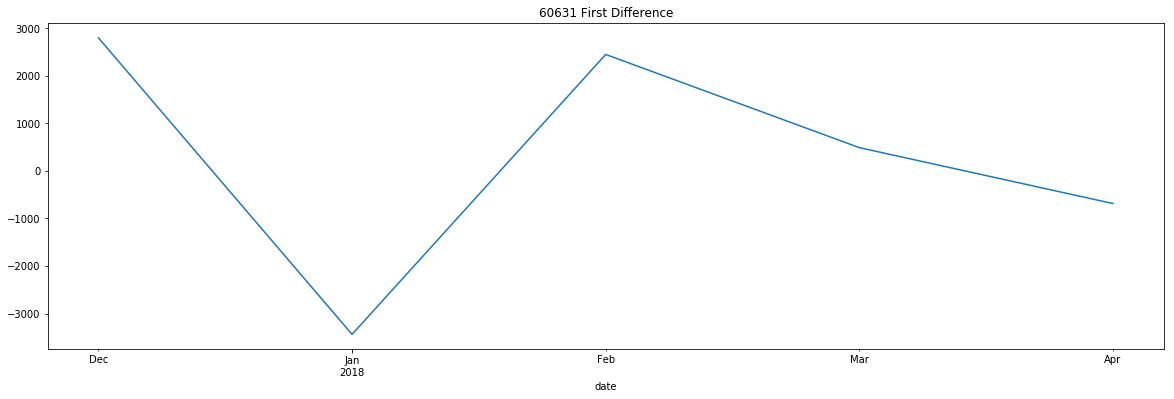

Test Statistic                -4.396752
p-value                        0.000301
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


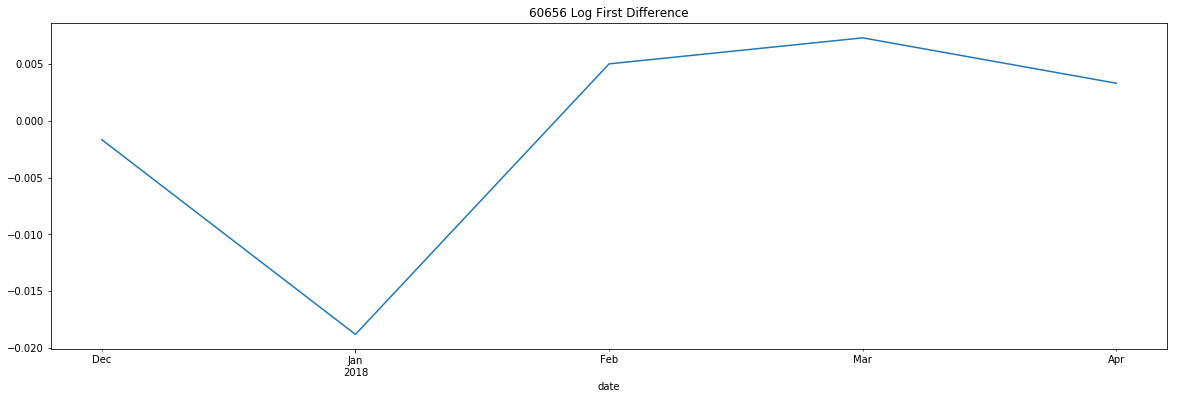

Test Statistic                -1.407081
p-value                        0.578877
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


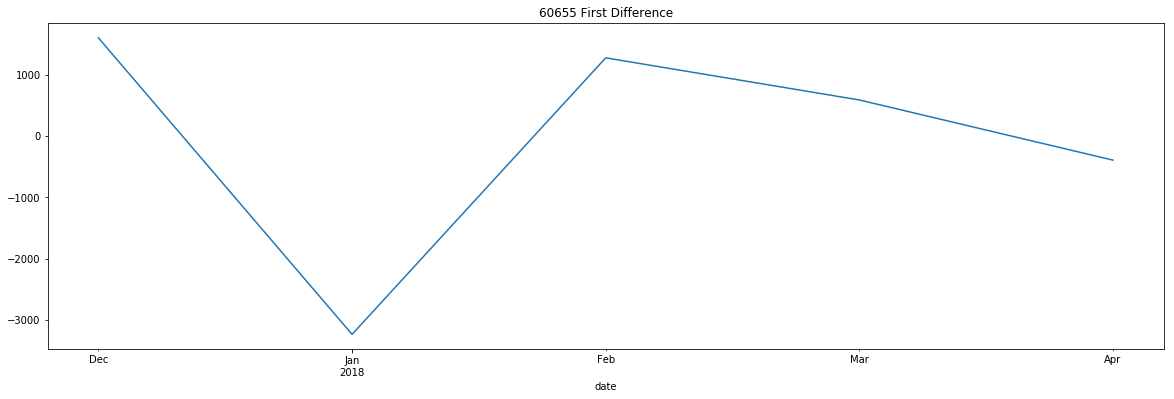

Test Statistic                -3.320648
p-value                        0.013980
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


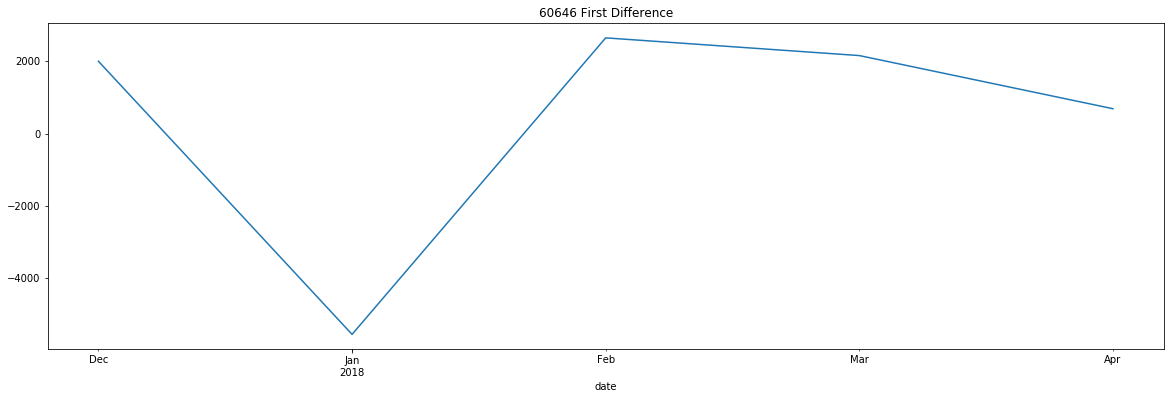

Test Statistic                -2.262681
p-value                        0.184287
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


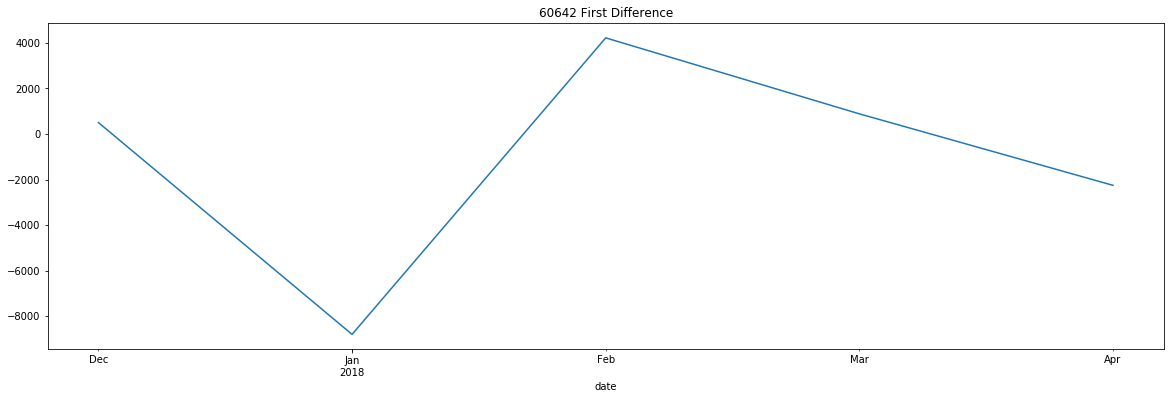

Test Statistic                -2.396224
p-value                        0.142805
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64


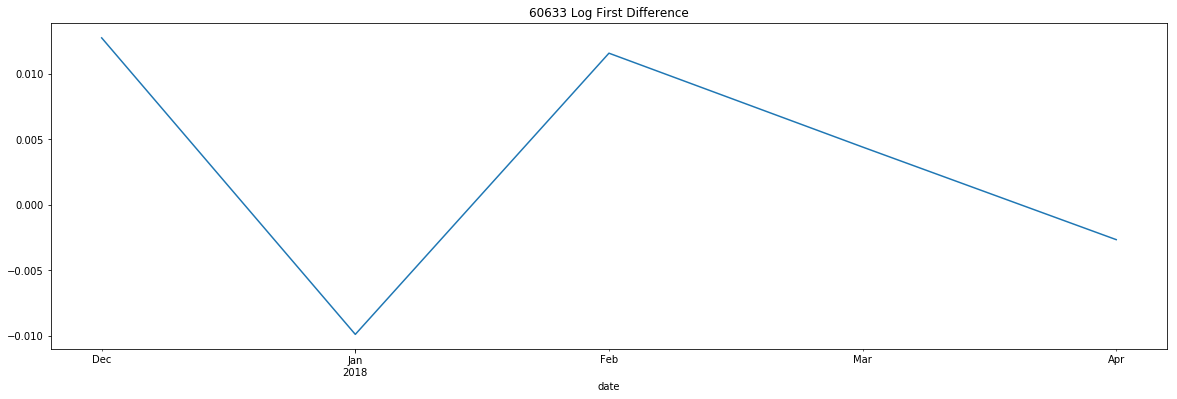

Test Statistic                -4.057963
p-value                        0.001136
#Lags Used                     0.000000
Number of Observations Used    4.000000
Critical Values (1%)          -7.355441
Critical Values (5%)          -4.474365
Critical Values (10%)         -3.126933
dtype: float64

 The p-value above 0.05: 28


In [249]:
zc_test_dt = detrend_test(zillow_chicago_test, 0.05, maxlag=0)
zc_test_dt.drop(drop_list, axis=1, inplace=True)

The nan's are because we took the differences (sometimes twice). 

In [58]:
def ACF_PACF(TS, lags):
    for column in list(TS.columns):
        print(column)
        plt.figure(figsize=(20,6))
        pd.plotting.autocorrelation_plot(TS[column].dropna())
        plt.title('Autocorrelation Function')
        plt.show()
        from statsmodels.graphics.tsaplots import plot_pacf
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize']=14,5
        plot_pacf(TS[column].dropna(), lags=lags)
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()
        print('_____________________________________________________________________')

60657


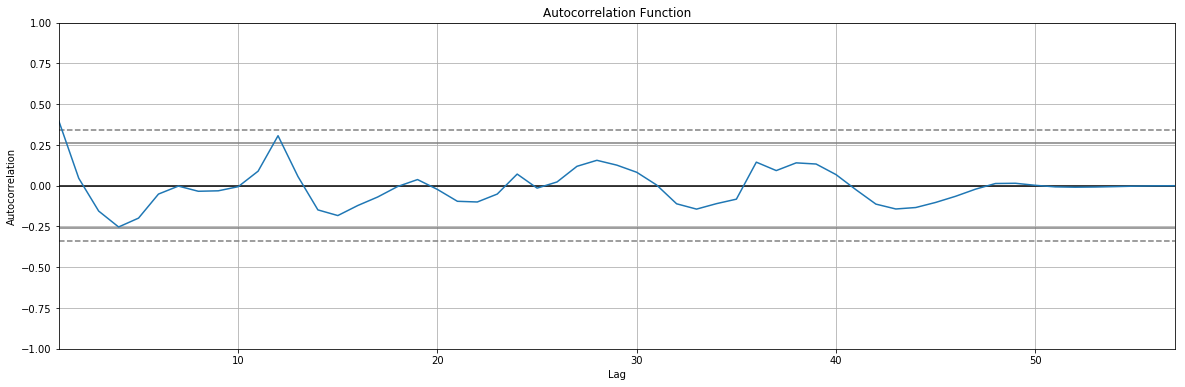

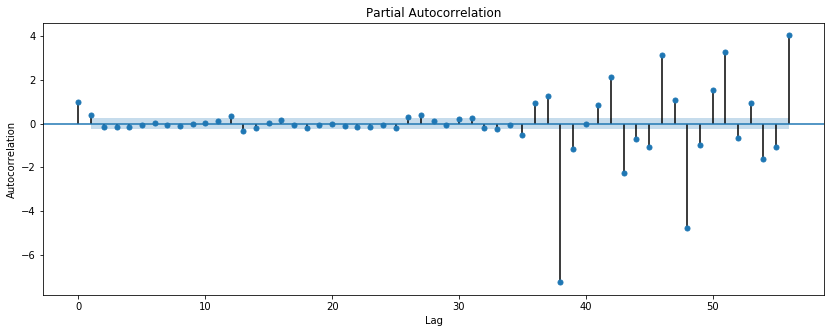

_____________________________________________________________________
60614


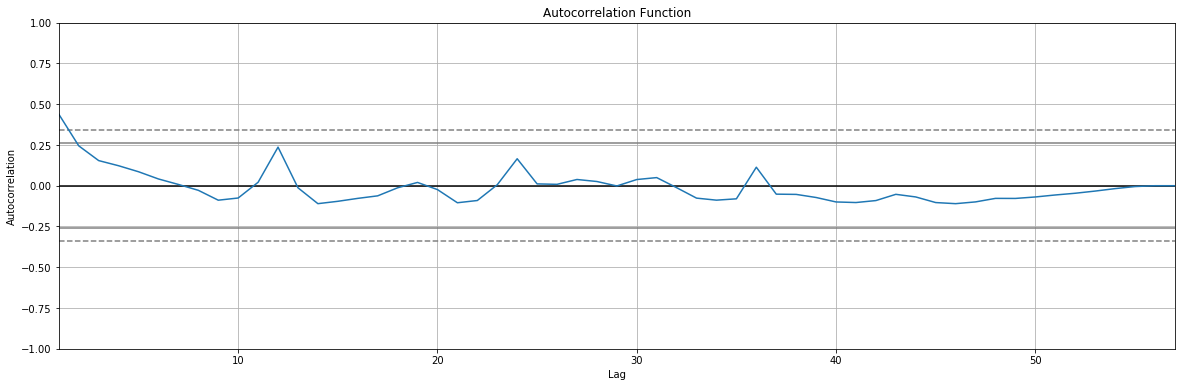

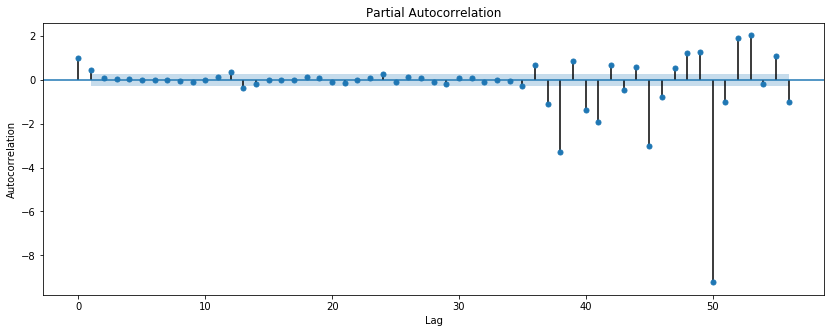

_____________________________________________________________________
60640


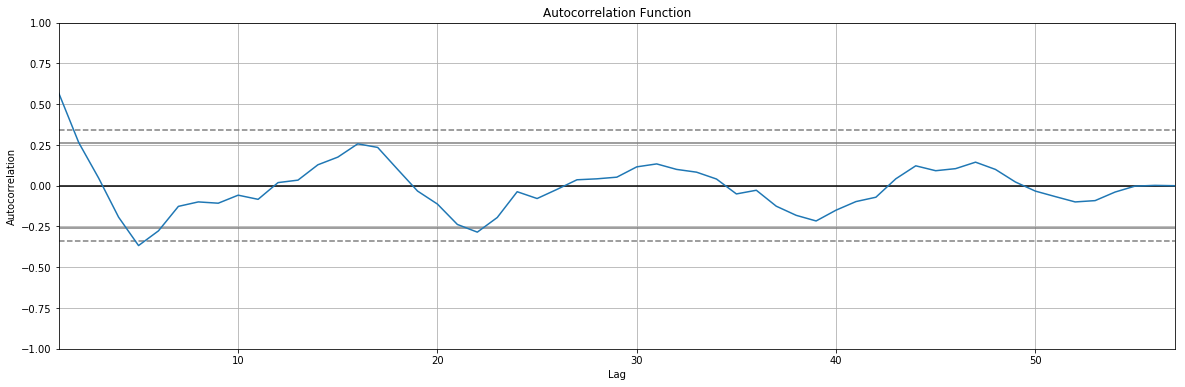

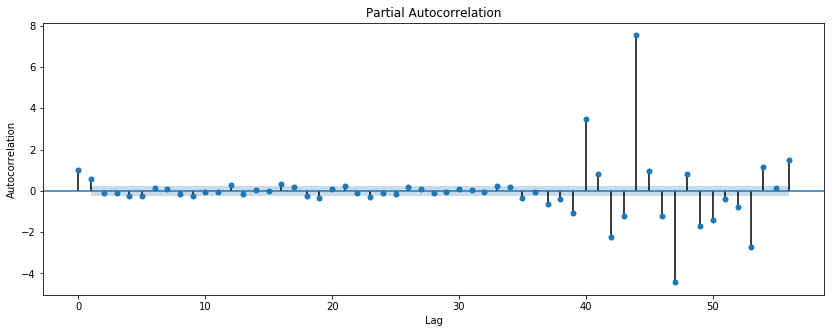

_____________________________________________________________________
60647


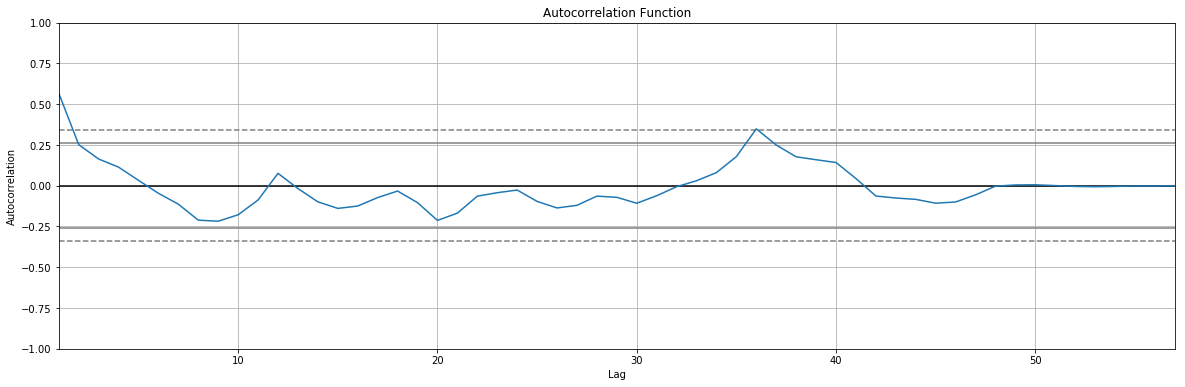

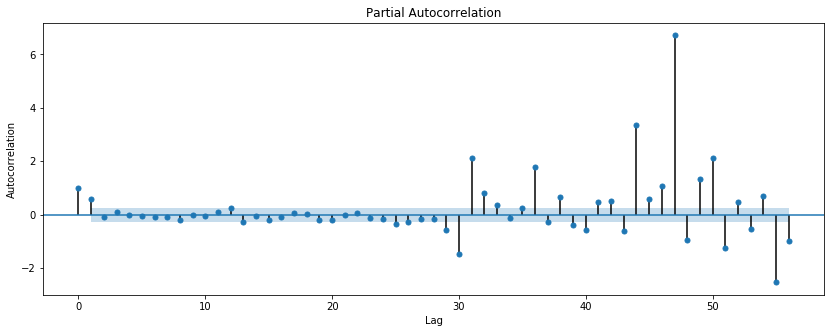

_____________________________________________________________________
60618


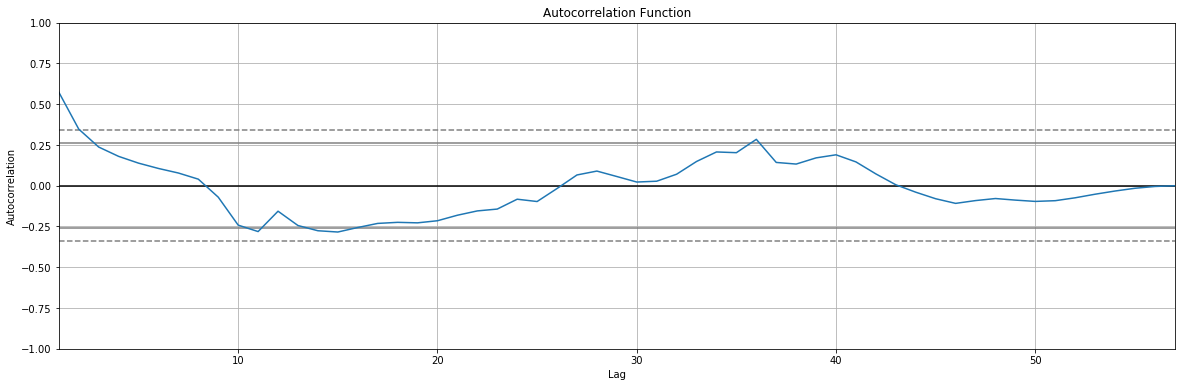

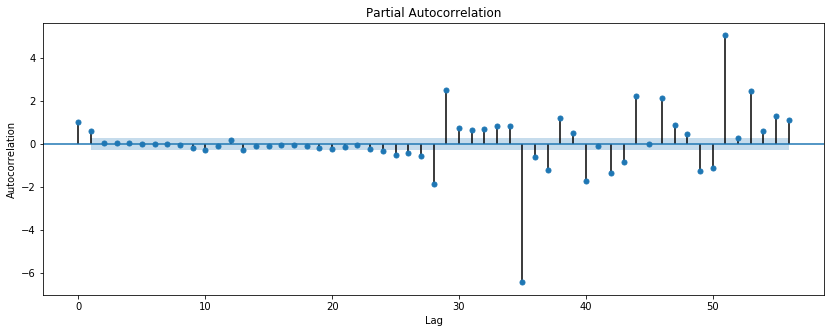

_____________________________________________________________________
60613


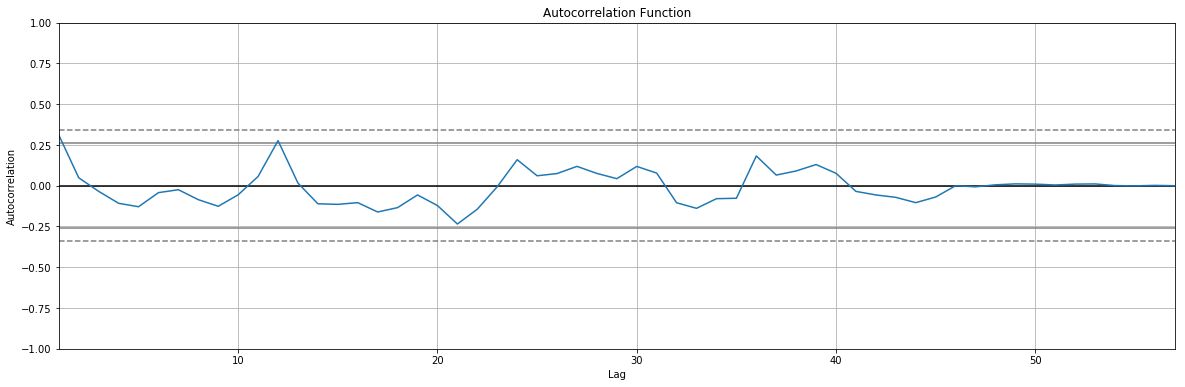

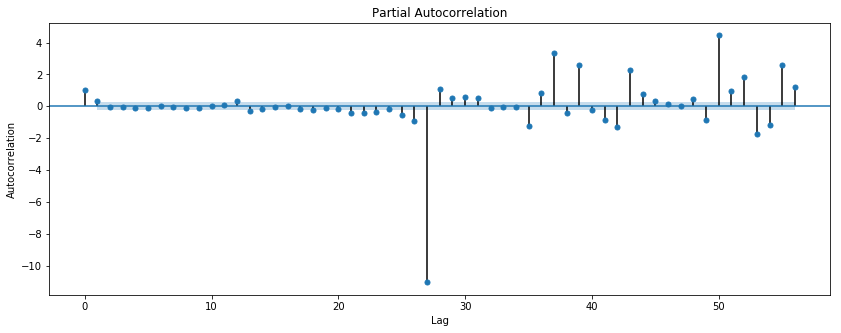

_____________________________________________________________________
60629


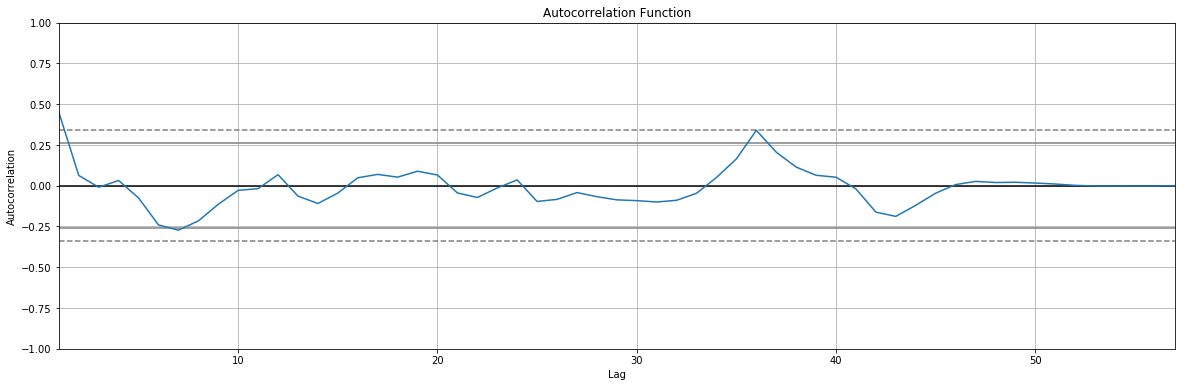

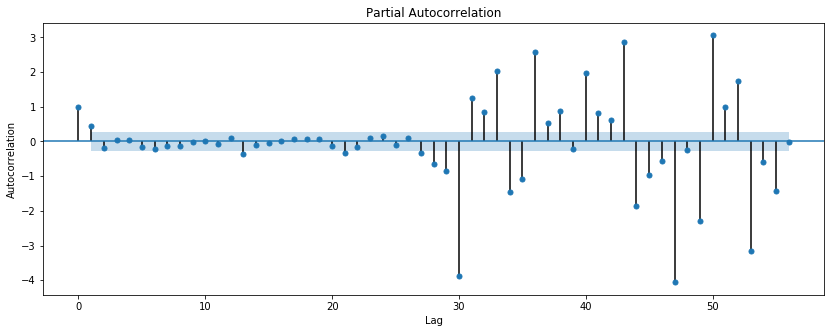

_____________________________________________________________________
60625


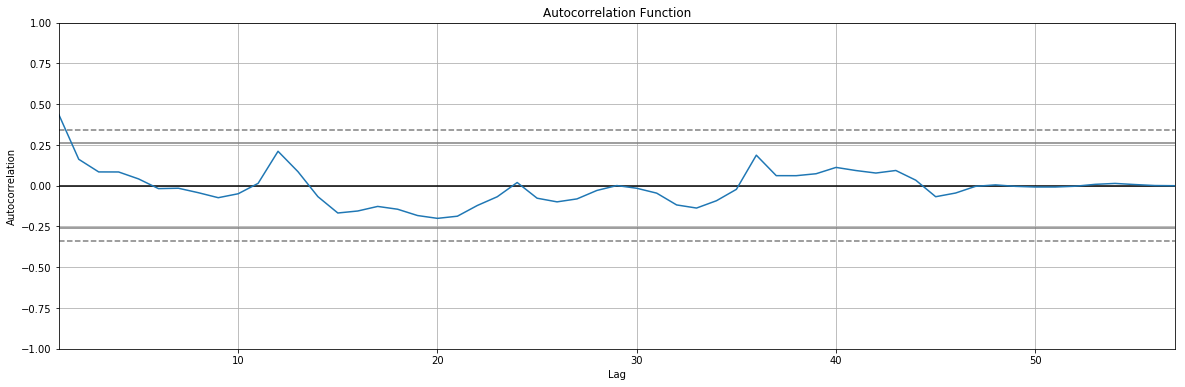

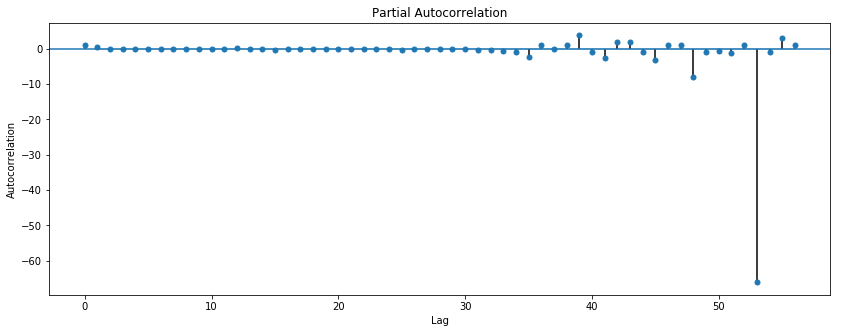

_____________________________________________________________________
60619


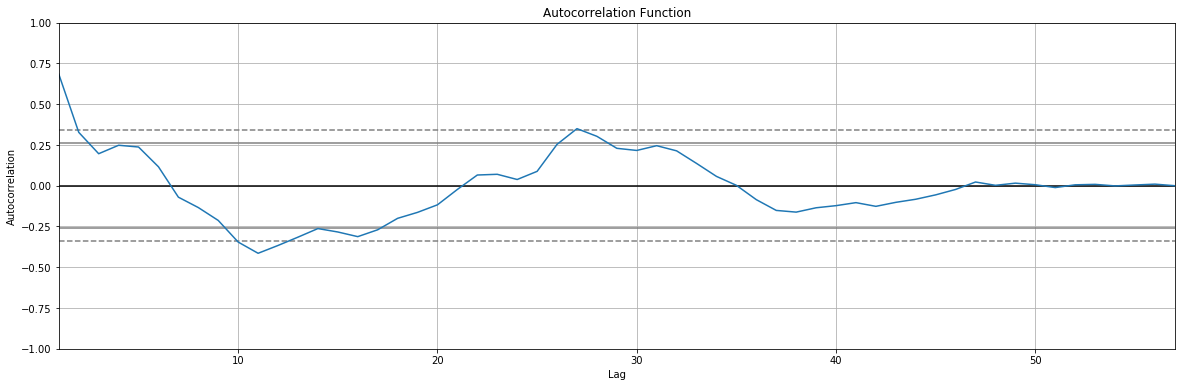

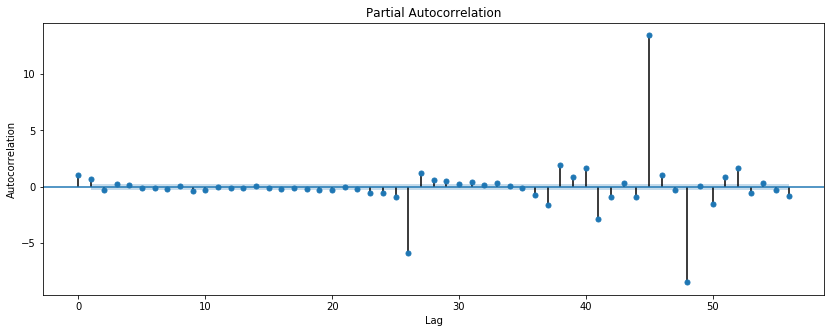

_____________________________________________________________________
60610


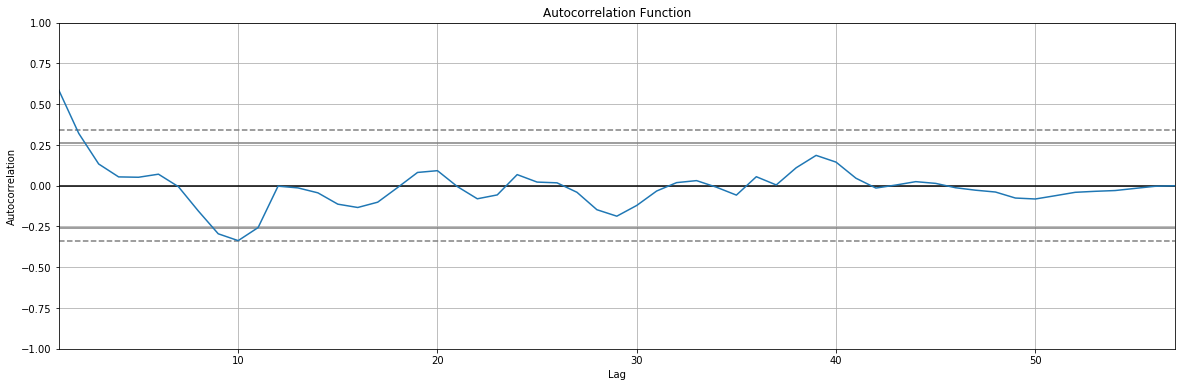

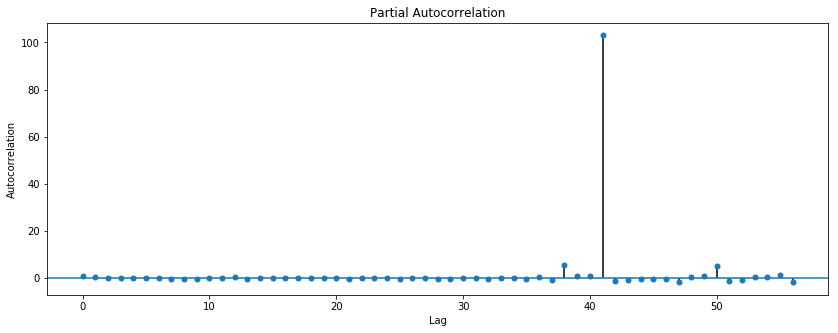

_____________________________________________________________________
60620


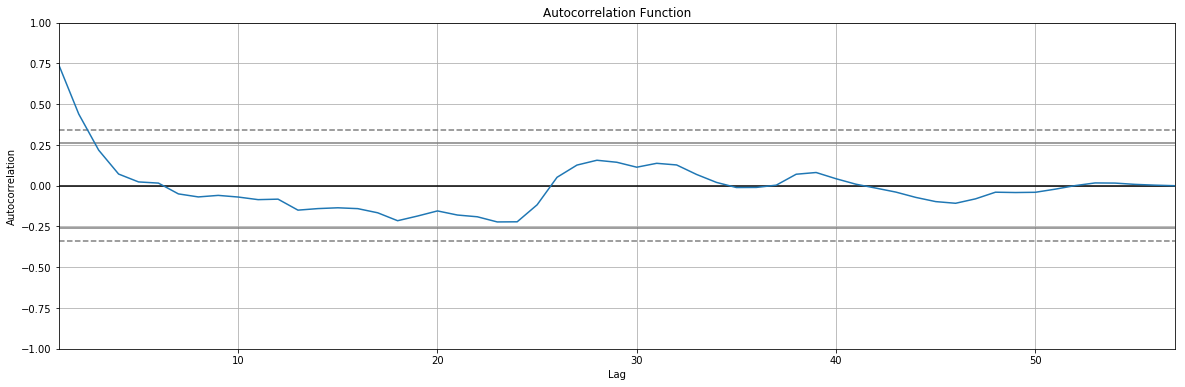

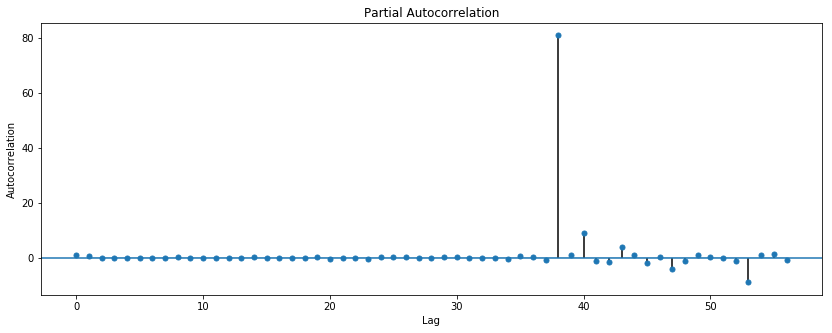

_____________________________________________________________________
60634


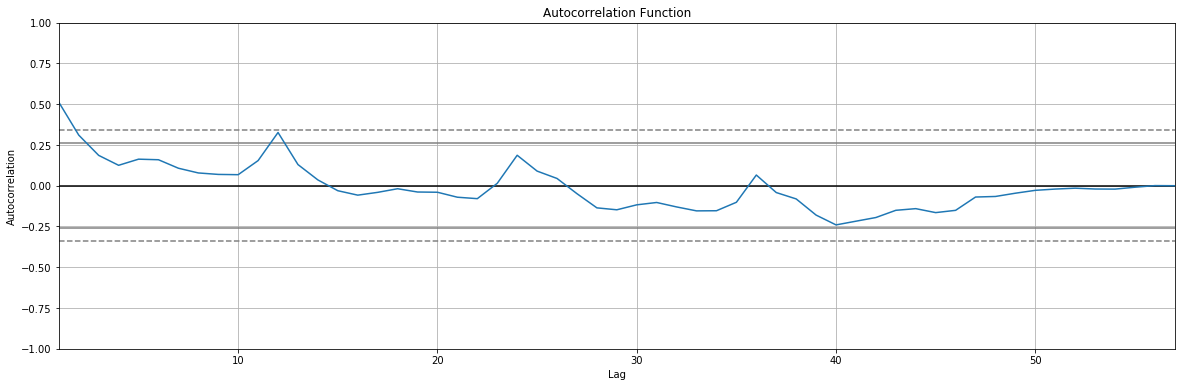

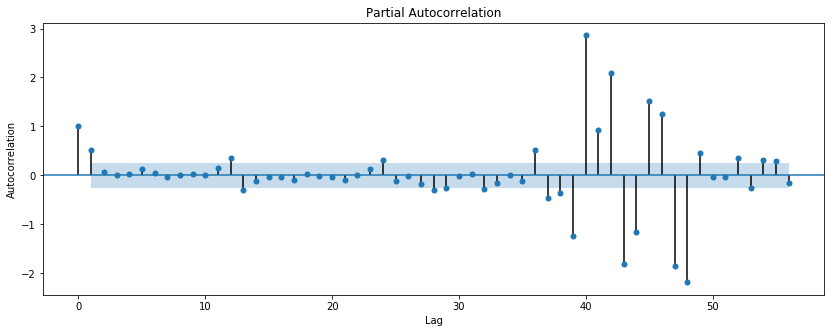

_____________________________________________________________________
60626


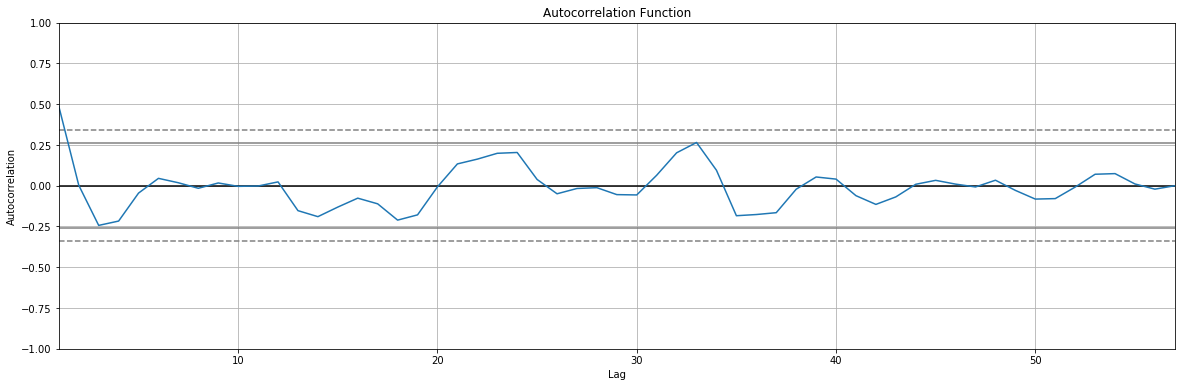

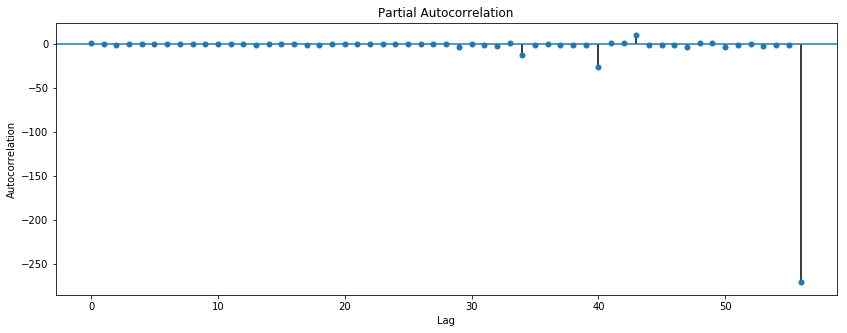

_____________________________________________________________________
60649


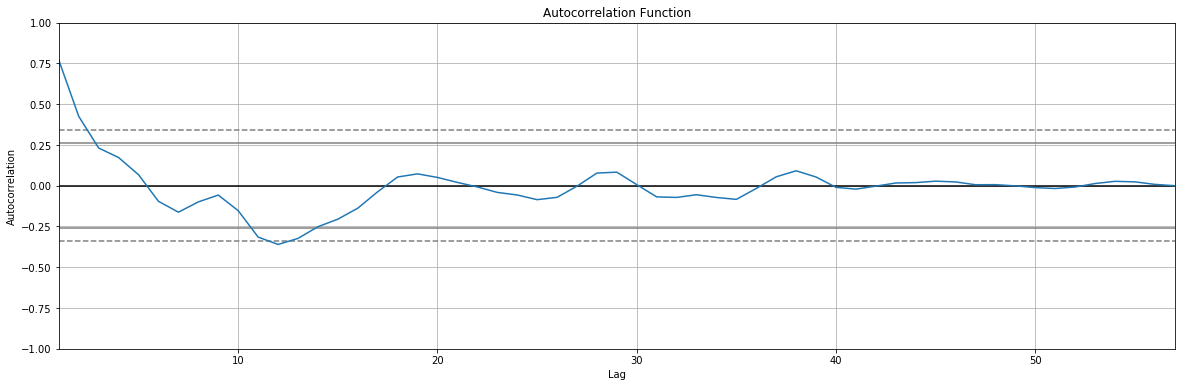

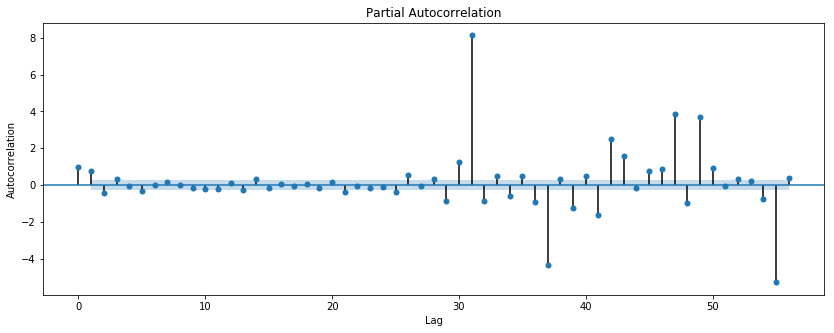

_____________________________________________________________________
60616


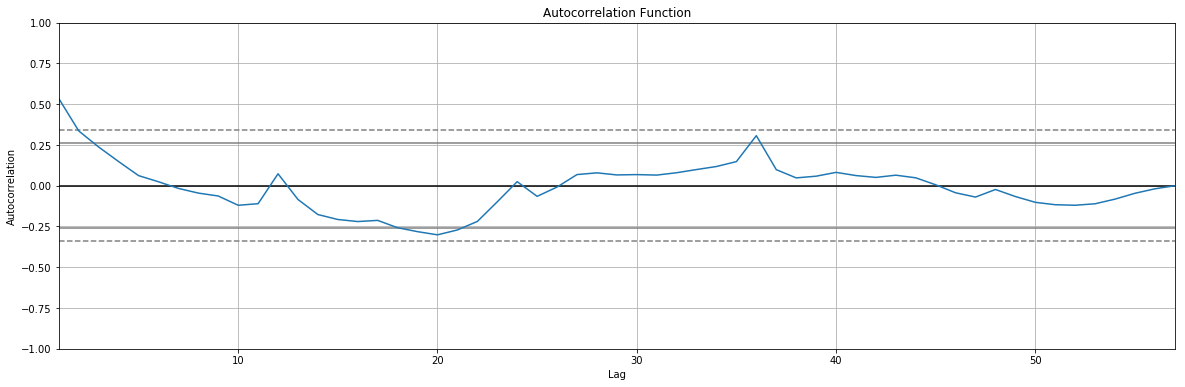

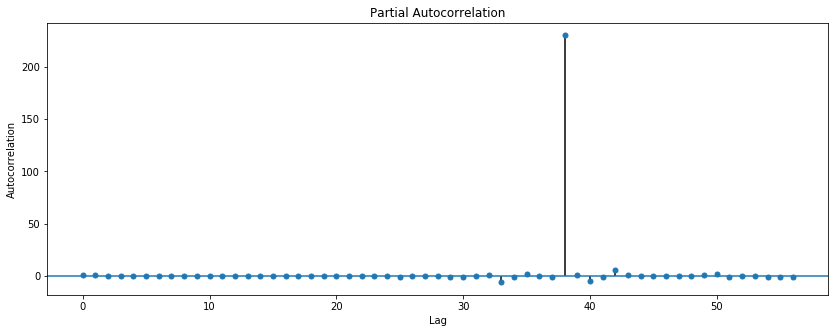

_____________________________________________________________________
60622


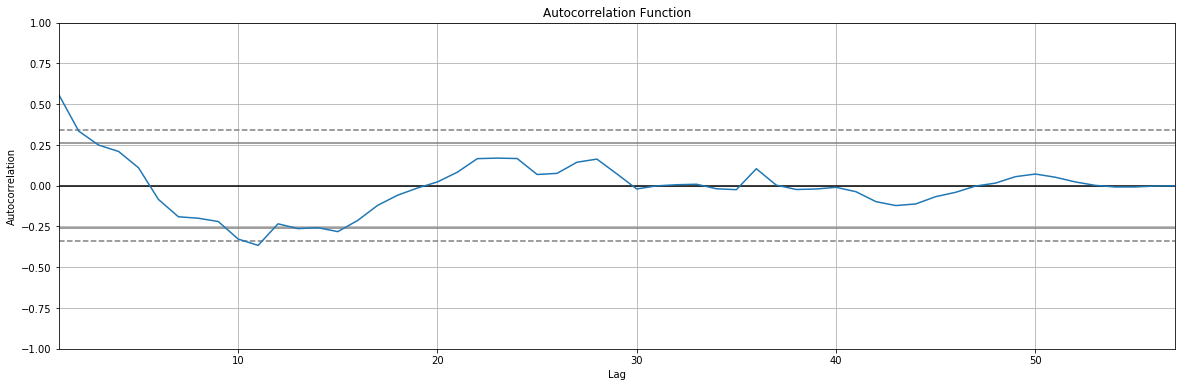

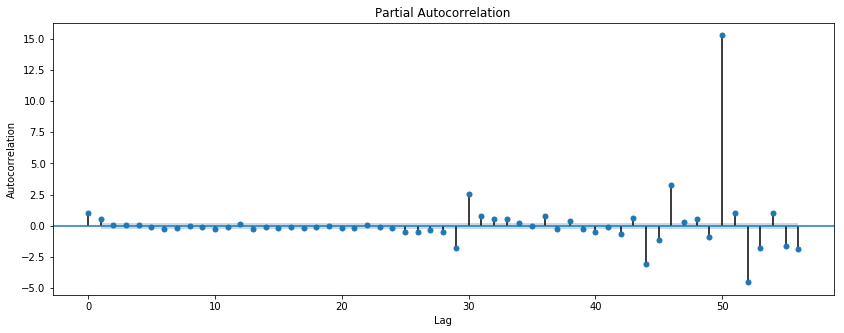

_____________________________________________________________________
60615


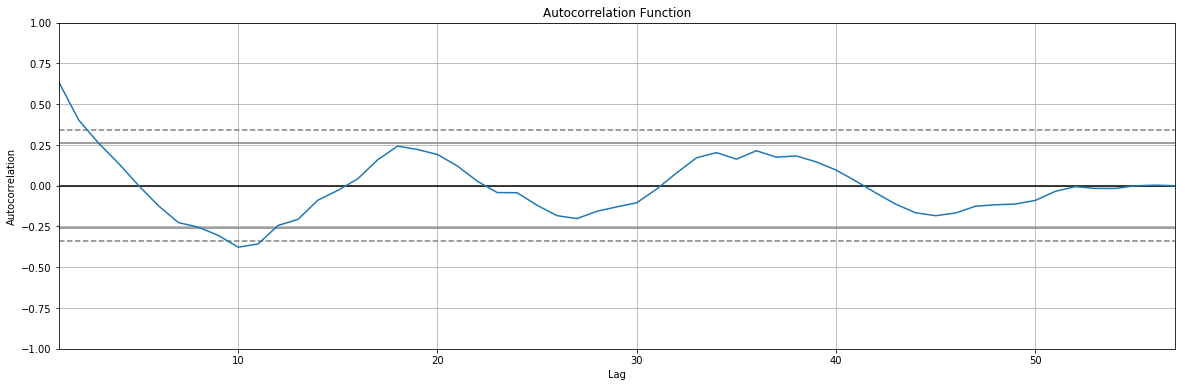

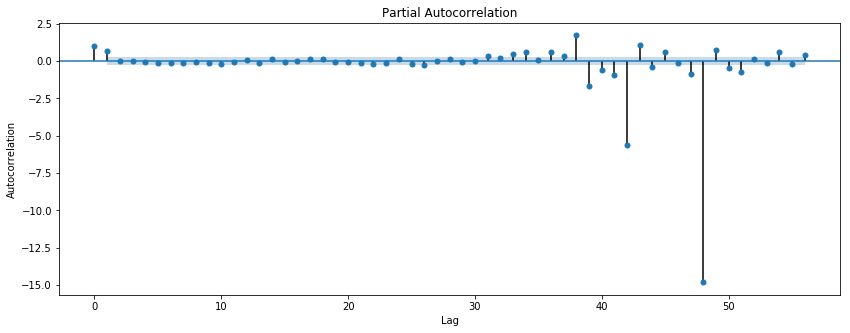

_____________________________________________________________________
60641


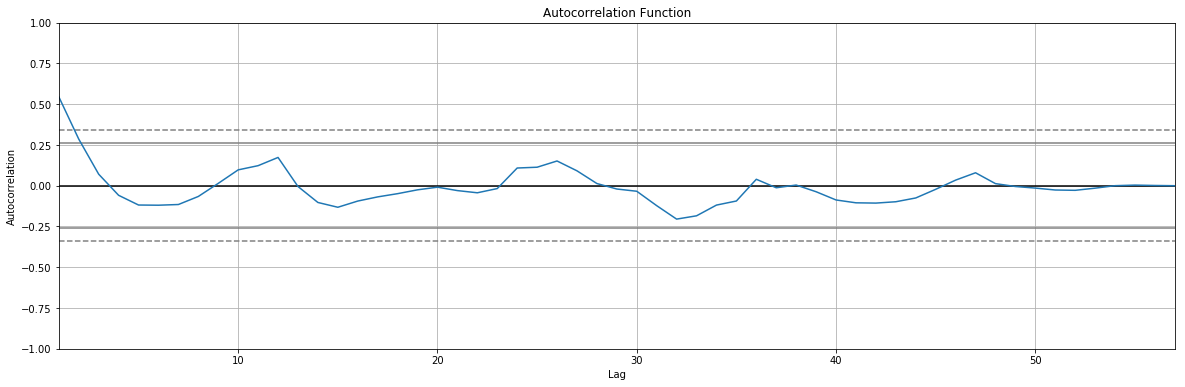

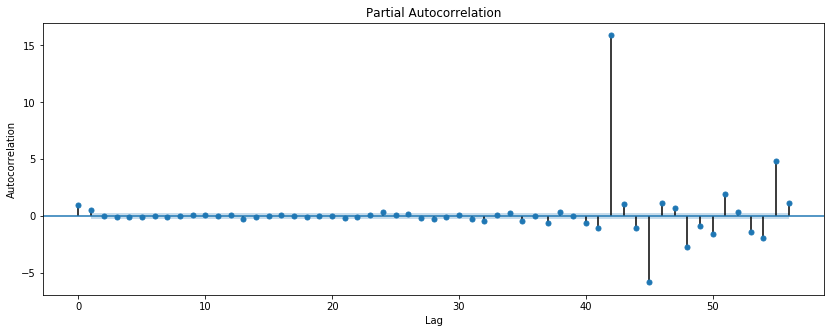

_____________________________________________________________________
60660


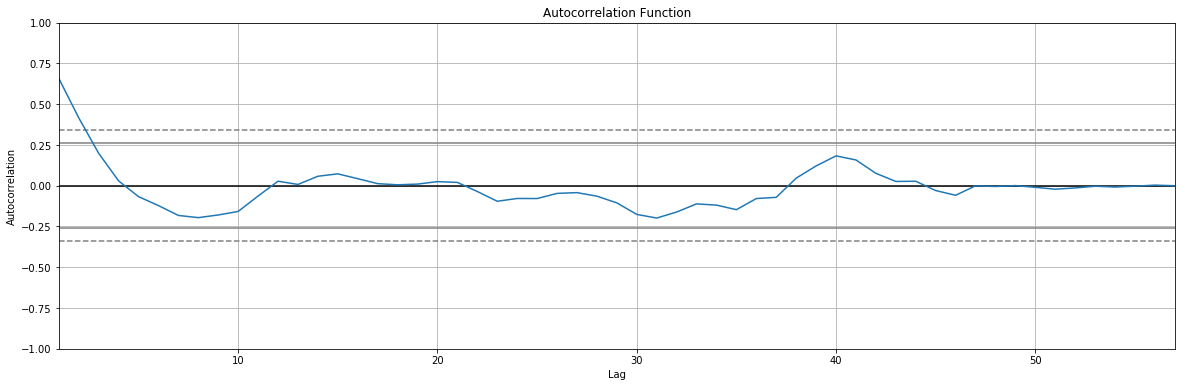

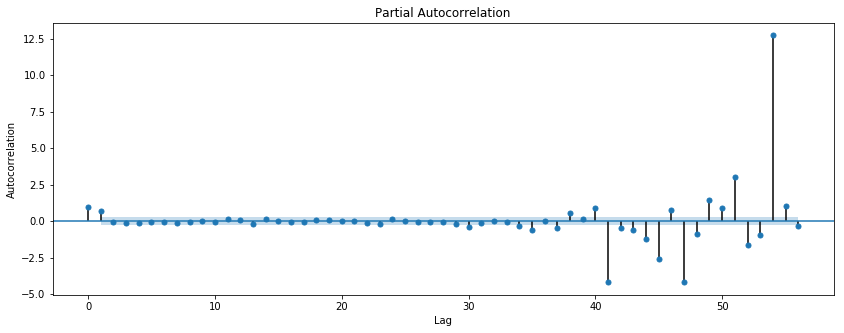

_____________________________________________________________________
60608


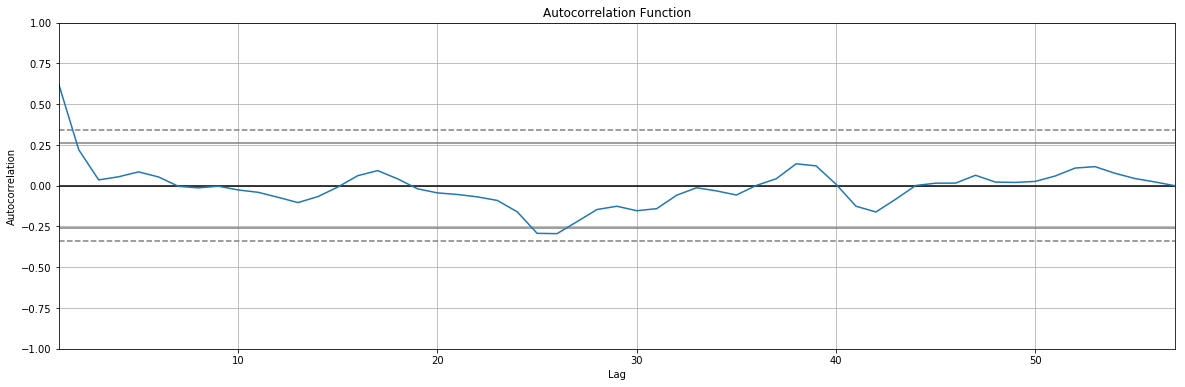

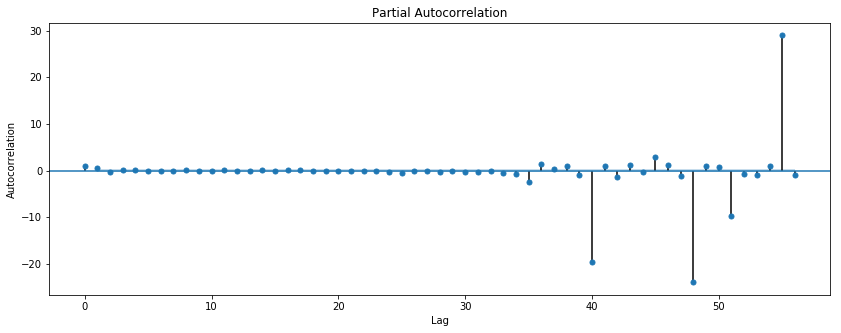

_____________________________________________________________________
60638


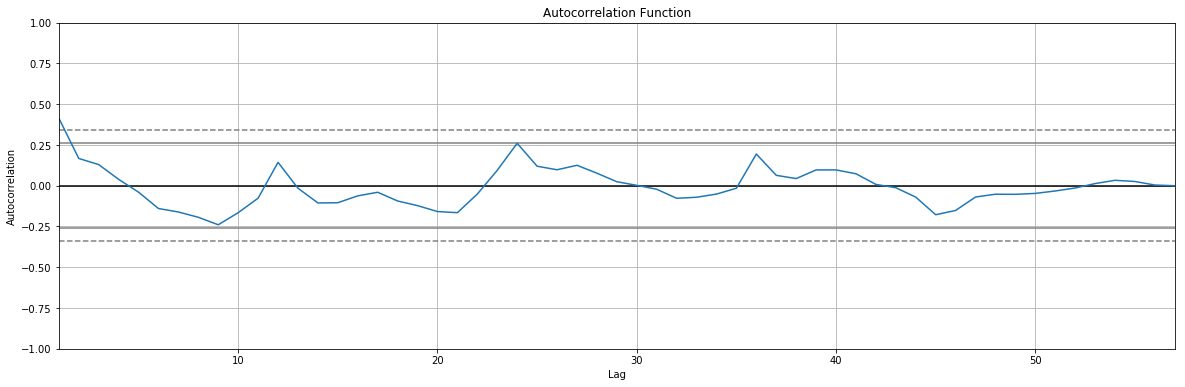

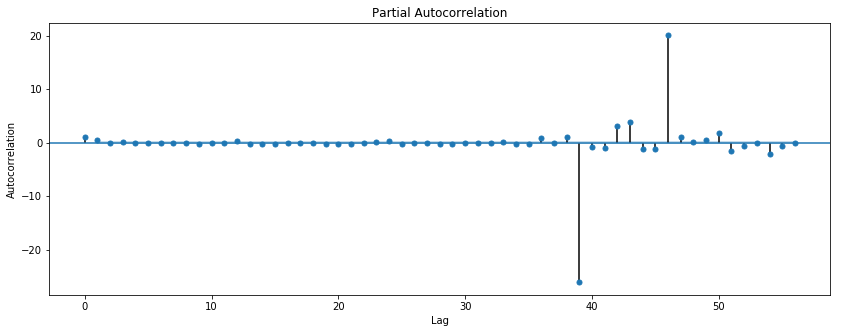

_____________________________________________________________________
60639


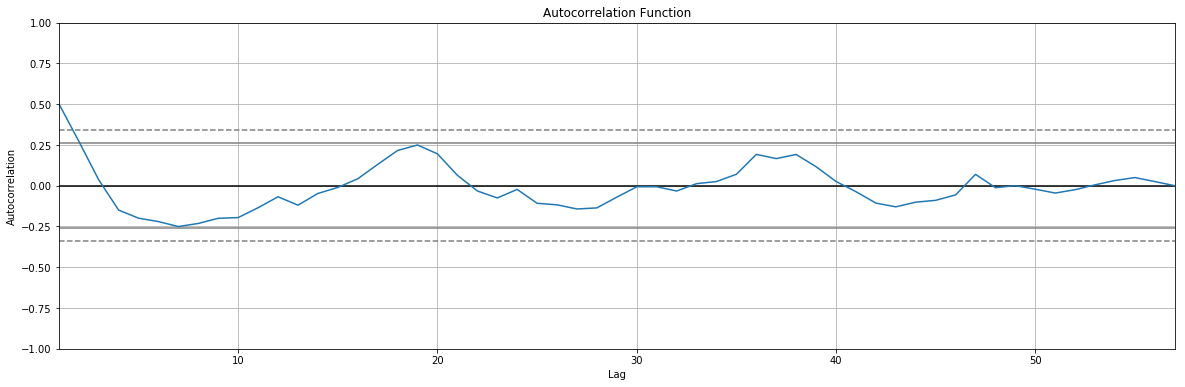

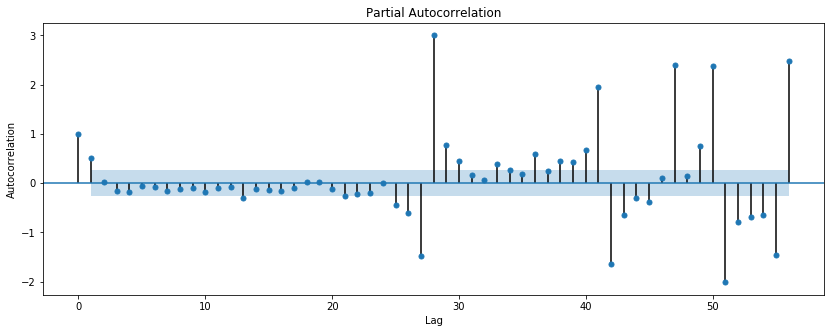

_____________________________________________________________________
60630


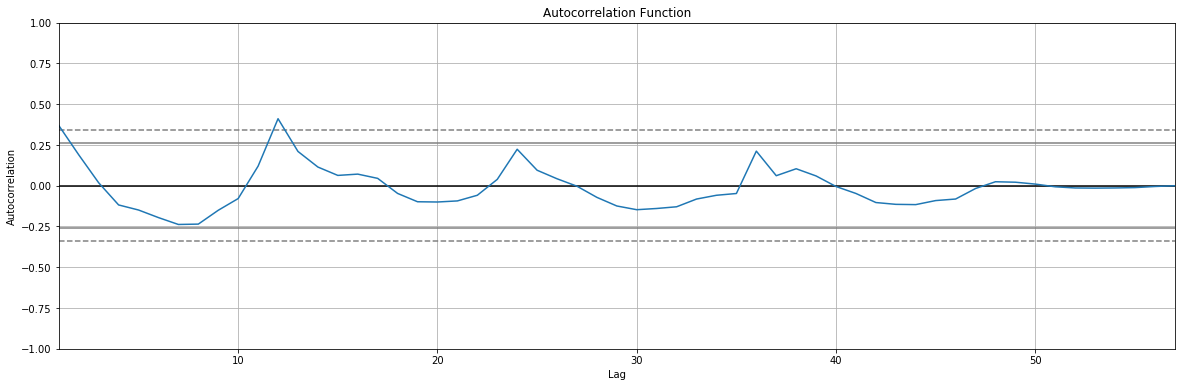

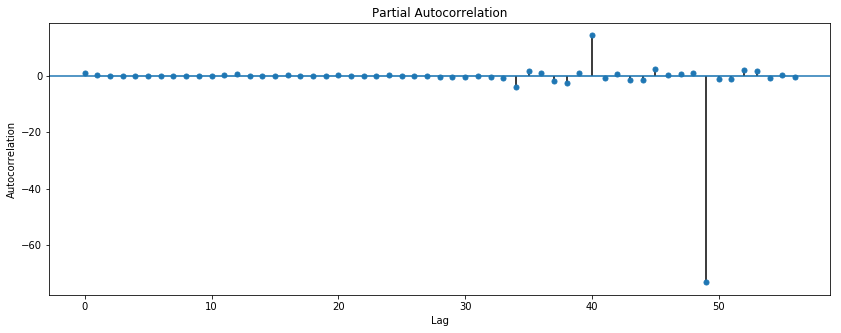

_____________________________________________________________________
60643


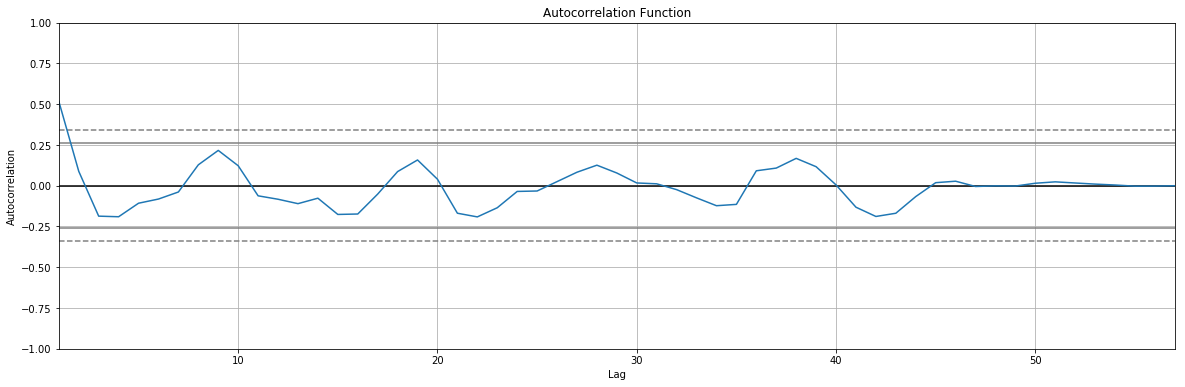

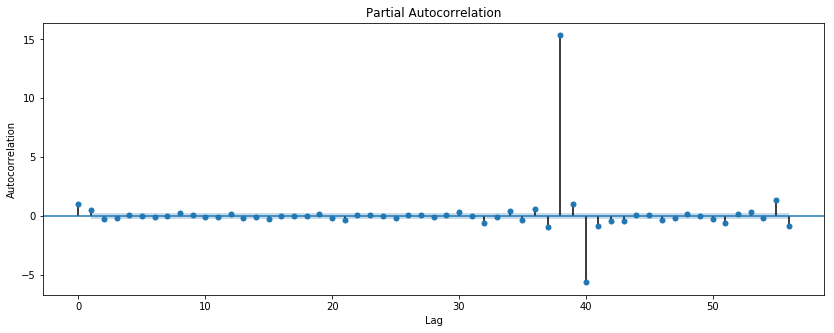

_____________________________________________________________________
60632


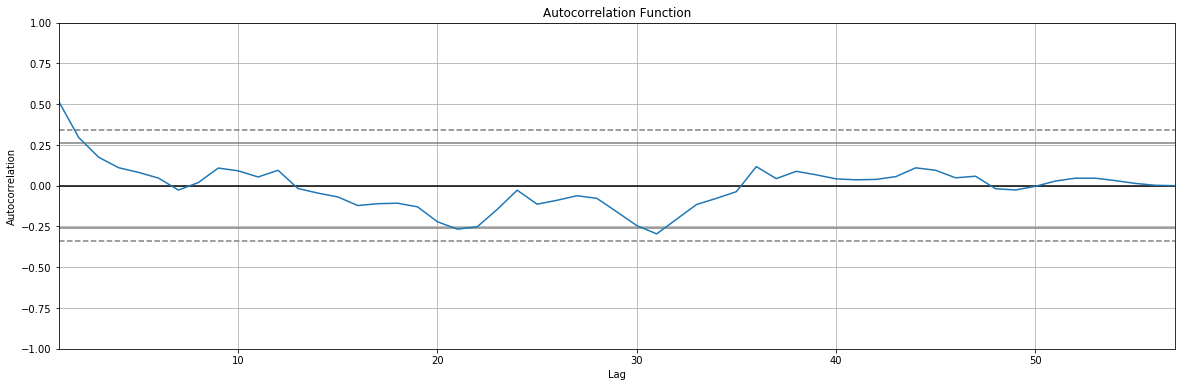

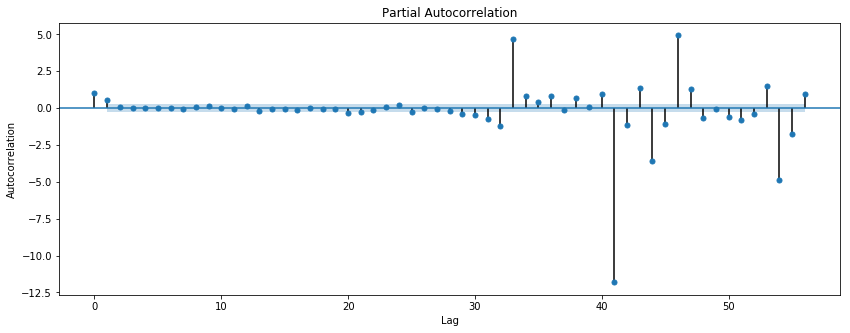

_____________________________________________________________________
60605


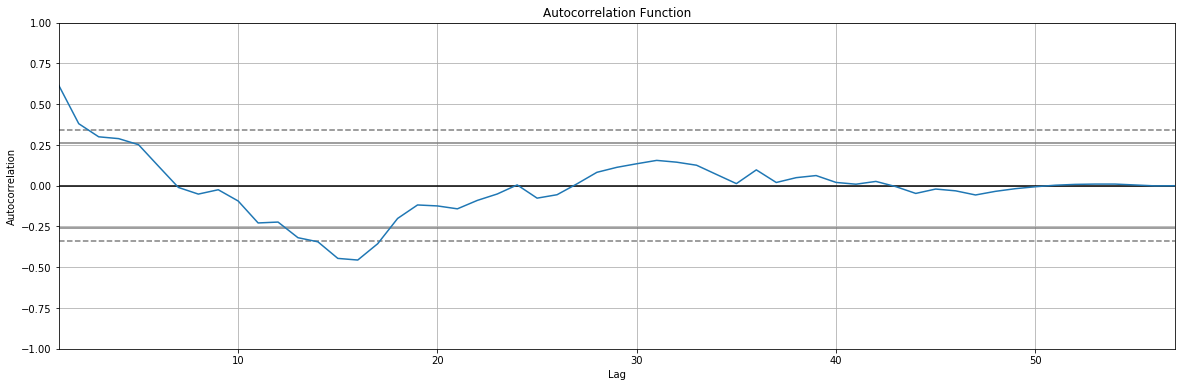

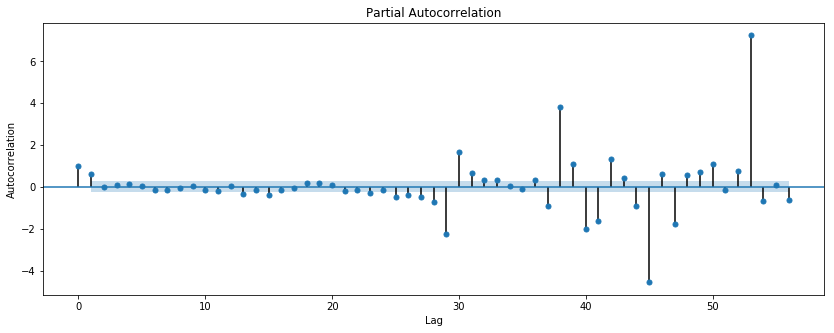

_____________________________________________________________________
60645


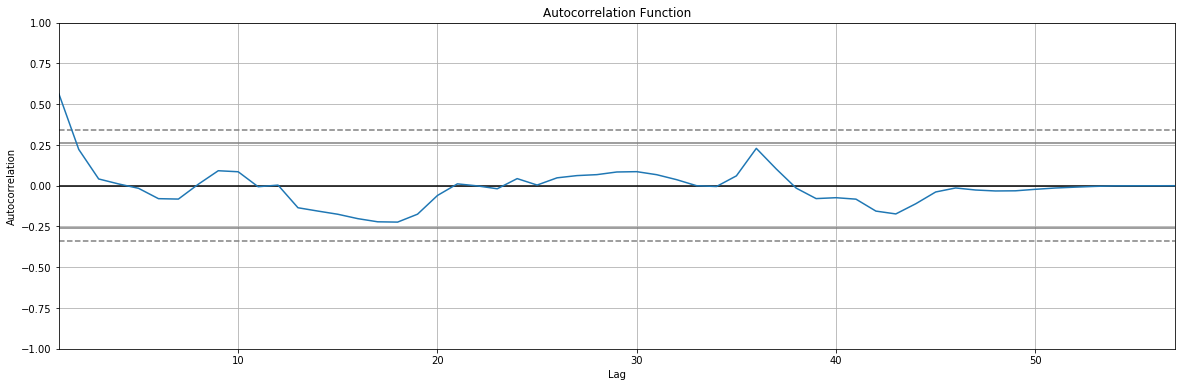

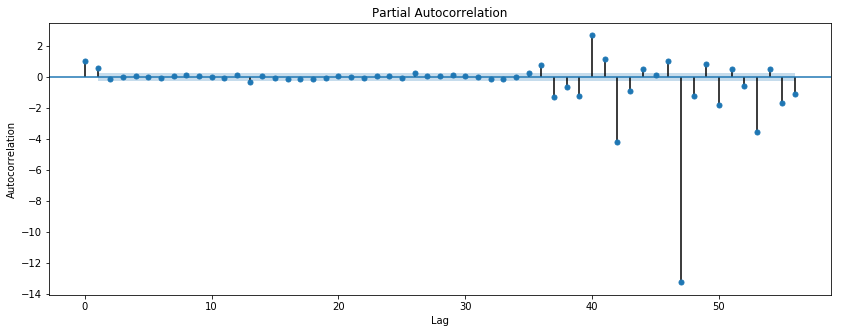

_____________________________________________________________________
60651


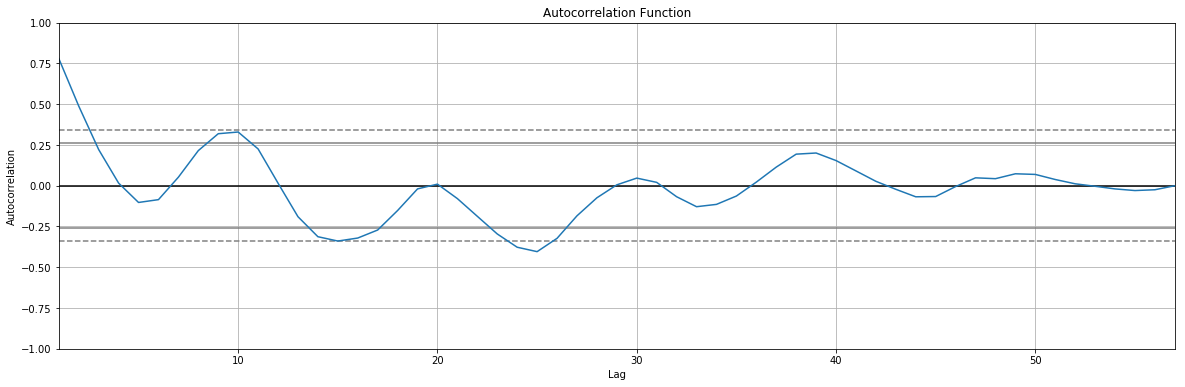

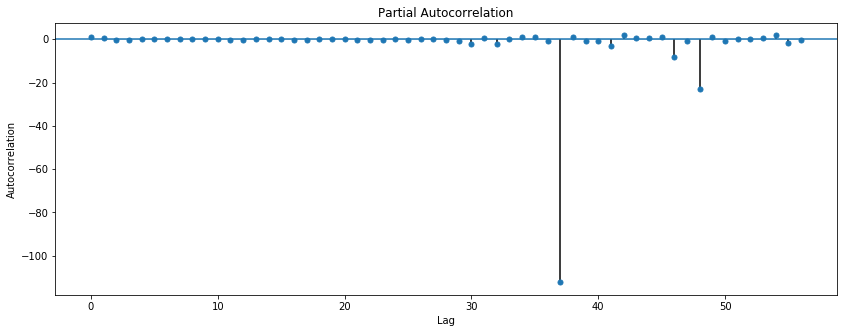

_____________________________________________________________________
60653


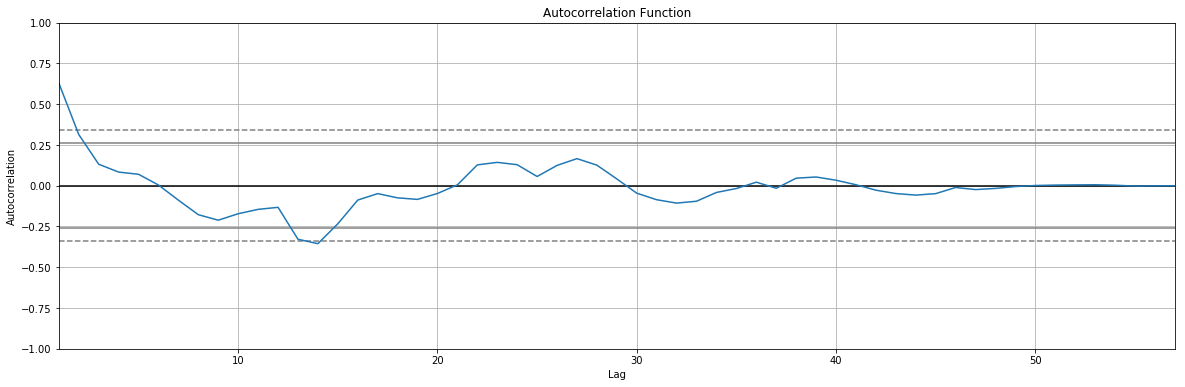

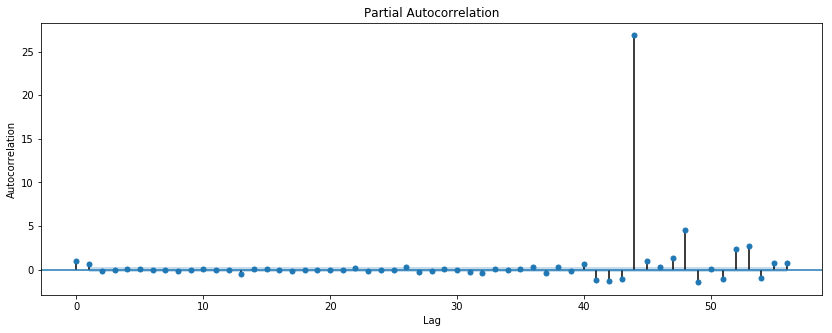

_____________________________________________________________________
60654


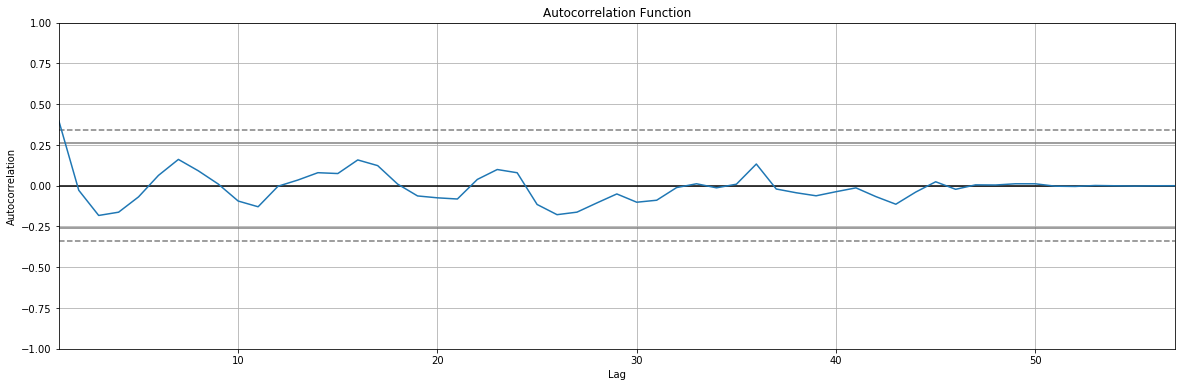

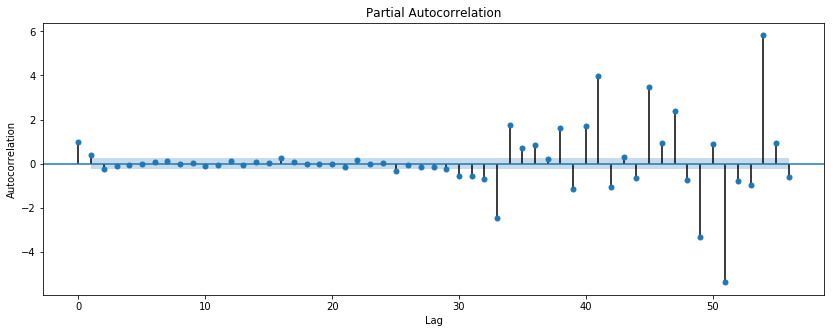

_____________________________________________________________________
60612


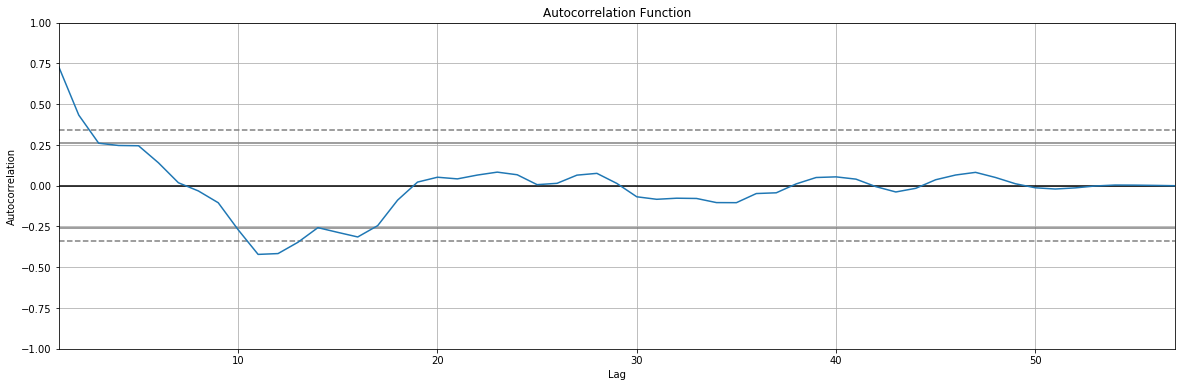

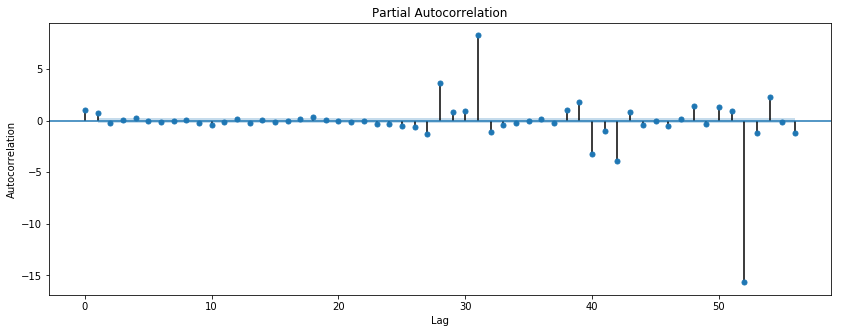

_____________________________________________________________________
60607


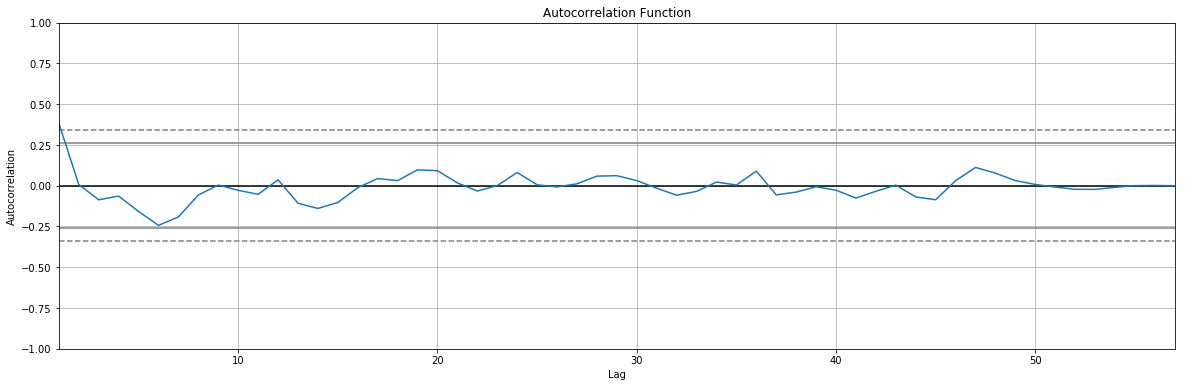

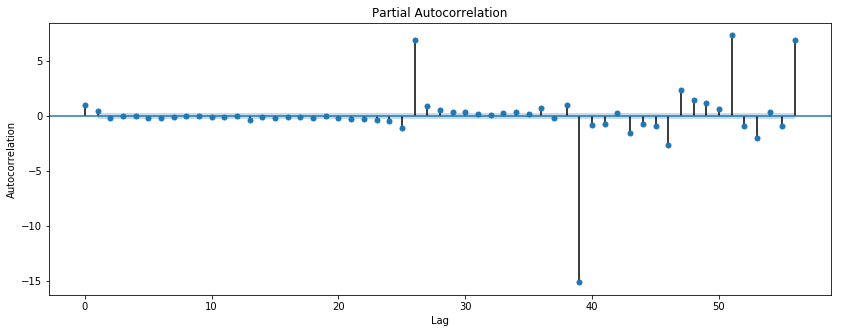

_____________________________________________________________________
60659


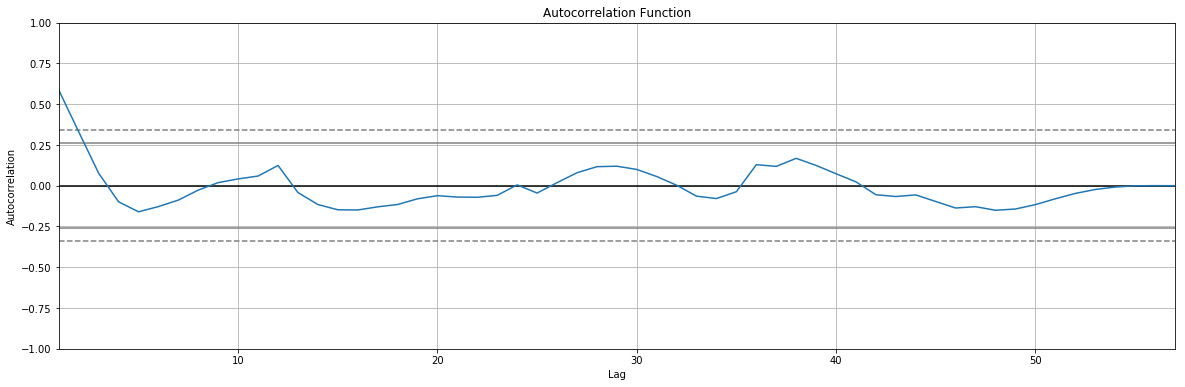

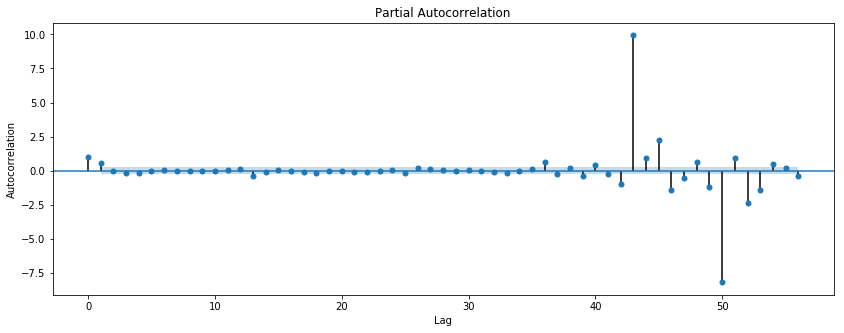

_____________________________________________________________________
60652


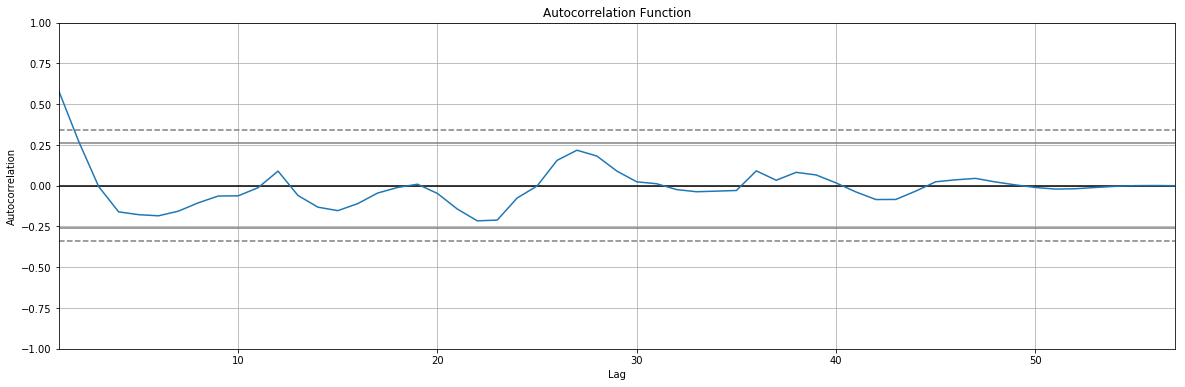

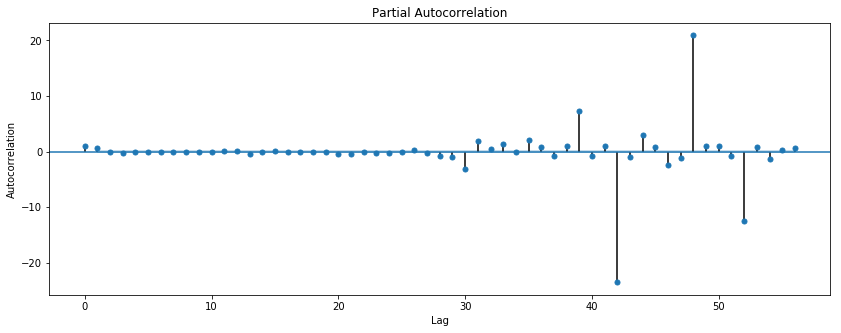

_____________________________________________________________________
60631


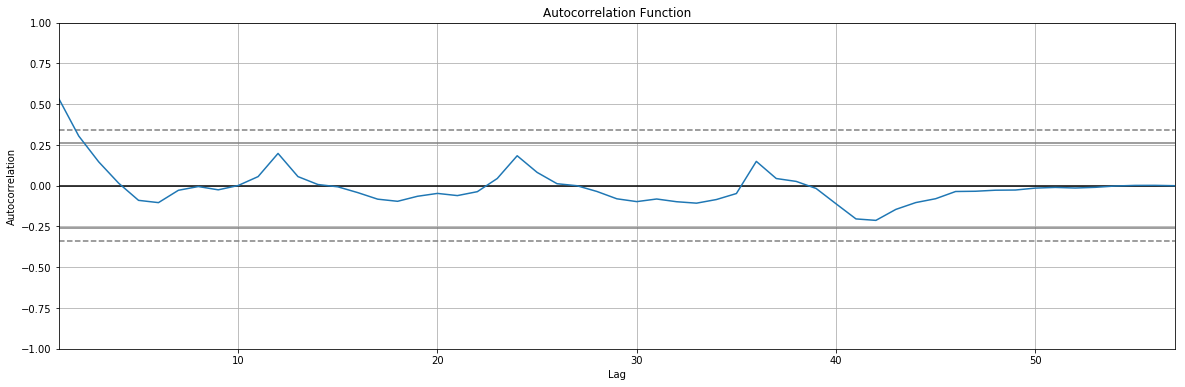

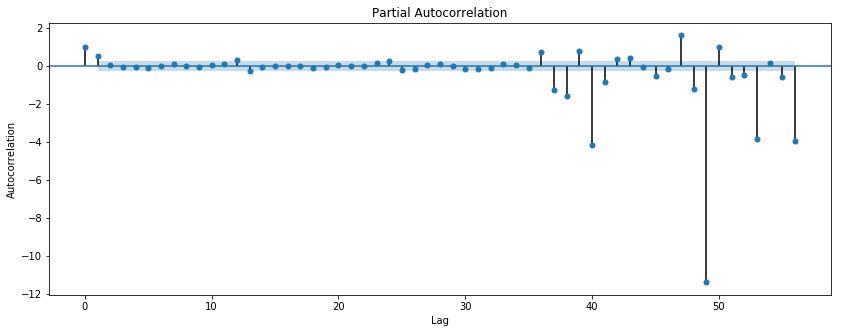

_____________________________________________________________________
60656


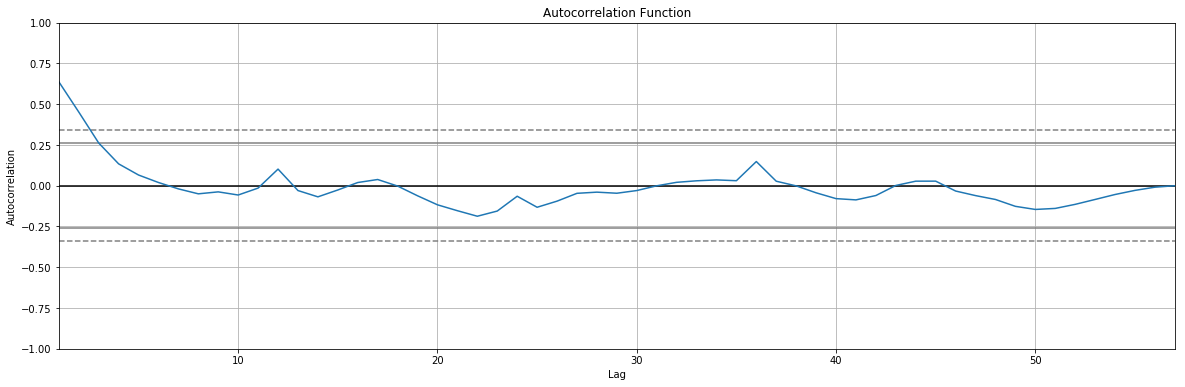

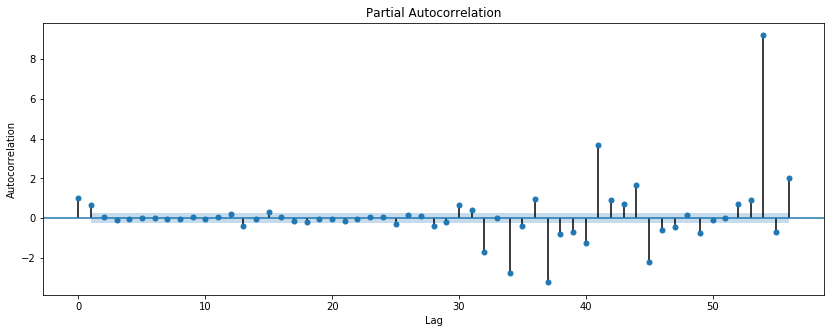

_____________________________________________________________________
60655


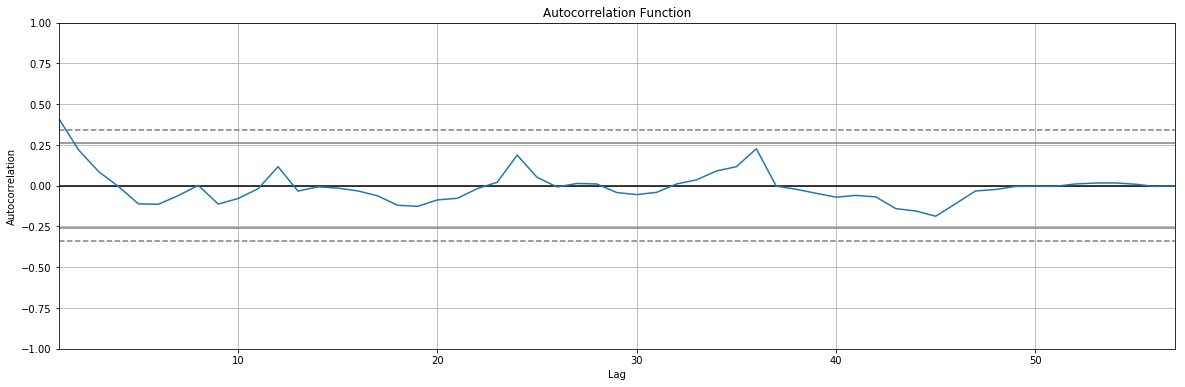

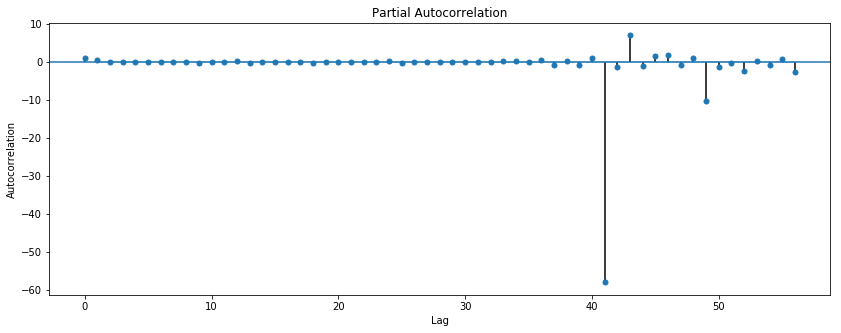

_____________________________________________________________________
60646


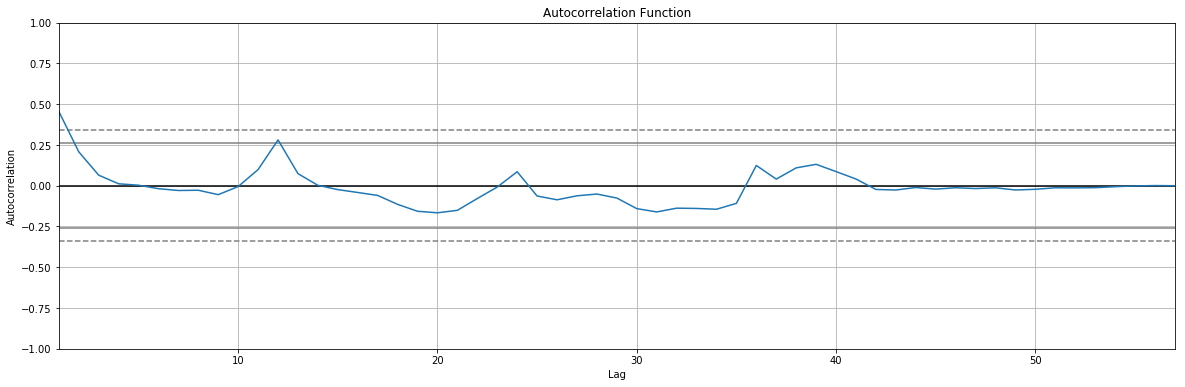

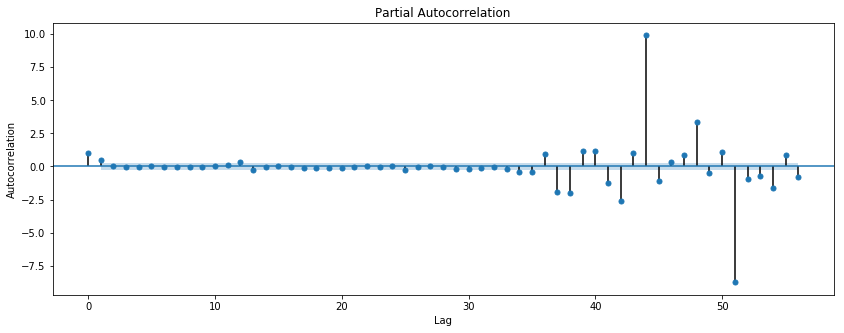

_____________________________________________________________________
60642


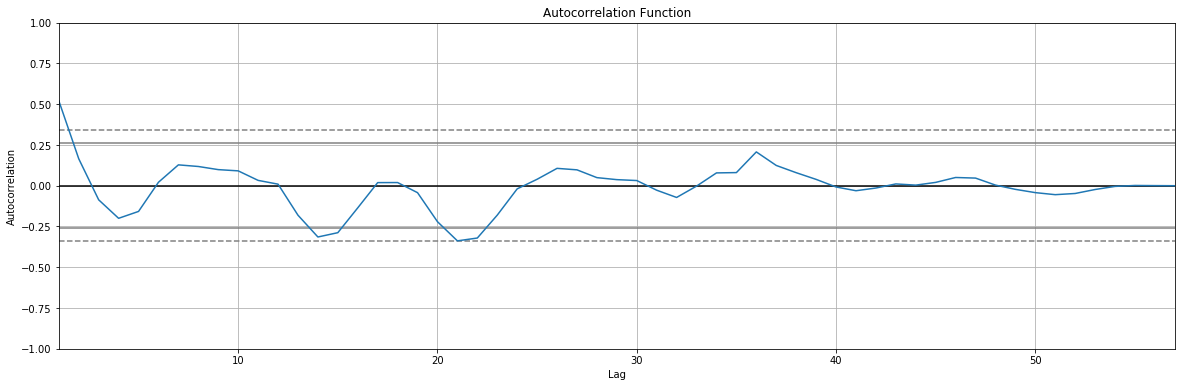

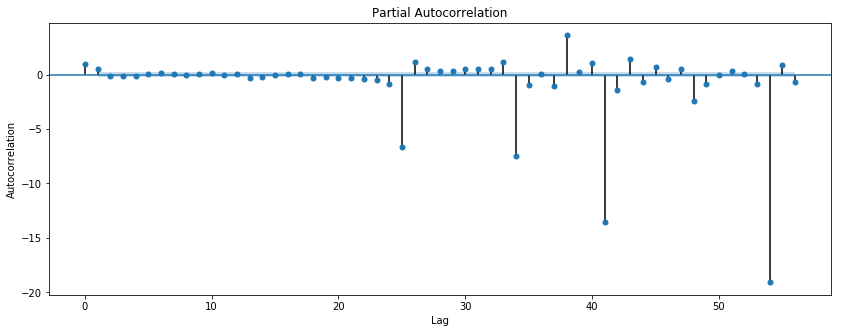

_____________________________________________________________________
60633


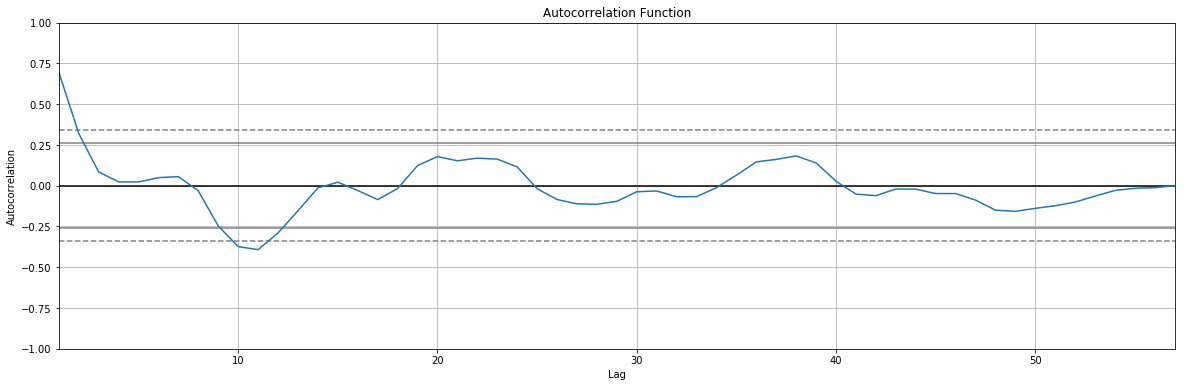

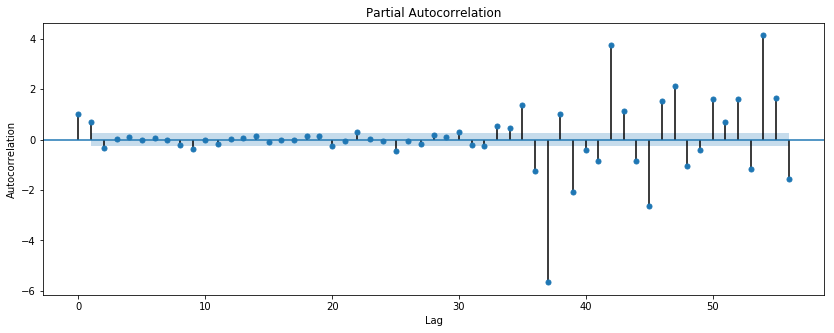

_____________________________________________________________________


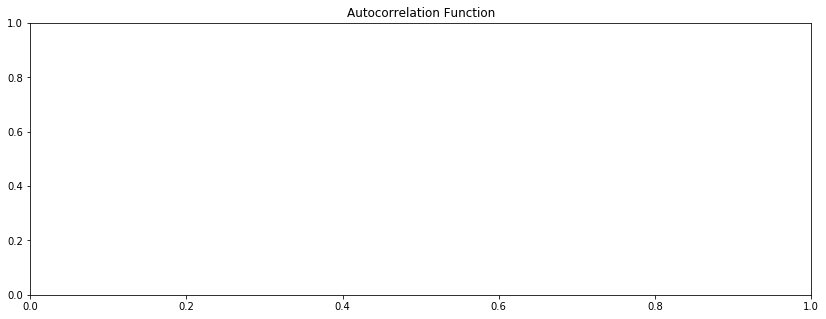

In [311]:
ACF_PACF(zc_train_dt.dropna(), 100)
plt.title('Autocorrelation Function')
plt.show()

### From the plots, we can conclude an AR model with one lag would be an appropriate model to fit the data. 

In [313]:
def evaluate_arima_model(X, test, arima_order):
    # prepare training dataset
    history = [x for x in X]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(np.array(X.dropna()), order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(train_column, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = np.sqrt(evaluate_arima_model(train_column, test, order))
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [272]:
from statsmodels.tsa.arima_model import ARIMA


p_list = [0,1,2,3]
q_list = [0,1,2,3]
d_list = [1]
# _list = [[i, j, k] for i in p_list  
#                  for j in d_list 
#                  for k in q_list] 
# for p, d, q in _list:
#     try:
#         model=None
#         results_ARIMA=None
#         # AR+I+MA = ARIMA model
#         model = ARIMA(np.array(zc_train_dt[60647].dropna()), order=(p,d,q))
#         results_ARIMA = model.fit(disp=-1)
#         print('p: {}, d: {}, q: {}'.format(p,d,q))
#         plt.figure(figsize=(20,6))
#         plt.plot(np.array(zc_train_dt[60647].dropna()))
#         plt.plot(results_ARIMA.fittedvalues, color='orange')
#         plt.show()
#         report_metrics(np.array(zc_train_dt[60647].dropna()), results_ARIMA.fittedvalues)
#         print(results_ARIMA.summary())
        
#     except:
#         pass

#evaluate_arima_model(zillow_chicago_train[60618],test=zillow_chicago_test[60618].dropna() ,arima_order=(1,0,1))
evaluate_models(zc_train_fd[60618],test=zc_test_fd[60618], p_values= p_list, d_values=d_list, q_values=q_list)

Best ARIMA (3, 1, 1) MSE=44578225.872


In [314]:
p_list = [0,1,2,3]
q_list = [0,1,2,3]
d_list = [1]
order_values = []
for column in list(zc_train_fd.columns):
    print(column) 
    order_value = evaluate_models(zc_train_fd[column],test=zc_test_fd[column], 
                               p_values= p_list, d_values=d_list, q_values=q_list) 
    order_values.append(order_value)                        

60657
Best ARIMA (1, 1, 0) RMSE=4340.942
60614
Best ARIMA (1, 1, 2) RMSE=10992.219
60640
Best ARIMA (0, 1, 3) RMSE=5932.441
60647
Best ARIMA (3, 1, 3) RMSE=4241.113
60618
Best ARIMA (3, 1, 1) RMSE=6676.693
60613
Best ARIMA (3, 1, 3) RMSE=5040.831
60629
Best ARIMA (0, 1, 0) RMSE=813.476
60625
Best ARIMA (2, 1, 3) RMSE=5456.712
60619
Best ARIMA (2, 1, 3) RMSE=1833.493
60610
Best ARIMA (2, 1, 2) RMSE=10543.626
60620
Best ARIMA (0, 1, 0) RMSE=2773.555
60634
Best ARIMA (0, 1, 0) RMSE=2203.125
60649
Best ARIMA (0, 1, 0) RMSE=14477.358
60616
Best ARIMA (3, 1, 1) RMSE=3360.369
60622
Best ARIMA (0, 1, 1) RMSE=14449.152
60615
Best ARIMA (0, 1, 3) RMSE=5330.343
60641
Best ARIMA (3, 1, 2) RMSE=1646.330
60660
Best ARIMA (0, 1, 0) RMSE=2029.912
60638
Best ARIMA (2, 1, 3) RMSE=1632.493
60639
Best ARIMA (0, 1, 0) RMSE=2283.052
60630
Best ARIMA (2, 1, 2) RMSE=2403.254
60632
Best ARIMA (2, 1, 1) RMSE=1733.961
60645
Best ARIMA (3, 1, 3) RMSE=3939.703
60653
Best ARIMA (0, 1, 1) RMSE=1866.787
60654
Best AR

In [269]:
zc_fd = pd.concat([zc_train_fd, zc_test_fd], axis=0)

In [297]:
def plot_timeseries_model(data,column,res):
    '''Function will plot the original data, alongside any data for validation and prediction
    
       data: dataframe to be used
       columns: the column to be plotted in your dataframe'''
    
    # Model in Validation Period
    column = column # zipcode column to be put in (string or integer format, depending on how you've referenced before)
    data = data

    # Set the x axis/timeline (in months)
    # (2013-01) till (2017-10) is 57 months (inclusive)
    date_start = 57 # this is number of months since the start of data to start of validation period
    date_end = 63   # this is the number of months since the start of data to end of validation period

    # Produce a new column with the forecast for 2017-11 to 2018-04 (validation period)
    data['{}_forecast'.format(column)] = res.predict(start=date_start, end=date_end, dynamic=False)

    # Plot this new forecasted column with the original data column
    ax = data[[column, '{}_forecast'.format(column)]]
        # figsize
    ax.plot(figsize=(16,12))
        # Title and Axis
    date_start_year = data.index[date_start].year
    date_start_month = data.index[date_start].month
    date_end_year = data.index[date_end].year
    date_end_month = data.index[date_end].month
    
    ax.set(title="Median House Price in Chicago's {} Zipcode\n Between {}-{} and {}-{}".format(column[0], data[date_start_year], data[date_start_month], data[date_end_year], data[date_end_month]), xlabel='Date', ylabel='House Price in Dollars (USD)')


In [699]:
from datetime import datetime
def predict_arima_model(data, column, arima_order, periods):
    predictions = list()
    model = ARIMA(np.array(data[column].dropna()), order=arima_order)
    res = model.fit(disp=0)
    #date_start = 57 # this is number of months since the start of data to start of validation period
    #date_end = 63 # this is the number of months since the start of data to end of validation period
    pred= res.forecast(steps=periods)
    
    from dateutil.relativedelta import relativedelta
    start = datetime.strptime("2017-11-01", "%Y-%m-%d")
    date_list = [start + relativedelta(months=x) for x in range(0,periods)]
    future = pd.DataFrame(data=pred[0], index=date_list)
    complete= pd.concat([data[column], future])
    
    plt.plot(data[column])
    plt.plot(future, color='red', lw=5, ls='--')
    lower = [pred[2][x][0] for x in range(len(pred[2]))]
    lower_bound = pd.DataFrame(data=lower, index=date_list)
    upper = [pred[2][x][1] for x in range(len(pred[2]))]
    upper_bound = pd.DataFrame(data=upper, index=date_list)
    
    plt.fill_between(upper_bound.index,
                    upper,
                    lower, 
                    color='r', 
                    alpha=.3)
    plt.xlabel('Time (years)')
    plt.ylim(100000,1500000)
    plt.ylabel('Median Housing Price')
    plt.title('Median House Price Prediction for Zipcode {}'.format(column))
    final_price = future[0][-1]
    growth_level = final_price - data[column][-1]
    growth_perc = ((final_price - data[column][-1])/data[column][-1])*100
    risk = ((upper[-1]-lower[-1])/lower[-1])*100
    print(' Final Predicted Price: ${}'.format(round(final_price),0),'\n',
          'Total Growth: ${}'.format(round(growth_level,0)),'\n',
          'Percentage Growth: {}%'.format(round(growth_perc,2)),'\n',
          'Risk: {}%'.format(round(risk,2)))

In [700]:
zc_train_fd.columns

Index([60657, 60614, 60640, 60647, 60618, 60613, 60629, 60625, 60619, 60610,
       60620, 60634, 60649, 60616, 60622, 60615, 60641, 60660, 60638, 60639,
       60630, 60632, 60645, 60653, 60654, 60612, 60607, 60659, 60652, 60631,
       60656, 60655, 60646, 60642],
      dtype='object')

 Final Predicted Price: $1043649.0 
 Total Growth: $34049.0 
 Percentage Growth: 3.37% 
 Risk: 11.72%


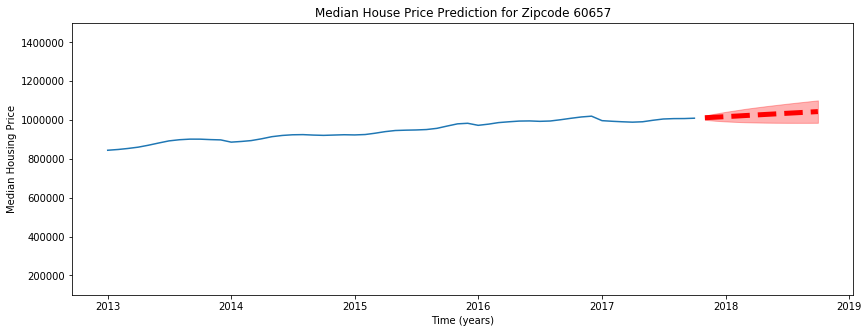

In [701]:
predict_arima_model(zc_train_fd, 60657,arima_order=(1,1,0), periods=12)

 Final Predicted Price: $1298631.0 
 Total Growth: $7131.0 
 Percentage Growth: 0.55% 
 Risk: 11.21%


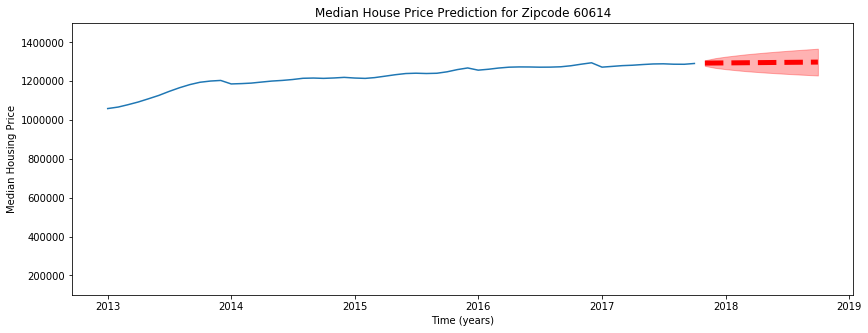

In [702]:
predict_arima_model(zc_train_fd, 60614,arima_order=(1,1,2), periods=12)

 Final Predicted Price: $807375.0 
 Total Growth: $32475.0 
 Percentage Growth: 4.19% 
 Risk: 17.91%


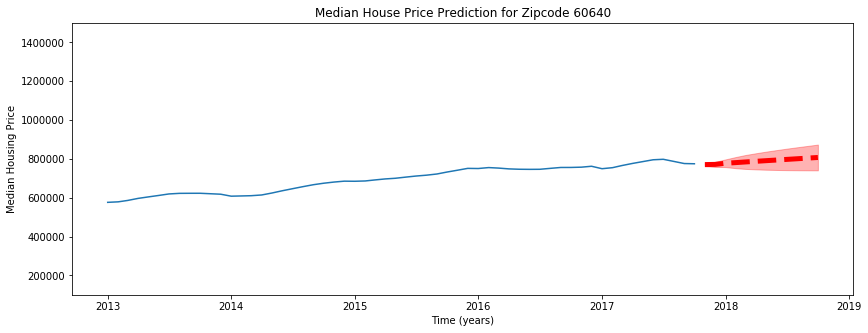

In [703]:
predict_arima_model(zc_train_fd, 60640,arima_order=(0,1,3), periods=12)

 Final Predicted Price: $494782.0 
 Total Growth: $28282.0 
 Percentage Growth: 6.06% 
 Risk: 15.79%


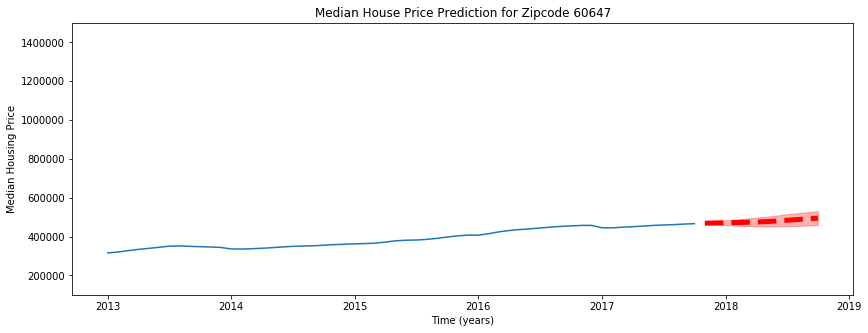

In [704]:
predict_arima_model(zc_train_fd, 60647,arima_order=(3,1,3), periods=12)

 Final Predicted Price: $476626.0 
 Total Growth: $17426.0 
 Percentage Growth: 3.79% 
 Risk: 18.49%


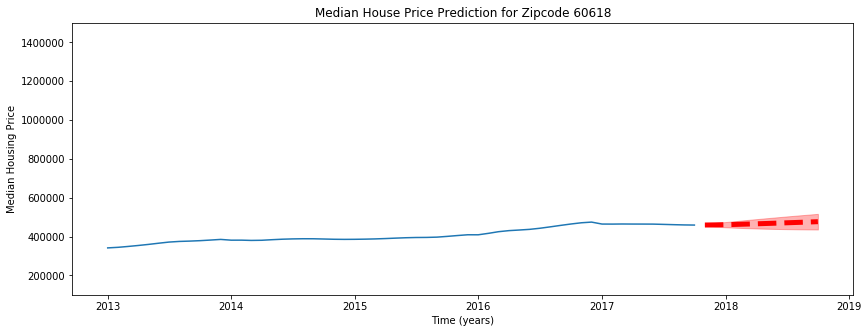

In [705]:
predict_arima_model(zc_train_fd, 60618,arima_order=(3,1,1), periods=12)

 Final Predicted Price: $1073085.0 
 Total Growth: $45285.0 
 Percentage Growth: 4.41% 
 Risk: 8.63%


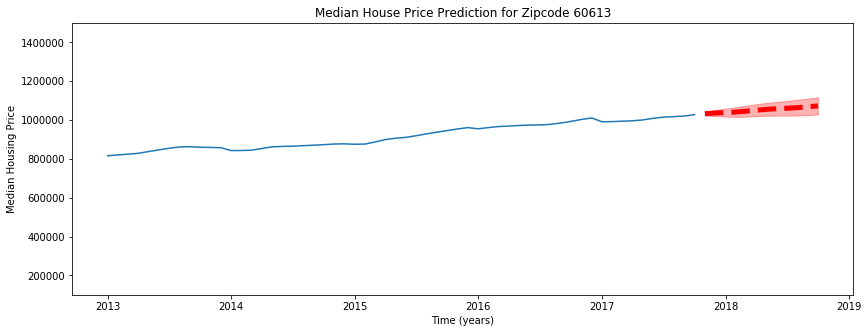

In [706]:
predict_arima_model(zc_train_fd, 60613,arima_order=(3,1,3), periods=12)

 Final Predicted Price: $169369.0 
 Total Growth: $8769.0 
 Percentage Growth: 5.46% 
 Risk: 8.67%


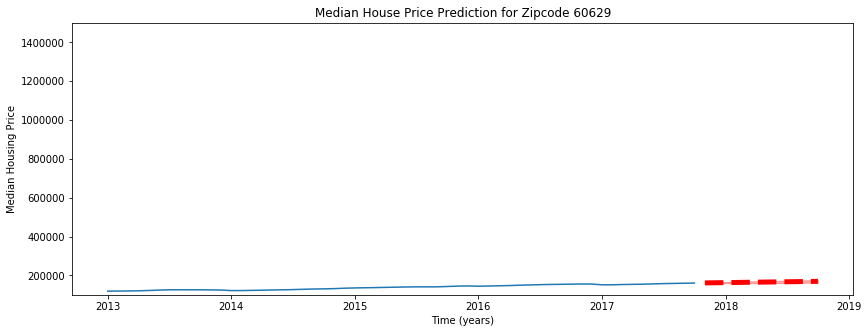

In [707]:
predict_arima_model(zc_train_fd, 60629,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $463712.0 
 Total Growth: $4612.0 
 Percentage Growth: 1.0% 
 Risk: 9.75%


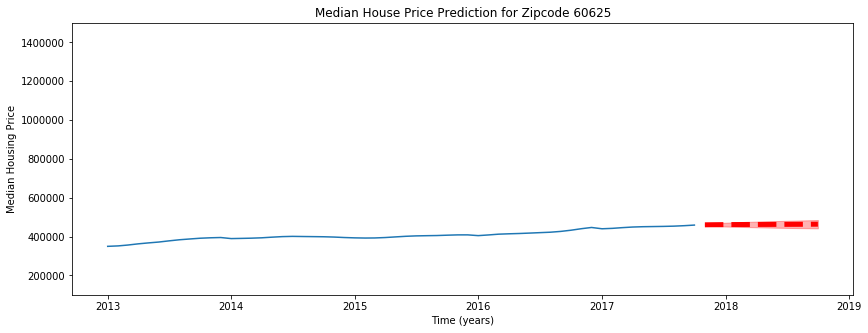

In [708]:
predict_arima_model(zc_train_fd, 60625,arima_order=(2,1,3), periods=12)

 Final Predicted Price: $1045045.0 
 Total Growth: $5845.0 
 Percentage Growth: 0.56% 
 Risk: 4.92%


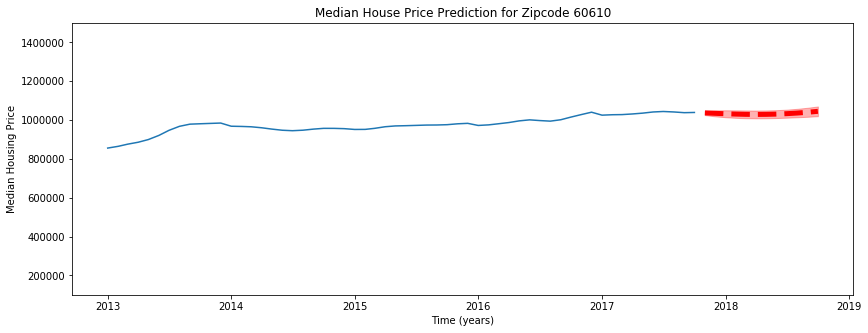

In [709]:
predict_arima_model(zc_train_fd, 60610,arima_order=(2,1,2), periods=12)

 Final Predicted Price: $132988.0 
 Total Growth: $3888.0 
 Percentage Growth: 3.01% 
 Risk: 19.47%


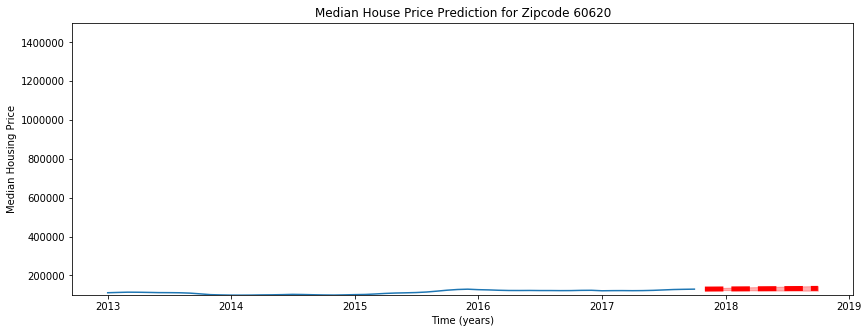

In [710]:
predict_arima_model(zc_train_fd, 60620,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $272590.0 
 Total Growth: $15590.0 
 Percentage Growth: 6.07% 
 Risk: 8.16%


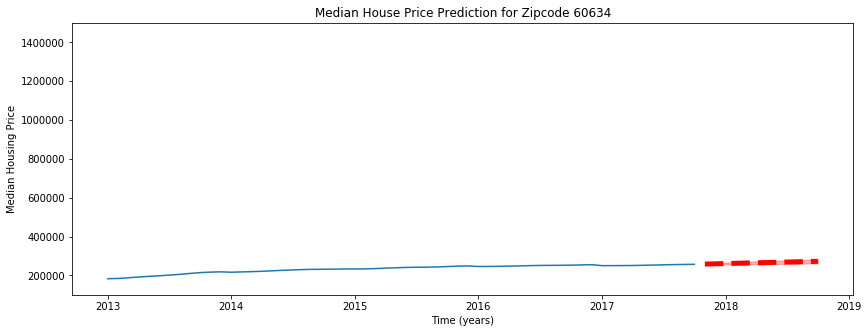

In [711]:
predict_arima_model(zc_train_fd, 60634,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $354172.0 
 Total Growth: $4172.0 
 Percentage Growth: 1.19% 
 Risk: 19.68%


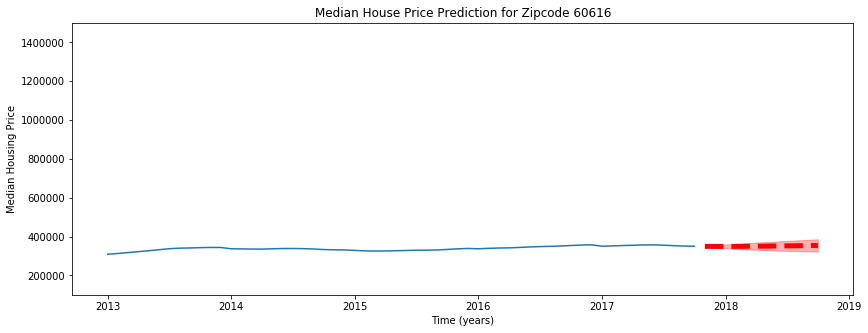

In [712]:
predict_arima_model(zc_train_fd, 60616,arima_order=(3,1,1), periods=12)

 Final Predicted Price: $865462.0 
 Total Growth: $52062.0 
 Percentage Growth: 6.4% 
 Risk: 8.48%


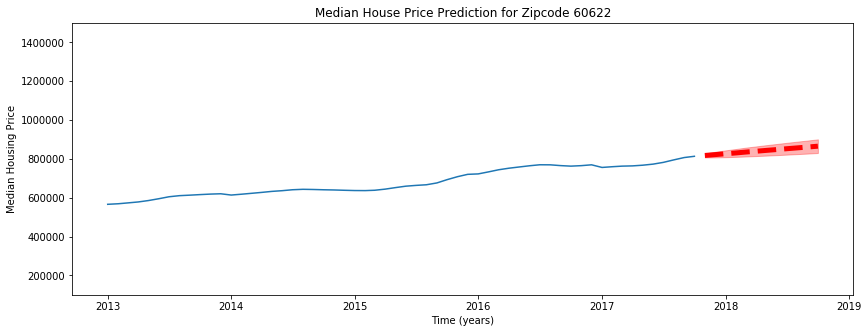

In [713]:
predict_arima_model(zc_train_fd, 60622,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $459910.0 
 Total Growth: $8010.0 
 Percentage Growth: 1.77% 
 Risk: 21.04%


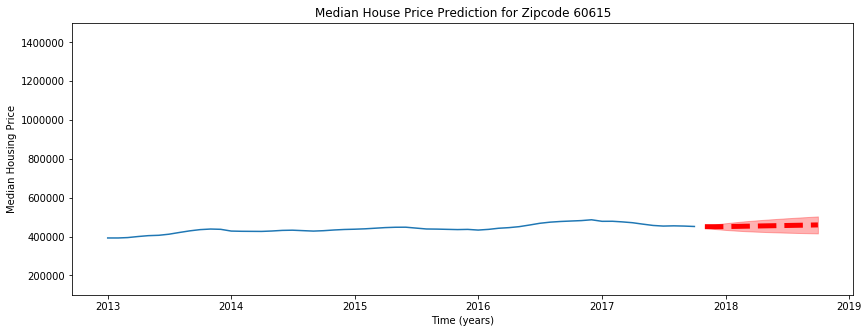

In [714]:
predict_arima_model(zc_train_fd, 60615,arima_order=(0,1,3), periods=12)

 Final Predicted Price: $295133.0 
 Total Growth: $10233.0 
 Percentage Growth: 3.59% 
 Risk: 10.56%


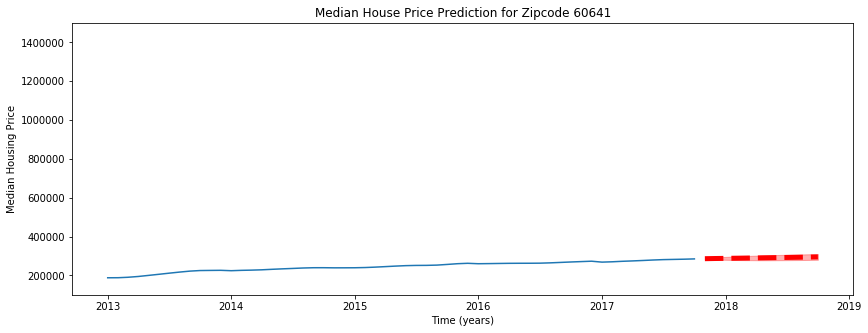

In [715]:
predict_arima_model(zc_train_fd, 60641,arima_order=(3,1,2), periods=12)

 Final Predicted Price: $530380.0 
 Total Growth: $16780.0 
 Percentage Growth: 3.27% 
 Risk: 13.04%


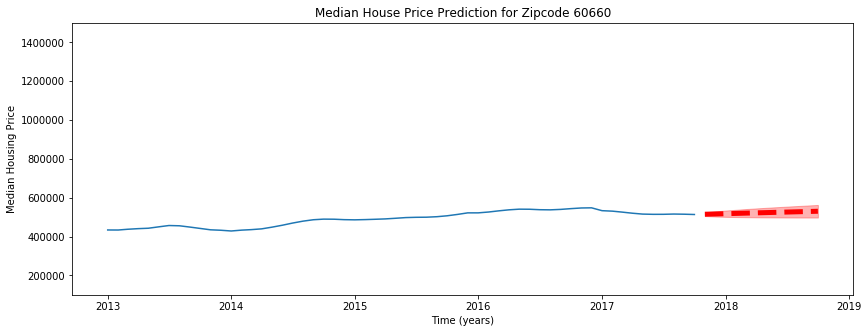

In [716]:
predict_arima_model(zc_train_fd, 60660,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $219671.0 
 Total Growth: $14071.0 
 Percentage Growth: 6.84% 
 Risk: 3.74%


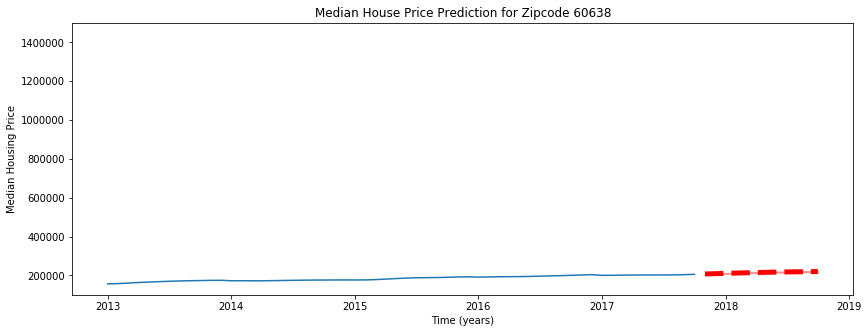

In [717]:
predict_arima_model(zc_train_fd, 60638,arima_order=(2,1,3), periods=12)

 Final Predicted Price: $239241.0 
 Total Growth: $15941.0 
 Percentage Growth: 7.14% 
 Risk: 7.92%


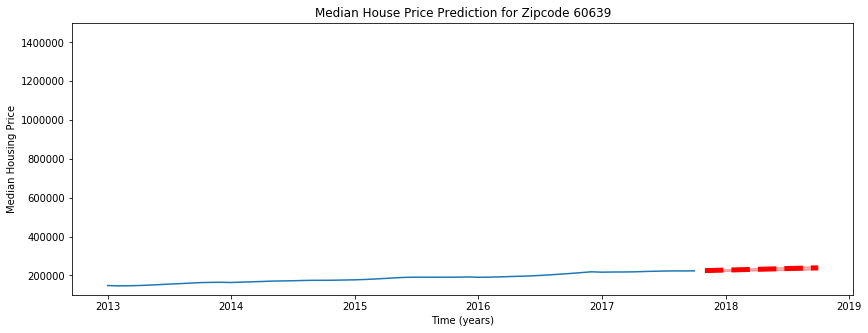

In [718]:
predict_arima_model(zc_train_fd, 60639,arima_order=(0,1,0), periods=12)

 Final Predicted Price: $314187.0 
 Total Growth: $13387.0 
 Percentage Growth: 4.45% 
 Risk: 6.78%


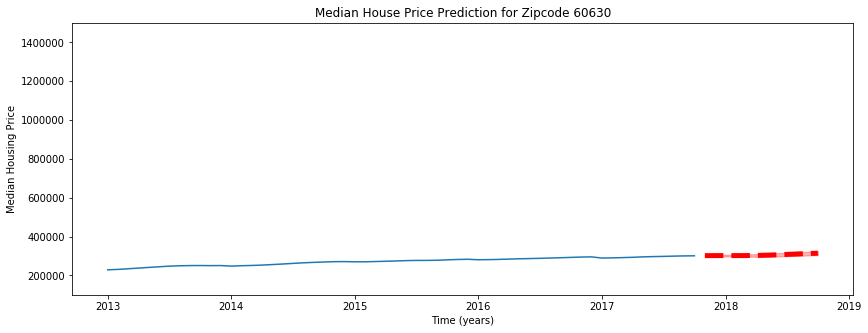

In [719]:
predict_arima_model(zc_train_fd, 60630,arima_order=(2,1,2), periods=12)

 Final Predicted Price: $172116.0 
 Total Growth: $8316.0 
 Percentage Growth: 5.08% 
 Risk: 15.11%


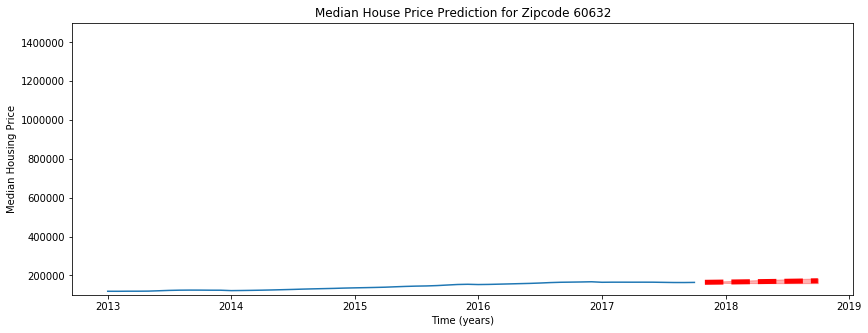

In [720]:
predict_arima_model(zc_train_fd, 60632,arima_order=(2,1,1), periods=12)

 Final Predicted Price: $364567.0 
 Total Growth: $6567.0 
 Percentage Growth: 1.83% 
 Risk: 11.03%


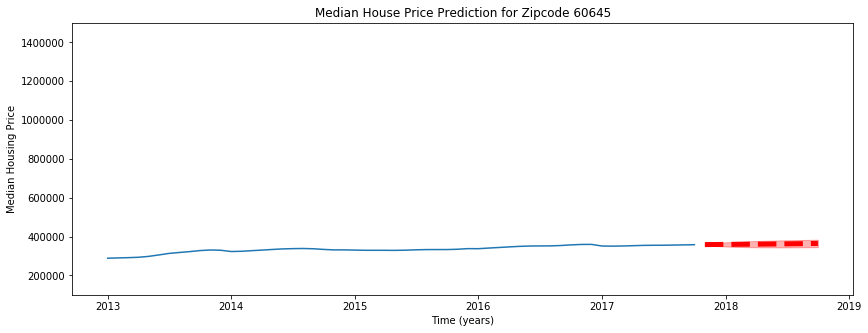

In [721]:
predict_arima_model(zc_train_fd, 60645,arima_order=(3,1,3), periods=12)

 Final Predicted Price: $343229.0 
 Total Growth: $16329.0 
 Percentage Growth: 5.0% 
 Risk: 14.36%


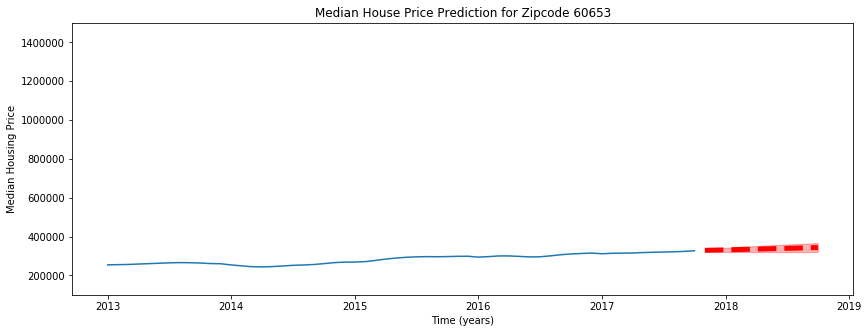

In [722]:
predict_arima_model(zc_train_fd, 60653,arima_order=(0,1,1), periods=12)

 Final Predicted Price: $1514836.0 
 Total Growth: $83836.0 
 Percentage Growth: 5.86% 
 Risk: 8.24%


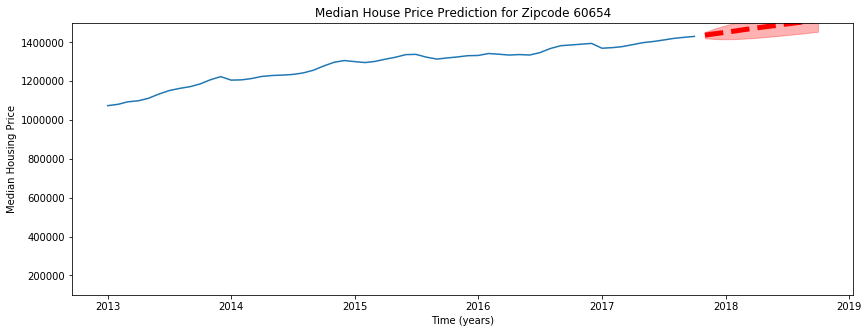

In [723]:
predict_arima_model(zc_train_fd, 60654,arima_order=(2,1,1), periods=12)

 Final Predicted Price: $377775.0 
 Total Growth: $19275.0 
 Percentage Growth: 5.38% 
 Risk: 30.97%


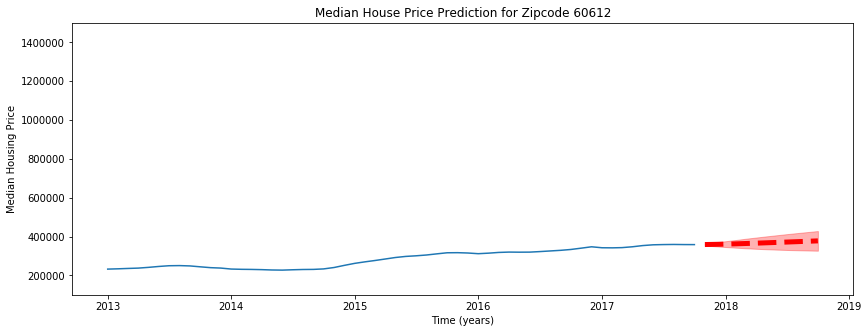

In [724]:
predict_arima_model(zc_train_fd, 60612,arima_order=(1,1,0), periods=12)

 Final Predicted Price: $601200.0 
 Total Growth: $26800.0 
 Percentage Growth: 4.67% 
 Risk: 11.56%


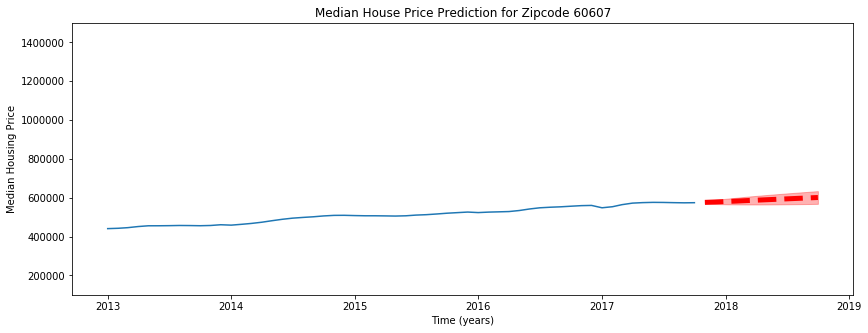

In [725]:
predict_arima_model(zc_train_fd, 60607,arima_order=(1,1,0), periods=12)

 Final Predicted Price: $386498.0 
 Total Growth: $26298.0 
 Percentage Growth: 7.3% 
 Risk: 8.39%


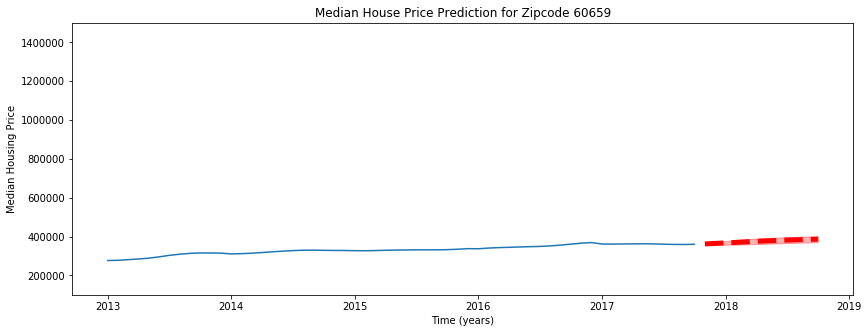

In [726]:
predict_arima_model(zc_train_fd, 60659,arima_order=(2,1,1), periods=12)

 Final Predicted Price: $181865.0 
 Total Growth: $6965.0 
 Percentage Growth: 3.98% 
 Risk: 13.98%


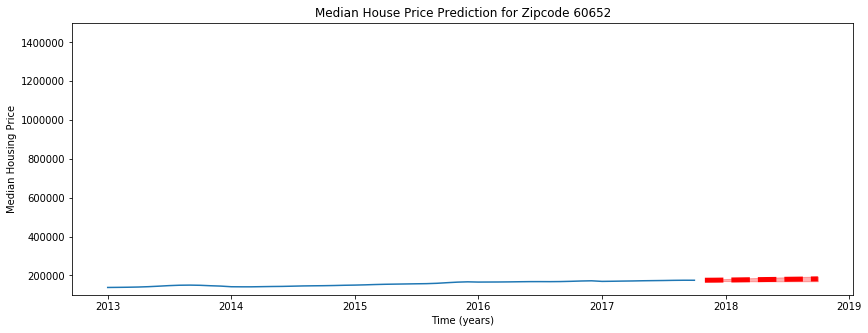

In [727]:
predict_arima_model(zc_train_fd, 60652,arima_order=(3,1,0), periods=12)

 Final Predicted Price: $362273.0 
 Total Growth: $17173.0 
 Percentage Growth: 4.98% 
 Risk: 11.47%


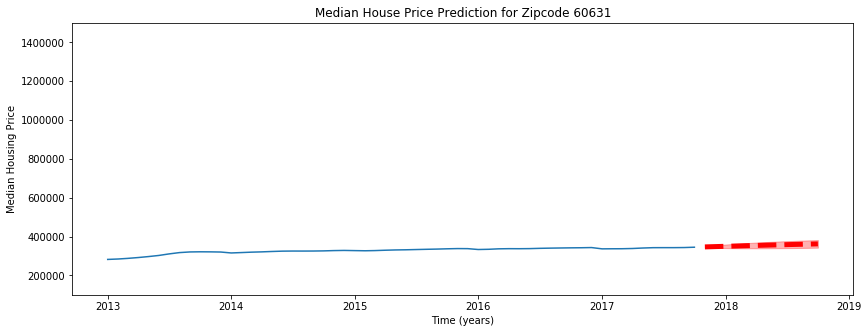

In [728]:
predict_arima_model(zc_train_fd, 60631,arima_order=(2,1,2), periods=12)

 Final Predicted Price: $292481.0 
 Total Growth: $-7619.0 
 Percentage Growth: -2.54% 
 Risk: 10.92%


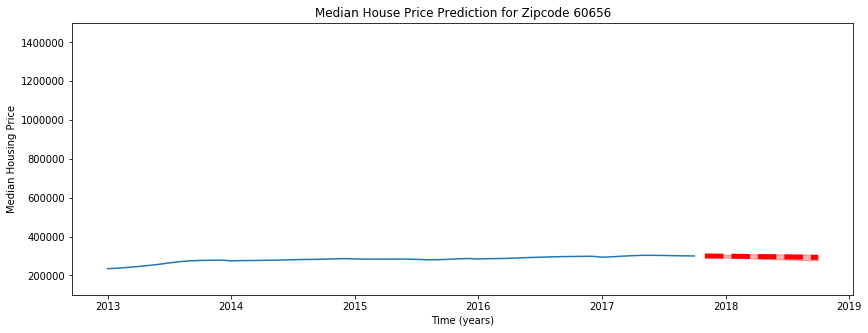

In [729]:
predict_arima_model(zc_train_fd, 60656,arima_order=(2,1,3), periods=12)

 Final Predicted Price: $238683.0 
 Total Growth: $12683.0 
 Percentage Growth: 5.61% 
 Risk: 7.45%


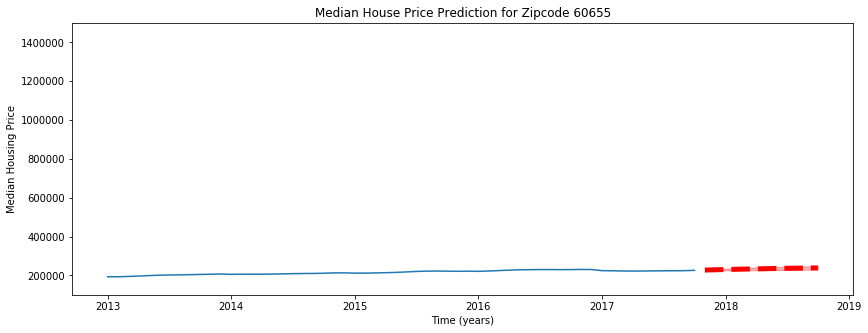

In [730]:
predict_arima_model(zc_train_fd, 60655,arima_order=(2,1,2), periods=12)

 Final Predicted Price: $401812.0 
 Total Growth: $12112.0 
 Percentage Growth: 3.11% 
 Risk: 12.43%


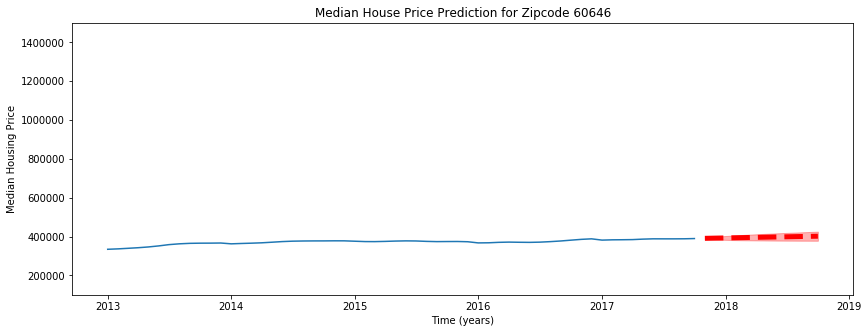

In [731]:
predict_arima_model(zc_train_fd, 60646,arima_order=(0,1,3), periods=12)

 Final Predicted Price: $625270.0 
 Total Growth: $29770.0 
 Percentage Growth: 5.0% 
 Risk: 15.65%


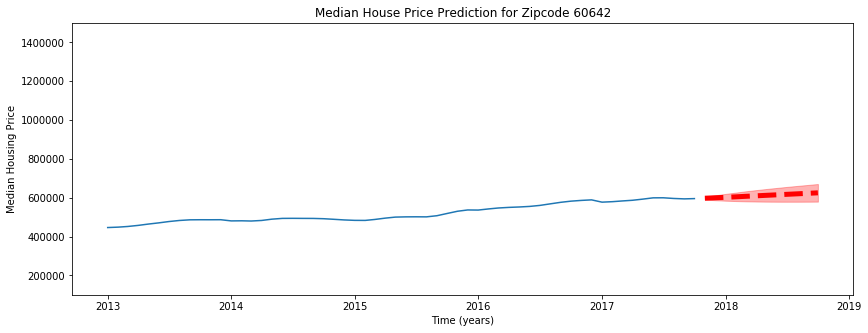

In [732]:
predict_arima_model(zc_train_fd, 60642,arima_order=(1,1,0), periods=12)